<img src="./Images/f5a0b03f4fd95382666e583b074f34b7.png">

# <h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 48px; color: #7B68EE; text-align: center; line-height: 1.25;">Анализ временных рядов<br><span style="color: #4682B4; font-size: 70px"><b>**ПРОГНОЗ ПОТРЕБЛЕНИЯ ЭЛЕКТРОЭНЕРГИИ**<br>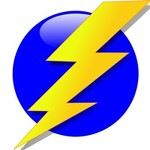</b>

***
<a id="0">

## <b> 0 <span style='color:#FFAE42'> | </span> СОДЕРЖАНИЕ </b>

- [0. Содержание](#0)
- [1. Краткий обзор](#1)
- [2. Импорт библиотек и модулей](#2)
- [3. Предварительный анализ, обработка и очистка данных](#3)
    - [3.1 Обработка и очистка данных](#3.1)
    - [3.2 Визуализация очищенных исходных данных](#3.2)
    - [3.3 Графический анализ энергопотребления](#3.3)
    - [3.4 Графический анализ энергопотребления с учётом времени года](#3.4)
    - [3.5 Анализ на гистограммах по временам года](#3.5)
- [4. Статистический анализ данных](#4)
    - [4.1 Сезонная декомпозиция](#4.1)
    - [4.2 Стационарность и гетероскедастичность](#4.2)
    - [4.3 Автокорреляция и частичная автокорреляция](#4.3)
- [5. Моделирование временных рядов](#5)
    - [5.1 Подготовка данных к моделированию](#5.1)
    - [5.2 Модель Baseline - наивный прогноз](#5.2)
    - [5.3 Модель HWES - тройное экспонециальное сглаживание Холта-Винтера](#5.3)
    - [5.4 Модель XGBoost](#5.4)
    - [5.5 Модель Lasso - L1-регрессия](#5.5)
    - [5.6 Модель SARIMA](#5.6)
    - [5.7 Модель Prophet](#5.7)
- [6. Выводы](#6)

***
<a id='1'></a>

## <b> <font color = '#3E61A3'> 1 <span style='color:#FFAE42'> | </span> <font color = '#3E61A3'> КРАТКИЙ ОБЗОР </b>

Будем использовать данные о потреблении энергии с сайта региональной организации США *PJM*. С их помощью можно построить модель временных рядов, чтобы прогнозировать энергетический расход. Кроме того, эти данные пригодятся, чтобы выявить тенденции расходов по времени суток, праздникам и более длительным срокам.<br>
С данными можно ознакомиться [здесь](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption).

>**Данные о почасовом потреблении энергии *PJM***

*PJM Interconnection LLC (PJM)* - региональная организация передачи данных *(RTO)* в Соединенных Штатах. Это часть сети Восточного межсоединения, управляющая системой передачи электроэнергии, обслуживающей весь или части Делавэра, Иллинойса, Индианы, Кентукки, Мэриленда, Мичигана, Нью-Джерси, Северной Каролины, Огайо, Пенсильвании, Теннесси, Вирджинии, Западной Вирджинии и округа Колумбия.

Данные о почасовом потреблении энергии берутся с веб-сайта *PJM* и выражаются в мегаваттах (МВт*ч).

Регионы менялись с годами, поэтому данные могут отображаться только для определенных дат в каждом регионе.

***
<a id="2">

## <b> 2 <span style='color:#FFAE42'> | </span> ИМПОРТ БИБЛИОТЕК И МОДУЛЕЙ </b>

In [1]:
# Импортируем необходимые библиотеки и модули:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
%matplotlib inline
import seaborn as sns #для визуализации
import statsmodels.api as sm
import statsmodels.stats.api as sms
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import shap
import itertools
import math
import sklearn.preprocessing

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan as BP
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import meanabs, rmse, medianabs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LassoCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from pylab import rcParams
# Изменяем графики matplotlib по умолчанию на этот размер
rcParams['figure.figsize'] = 11, 7 

***
<a id="3">

## <b> 3 <span style='color:#FFAE42'> | </span> ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ, ОБРАБОТКА И ОЧИСТКА ДАННЫХ </b>

<a id="3.1">

### <b> 3.1 <span style='color:#FFAE42'> | </span> Обработка и очистка данных </b>

In [2]:
# Прочитаем данные и посмотрим на первые и последние 5 строк датасета.

pjm_hourly_est = pd.read_csv('data\pjm_hourly_est.csv')
pjm_hourly_est

Datetime      AEP    COMED  DAYTON    DEOK      DOM  \
0       1998-12-31 01:00:00      NaN      NaN     NaN     NaN      NaN   
1       1998-12-31 02:00:00      NaN      NaN     NaN     NaN      NaN   
2       1998-12-31 03:00:00      NaN      NaN     NaN     NaN      NaN   
3       1998-12-31 04:00:00      NaN      NaN     NaN     NaN      NaN   
4       1998-12-31 05:00:00      NaN      NaN     NaN     NaN      NaN   
...                     ...      ...      ...     ...     ...      ...   
178257  2018-01-01 20:00:00  21089.0  13858.0  2732.0  4426.0  18418.0   
178258  2018-01-01 21:00:00  20999.0  13758.0  2724.0  4419.0  18567.0   
178259  2018-01-01 22:00:00  20820.0  13627.0  2664.0  4355.0  18307.0   
178260  2018-01-01 23:00:00  20415.0  13336.0  2614.0  4224.0  17814.0   
178261  2018-01-02 00:00:00  19993.0  12816.0  2552.0  4100.0  17428.0   

           DUQ    EKPC      FE  NI     PJME    PJMW  PJM_Load  
0          NaN     NaN     NaN NaN      NaN     NaN   29309.0  
1          NaN     NaN     NaN NaN      NaN     NaN   28236.0  
2          NaN     NaN     NaN NaN      NaN     NaN   27692.0  
3          NaN     NaN     NaN NaN      NaN     NaN   27596.0  
4          NaN     NaN     NaN NaN      NaN     NaN   27888.0  
...        ...     ...     ...  ..      ...     ...       ...  
178257  1962.0  2866.0  9378.0 NaN  44284.0  8401.0       NaN  
178258  1940.0  2846.0  9255.0 NaN  43751.0  8373.0       NaN  
178259  1891.0  2883.0  9044.0 NaN  42402.0  8238.0       NaN  
178260  1820.0  2880.0  8676.0 NaN  40164.0  7958.0       NaN  
178261  1721.0  2846.0  8393.0 NaN  38608.0  7691.0       NaN  

[178262 rows x 13 columns]

> Как видим данные представлены за 19 лет (без учёта 1998 года и 2018 года, т.к. там данные, на первый взляд, представлены одним днём).<br>
> Всего в данных 178262 строки, причём значительное число данных пропущено (NaN).<br>
> Данные представлены в 12 энергетических регионах.<br>
> Нужно будет проверить отсортированы ли по порядку данные и нет ли дубликатов.

In [3]:
pjm_hourly_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  178262 non-null  object 
 1   AEP       121273 non-null  float64
 2   COMED     66497 non-null   float64
 3   DAYTON    121275 non-null  float64
 4   DEOK      57739 non-null   float64
 5   DOM       116189 non-null  float64
 6   DUQ       119068 non-null  float64
 7   EKPC      45334 non-null   float64
 8   FE        62874 non-null   float64
 9   NI        58450 non-null   float64
 10  PJME      145366 non-null  float64
 11  PJMW      143206 non-null  float64
 12  PJM_Load  32896 non-null   float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


> Здесь мы видим почему много пропущенных данных.<br>
> Это связано с тем, что данные в каждом энергорегионе представлены за разные промежутки времени и при сведении всех данных в одну таблицу появились пропуски.

In [4]:
# Посмотрим на статистику данных.

pjm_hourly_est.describe().round(1)

AEP    COMED    DAYTON     DEOK       DOM       DUQ     EKPC  \
count  121273.0  66497.0  121275.0  57739.0  116189.0  119068.0  45334.0   
mean    15499.5  11420.2    2037.9   3105.1   10949.2    1658.8   1464.2   
std      2591.4   2304.1     393.4    599.9    2413.9     301.7    378.9   
min      9581.0   7237.0     982.0    907.0    1253.0    1014.0    514.0   
25%     13630.0   9780.0    1749.0   2687.0    9322.0    1444.0   1185.0   
50%     15310.0  11152.0    2009.0   3013.0   10501.0    1630.0   1386.0   
75%     17200.0  12510.0    2279.0   3449.0   12378.0    1819.0   1699.0   
max     25695.0  23753.0    3746.0   5445.0   21651.0    3054.0   3490.0   

            FE       NI      PJME      PJMW  PJM_Load  
count  62874.0  58450.0  145366.0  143206.0   32896.0  
mean    7792.2  11701.7   32080.2    5602.4   29766.4  
std     1331.3   2371.5    6464.0     979.1    5849.8  
min        0.0   7003.0   14544.0     487.0   17461.0  
25%     6807.0   9954.0   27573.0    4907.0   25473.0  
50%     7700.0  11521.0   31421.0    5530.0   29655.0  
75%     8556.0  12896.8   35650.0    6252.0   33073.2  
max    14032.0  23631.0   62009.0    9594.0   54030.0

> Объём данных в регионах различный (минимум в `PJM_Load` - 32896.0, максимум в `PJME` - 145366.0).<br>
> Наиболее большие выборки представлены в следующих регионах: `AEP`, `DAYTON`, `DOM`, `DUQ`, `PJME`, `PJMW`.<br>
> Предварительно видно, что данные более-менее равномерные, т.к. средние и медианные значения близки, а стандартное отклонение составляет 10-15 %.

In [5]:
# Посмотрим статистику по исходному временному столбцу.
print(pjm_hourly_est['Datetime'].describe())

count                  178262
unique                 178258
top       2017-11-05 02:00:00
freq                        2
Name: Datetime, dtype: object


> Видим, что уникальные значения отличаются от значения счёта, которое показывает, что существует дубликатная метка времени.<br>
> Преобразуем строку в формат `TimesStamp` для *Pandas* через `to_DateTime`.<br>
> После того, как столбец времени преобразуем, повторно посмотрим на статистические результаты.

In [6]:
pjm_hourly_est['Datetime'] = pd.to_datetime(pjm_hourly_est['Datetime'],format='%Y-%m-%d %H:%M:%S')
print(pjm_hourly_est['Datetime'].describe())

count                           178262
mean     2008-06-01 15:46:51.203734016
min                1998-04-01 01:00:00
25%                2003-05-02 09:15:00
50%                2008-06-01 16:30:00
75%                2013-07-03 00:45:00
max                2018-08-03 00:00:00
Name: Datetime, dtype: object


> Видим, что время начала - `1998-04-01 01:00:00`, а время окончания - `2018-08-03 00:00:00`.<br>
> Если мы вернёмся немного назад и посмотрим на первые и последние пять строк датасета, мы найдём, что время первой и последней строк не совпадают с минимальным `1998-04-01 01:00:00` и максимальным `2018-08-03 00:00:00` временем.<br>
> Всё это показывает, что датасет не отсортирован в порядке времени, необходимо будет отсортировать.

In [7]:
pjm_hourly_est = pd.pivot_table(data=pjm_hourly_est,index='Datetime',aggfunc='mean').reset_index()
pjm_hourly_est.sort_values(by='Datetime',inplace=True)
pjm_hourly_est.set_index('Datetime',inplace=True)
pjm_hourly_est

AEP    COMED  DAYTON    DEOK      DOM     DUQ  \
Datetime                                                                 
1998-04-01 01:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-04-01 02:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-04-01 03:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-04-01 04:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-04-01 05:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
...                      ...      ...     ...     ...      ...     ...   
2018-08-02 20:00:00  17673.0  16437.0  2554.0  4052.0  14038.0  1966.0   
2018-08-02 21:00:00  17303.0  15590.0  2481.0  3892.0  13832.0  1944.0   
2018-08-02 22:00:00  17001.0  15086.0  2405.0  3851.0  13312.0  1901.0   
2018-08-02 23:00:00  15964.0  14448.0  2250.0  3575.0  12390.0  1789.0   
2018-08-03 00:00:00  14809.0  13335.0  2042.0  3281.0  11385.0  1656.0   

                       EKPC      FE  NI     PJME    PJMW  PJM_Load  
Datetime                                                            
1998-04-01 01:00:00     NaN     NaN NaN      NaN     NaN   22259.0  
1998-04-01 02:00:00     NaN     NaN NaN      NaN     NaN   21244.0  
1998-04-01 03:00:00     NaN     NaN NaN      NaN     NaN   20651.0  
1998-04-01 04:00:00     NaN     NaN NaN      NaN     NaN   20421.0  
1998-04-01 05:00:00     NaN     NaN NaN      NaN     NaN   20713.0  
...                     ...     ...  ..      ...     ...       ...  
2018-08-02 20:00:00  1815.0  9866.0 NaN  44057.0  6545.0       NaN  
2018-08-02 21:00:00  1769.0  9656.0 NaN  43256.0  6496.0       NaN  
2018-08-02 22:00:00  1756.0  9532.0 NaN  41552.0  6325.0       NaN  
2018-08-02 23:00:00  1619.0  8872.0 NaN  38500.0  5892.0       NaN  
2018-08-03 00:00:00  1448.0  8198.0 NaN  35486.0  5489.0       NaN  

[178258 rows x 12 columns]

> Теперь всё нормально, данные отсортированы по времени.<br>
> Посмотрим как всё это выглядит визуально.

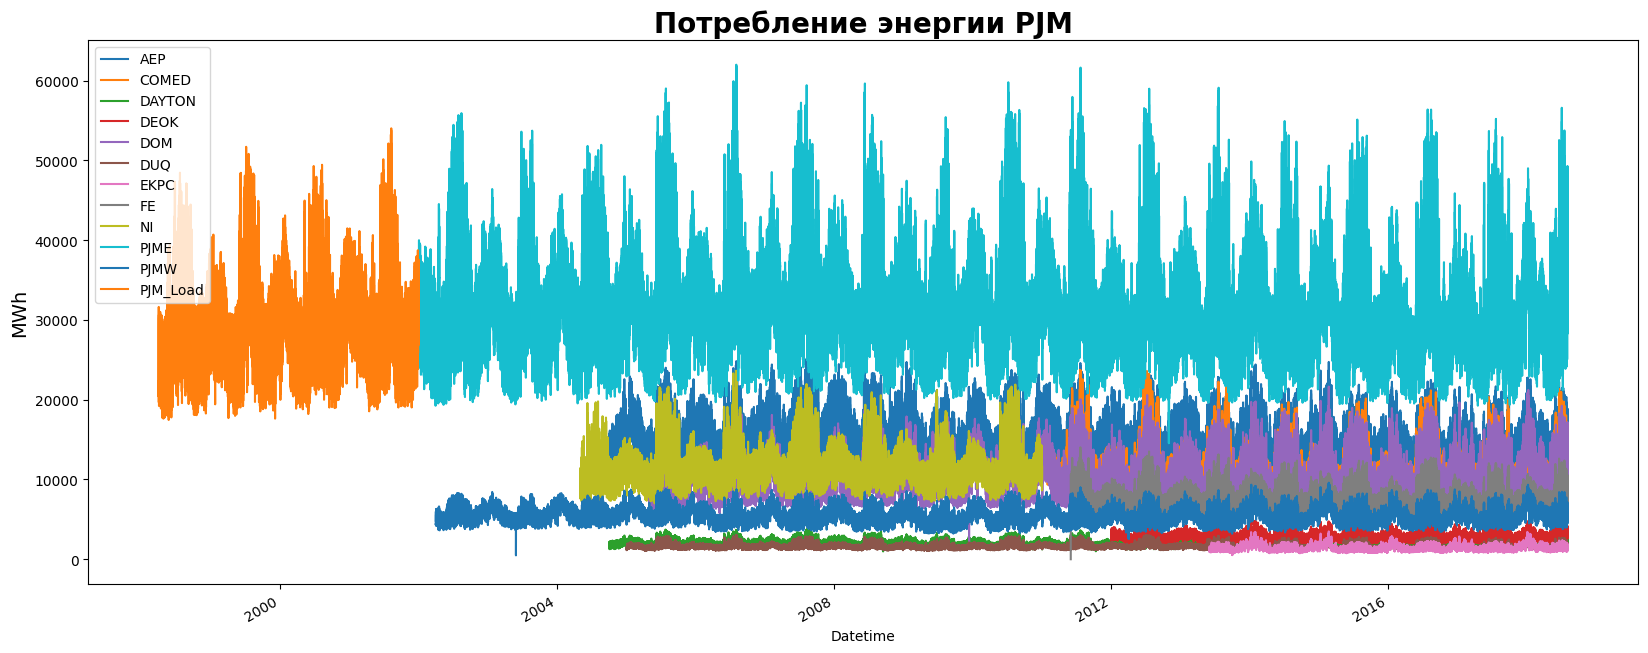

In [8]:
# Построим диаграмму исходных данных

pjm_hourly_est.plot(figsize=(20,8))
plt.title('Потребление энергии PJM', weight='bold', fontsize=20);
plt.ylabel('MWh', fontsize=14); # ось ординат


> Конечно, при большом желании можно разобраться, но на первый взгляд выглядит всё довольно сумбурно.<br>
> Чтобы облегчить восприятие, возьмём в дальнейшую работу только два признака: западный `PJMW` и восточный `PJME` энергорегионы.
>

In [9]:
# Возьмём, для простоты расчётов, данные только по двум регионам.

df = pjm_hourly_est[['PJMW', 'PJME']]
df

PJMW     PJME
Datetime                            
1998-04-01 01:00:00     NaN      NaN
1998-04-01 02:00:00     NaN      NaN
1998-04-01 03:00:00     NaN      NaN
1998-04-01 04:00:00     NaN      NaN
1998-04-01 05:00:00     NaN      NaN
...                     ...      ...
2018-08-02 20:00:00  6545.0  44057.0
2018-08-02 21:00:00  6496.0  43256.0
2018-08-02 22:00:00  6325.0  41552.0
2018-08-02 23:00:00  5892.0  38500.0
2018-08-03 00:00:00  5489.0  35486.0

[178258 rows x 2 columns]

In [10]:
# Посмотрим - сколько пропущенных значений в каждой колонке.

df.isnull().sum()

PJMW    35056
PJME    32896
dtype: int64

> Поскольку объём данных у нас довольно значительный просто избавимся от недостающих значений

In [11]:
# удаляем пропущенные значения
df = df.dropna(axis=0)
df.shape

(143202, 2)

<a id="3.2">

### <b> 3.2 <span style='color:#FFAE42'> | </span> Визуализация очищенных исходных данных </b>

> Посмотрим визуально, что у нас получилось.

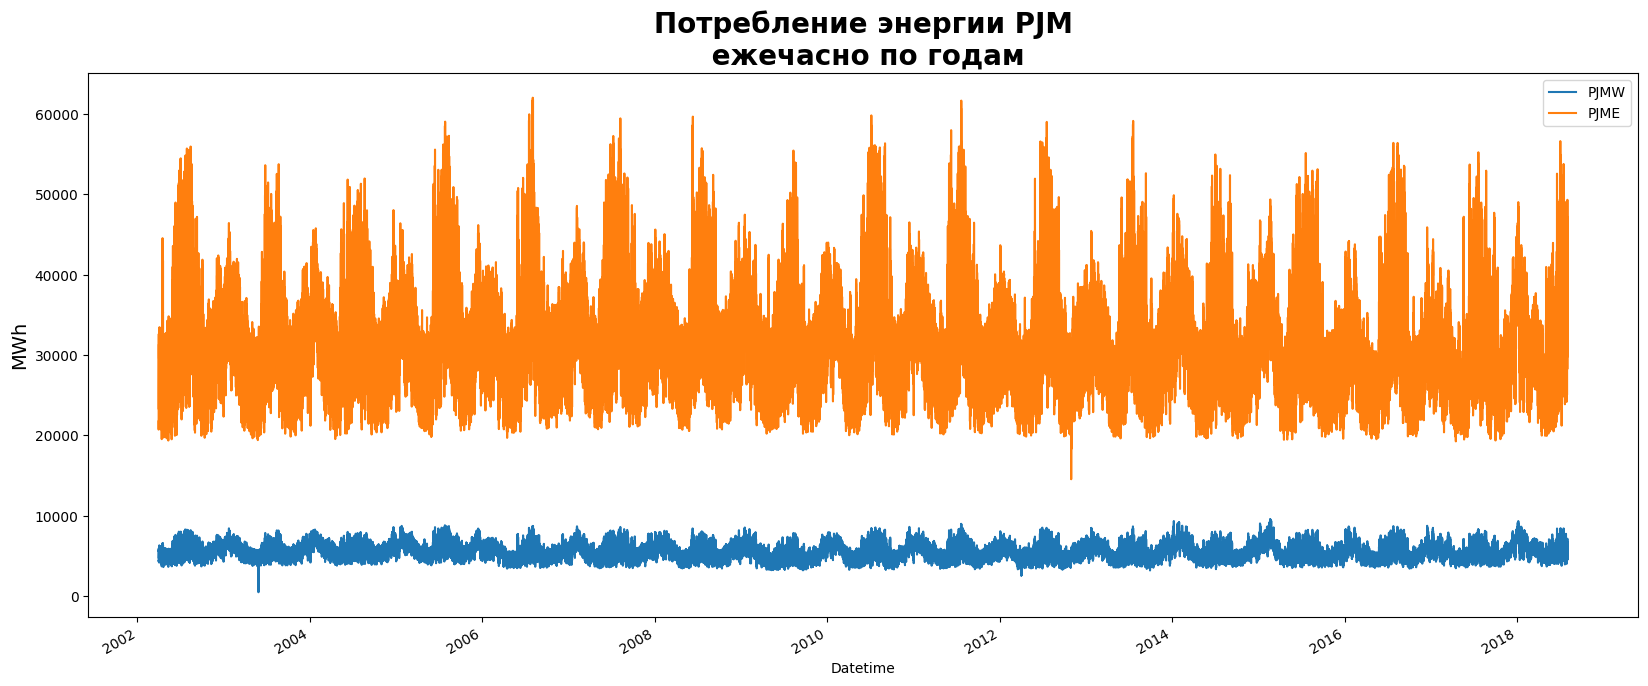

In [12]:
df.plot(figsize=(20,8))
plt.title('Потребление энергии PJM\n ежечасно по годам', weight='bold', fontsize=20);
plt.ylabel('MWh', fontsize=14); # ось ординат

> Предварительно, судя по графику, тренд отсутствует, ряд похож на стационарный.<br>
> Возможно есть сезонность, есть пики мощности, нужно уточнить дополнительно другими методами.<br>
> Чтобы лучше понять, попробуем сузить диапазон времени графика до одного года, например можно взять 2017 год.

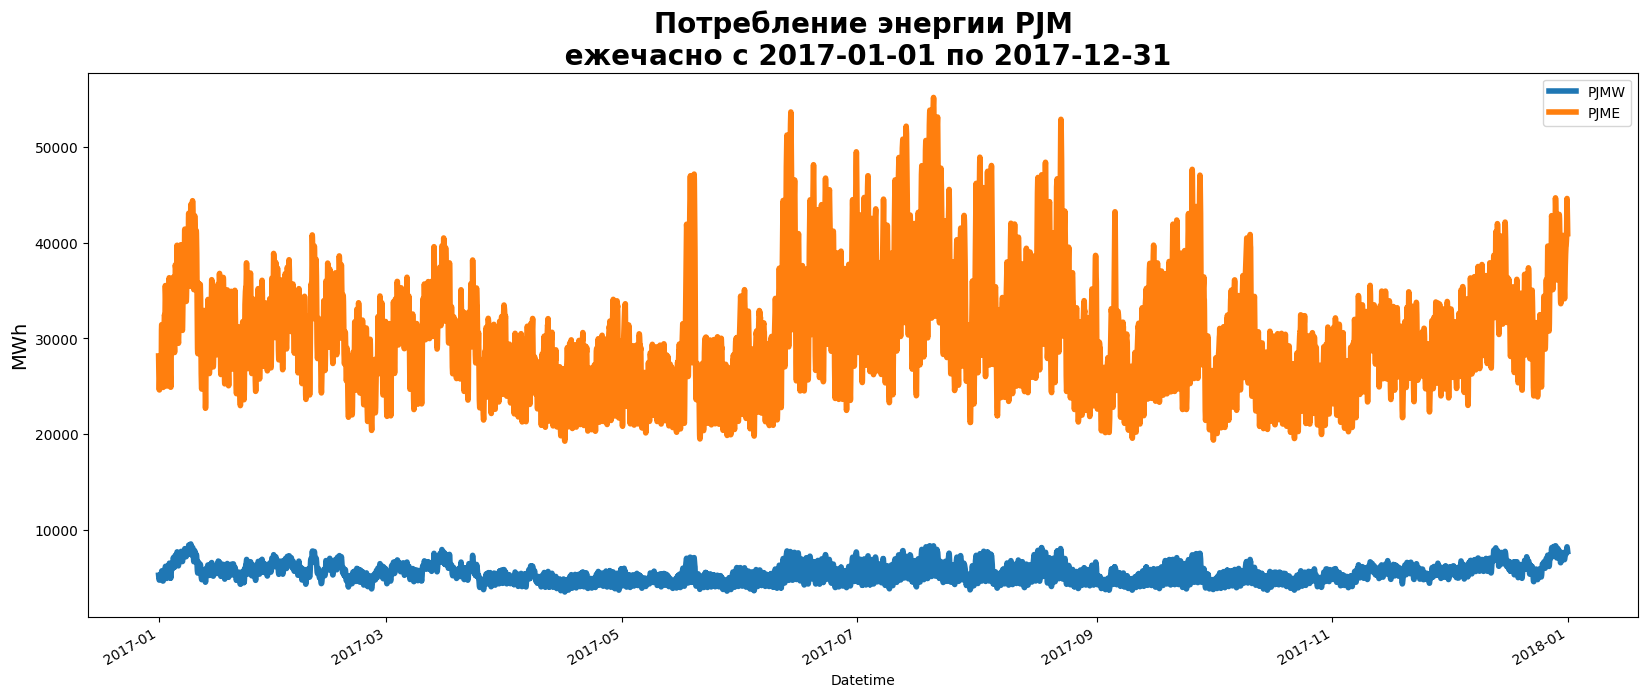

In [13]:
df_2017 = df[(df.index >= '2017-01-01') & (df.index < '2018-01-01')]

df_2017.plot(figsize=(20,8), lw=4)
plt.title('Потребление энергии PJM\n ежечасно c 2017-01-01 по 2017-12-31', weight='bold', fontsize=20);
plt.ylabel('MWh', fontsize=14); # ось ординат

> Уменьшение диапазона рассматриваемого времени не сильно помогло, нужно будет видимо перейти с ежечасных данных на ежедневные или еженедельные.

In [14]:
# Учитывая, что недостающих данных нет, мы можем выполнить повторную выборку данных до ежедневного уровня
daily_df = df.resample(rule='D').sum()

daily_df

PJMW      PJME
Datetime                      
2002-04-01  121237.0  637480.0
2002-04-02  127450.0  687613.0
2002-04-03  127822.0  681449.0
2002-04-04  136099.0  704041.0
2002-04-05  136467.0  718623.0
...              ...       ...
2018-07-30  131825.0  790978.0
2018-07-31  135858.0  828938.0
2018-08-01  143033.0  941539.0
2018-08-02  139321.0  950233.0
2018-08-03    5489.0   35486.0

[5969 rows x 2 columns]

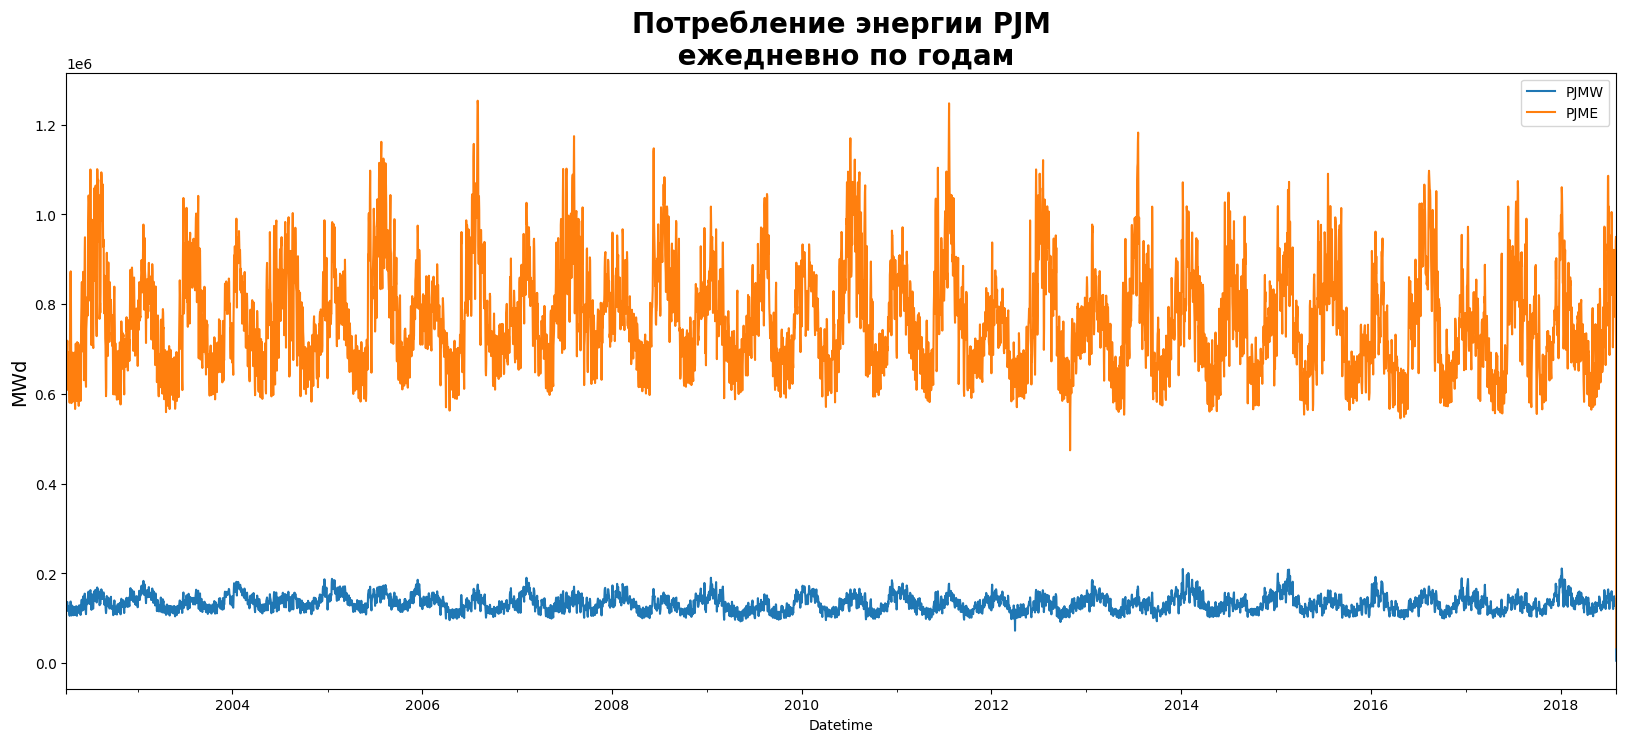

In [15]:
daily_df.plot(figsize=(20,8))
plt.title('Потребление энергии PJM\n ежедневно по годам', weight='bold', fontsize=20);
plt.ylabel('MWd', fontsize=14); # ось ординат

In [16]:
# Попробуем выполнить повторную выборку данных до ежедненедельно уровня
weekly_df = df.resample(rule='W').sum()

weekly_df

PJMW       PJME
Datetime                        
2002-04-07   894297.0  4704552.0
2002-04-14   837059.0  4566657.0
2002-04-21   882703.0  5289394.0
2002-04-28   848108.0  4589237.0
2002-05-05   837138.0  4524153.0
...               ...        ...
2018-07-08  1024096.0  6461277.0
2018-07-15  1032205.0  6118566.0
2018-07-22   987184.0  5982832.0
2018-07-29   985290.0  6145746.0
2018-08-05   555526.0  3547174.0

[853 rows x 2 columns]

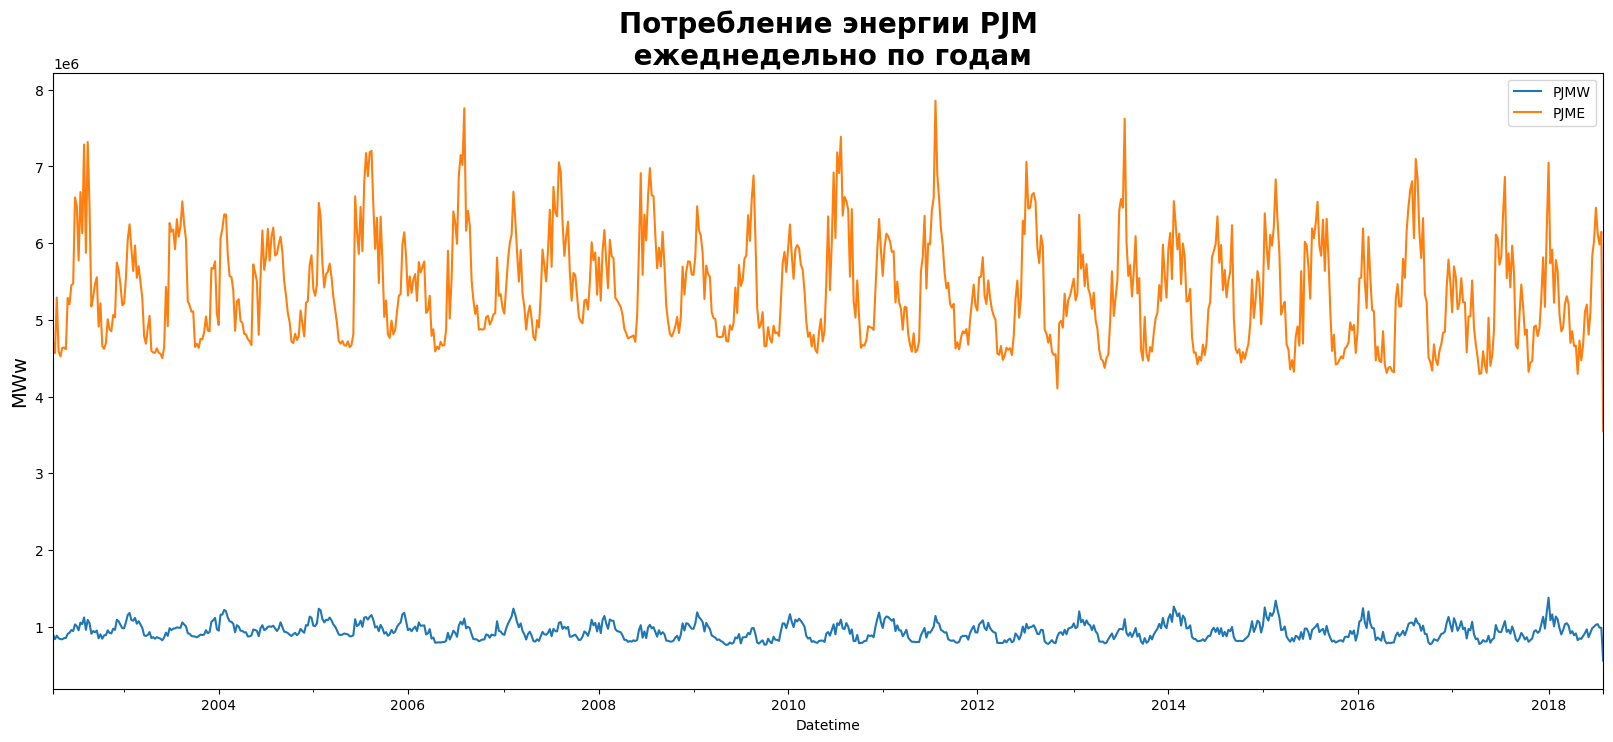

In [17]:
weekly_df.plot(figsize=(20,8))
plt.title('Потребление энергии PJM\n ежеднедельно по годам', weight='bold', fontsize=20);
plt.ylabel('MWw', fontsize=14); # ось ординат

>Сейчас видно, что у нас имеются сезонные пики мощности в конце/начале года и в середине года.

<a id="3.3">

### <b> 3.3 <span style='color:#FFAE42'> | </span> Графический анализ энергопотребления </b>

> Создадим функцию для поиска сезонных, месячных, будничных или почасовых данных.

In [18]:
def create_features(data):
    """
    Создает объекты временных рядов из индекса Datetime.
    
    """
    
    from pandas.api.types import CategoricalDtype

    cat_type = CategoricalDtype(categories=['Monday',
                                            'Tuesday',
                                            'Wednesday',
                                            'Thursday',
                                            'Friday',
                                            'Saturday',
                                            'Sunday'],
                                ordered=True)

    data = df.copy()
    data['Datetime'] = data.index
    data['hour'] = data['Datetime'].dt.hour
    data['weekday'] = data['Datetime'].dt.day_name().astype(cat_type)
    data['month'] = data['Datetime'].dt.month
    data['quarter'] = data['Datetime'].dt.quarter
    data['year'] = data['Datetime'].dt.year
    data['dayofmonth'] = data['Datetime'].dt.day
    data['weekofyear'] = data.index.isocalendar().week
    data['date_offset'] = (data.Datetime.dt.month*100 + data.Datetime.dt.day - 320)%1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    data = data.drop(columns='date_offset')
    data = data.set_index('Datetime')

    return data

df_ts = create_features(df)

In [19]:
df_ts

PJMW     PJME  hour   weekday  month  quarter  year  \
Datetime                                                                     
2002-04-01 01:00:00  4374.0  21734.0     1    Monday      4        2  2002   
2002-04-01 02:00:00  4306.0  20971.0     2    Monday      4        2  2002   
2002-04-01 03:00:00  4322.0  20721.0     3    Monday      4        2  2002   
2002-04-01 04:00:00  4359.0  20771.0     4    Monday      4        2  2002   
2002-04-01 05:00:00  4436.0  21334.0     5    Monday      4        2  2002   
...                     ...      ...   ...       ...    ...      ...   ...   
2018-08-02 20:00:00  6545.0  44057.0    20  Thursday      8        3  2018   
2018-08-02 21:00:00  6496.0  43256.0    21  Thursday      8        3  2018   
2018-08-02 22:00:00  6325.0  41552.0    22  Thursday      8        3  2018   
2018-08-02 23:00:00  5892.0  38500.0    23  Thursday      8        3  2018   
2018-08-03 00:00:00  5489.0  35486.0     0    Friday      8        3  2018   

                     dayofmonth  weekofyear  season  
Datetime                                             
2002-04-01 01:00:00           1          14  Spring  
2002-04-01 02:00:00           1          14  Spring  
2002-04-01 03:00:00           1          14  Spring  
2002-04-01 04:00:00           1          14  Spring  
2002-04-01 05:00:00           1          14  Spring  
...                         ...         ...     ...  
2018-08-02 20:00:00           2          31  Summer  
2018-08-02 21:00:00           2          31  Summer  
2018-08-02 22:00:00           2          31  Summer  
2018-08-02 23:00:00           2          31  Summer  
2018-08-03 00:00:00           3          31  Summer  

[143202 rows x 10 columns]

In [20]:
ts_curious = ['hour', 'weekday', 'month', 'quarter', 'year', 'dayofmonth', 'weekofyear', 'season']
ts_el = len(ts_curious)

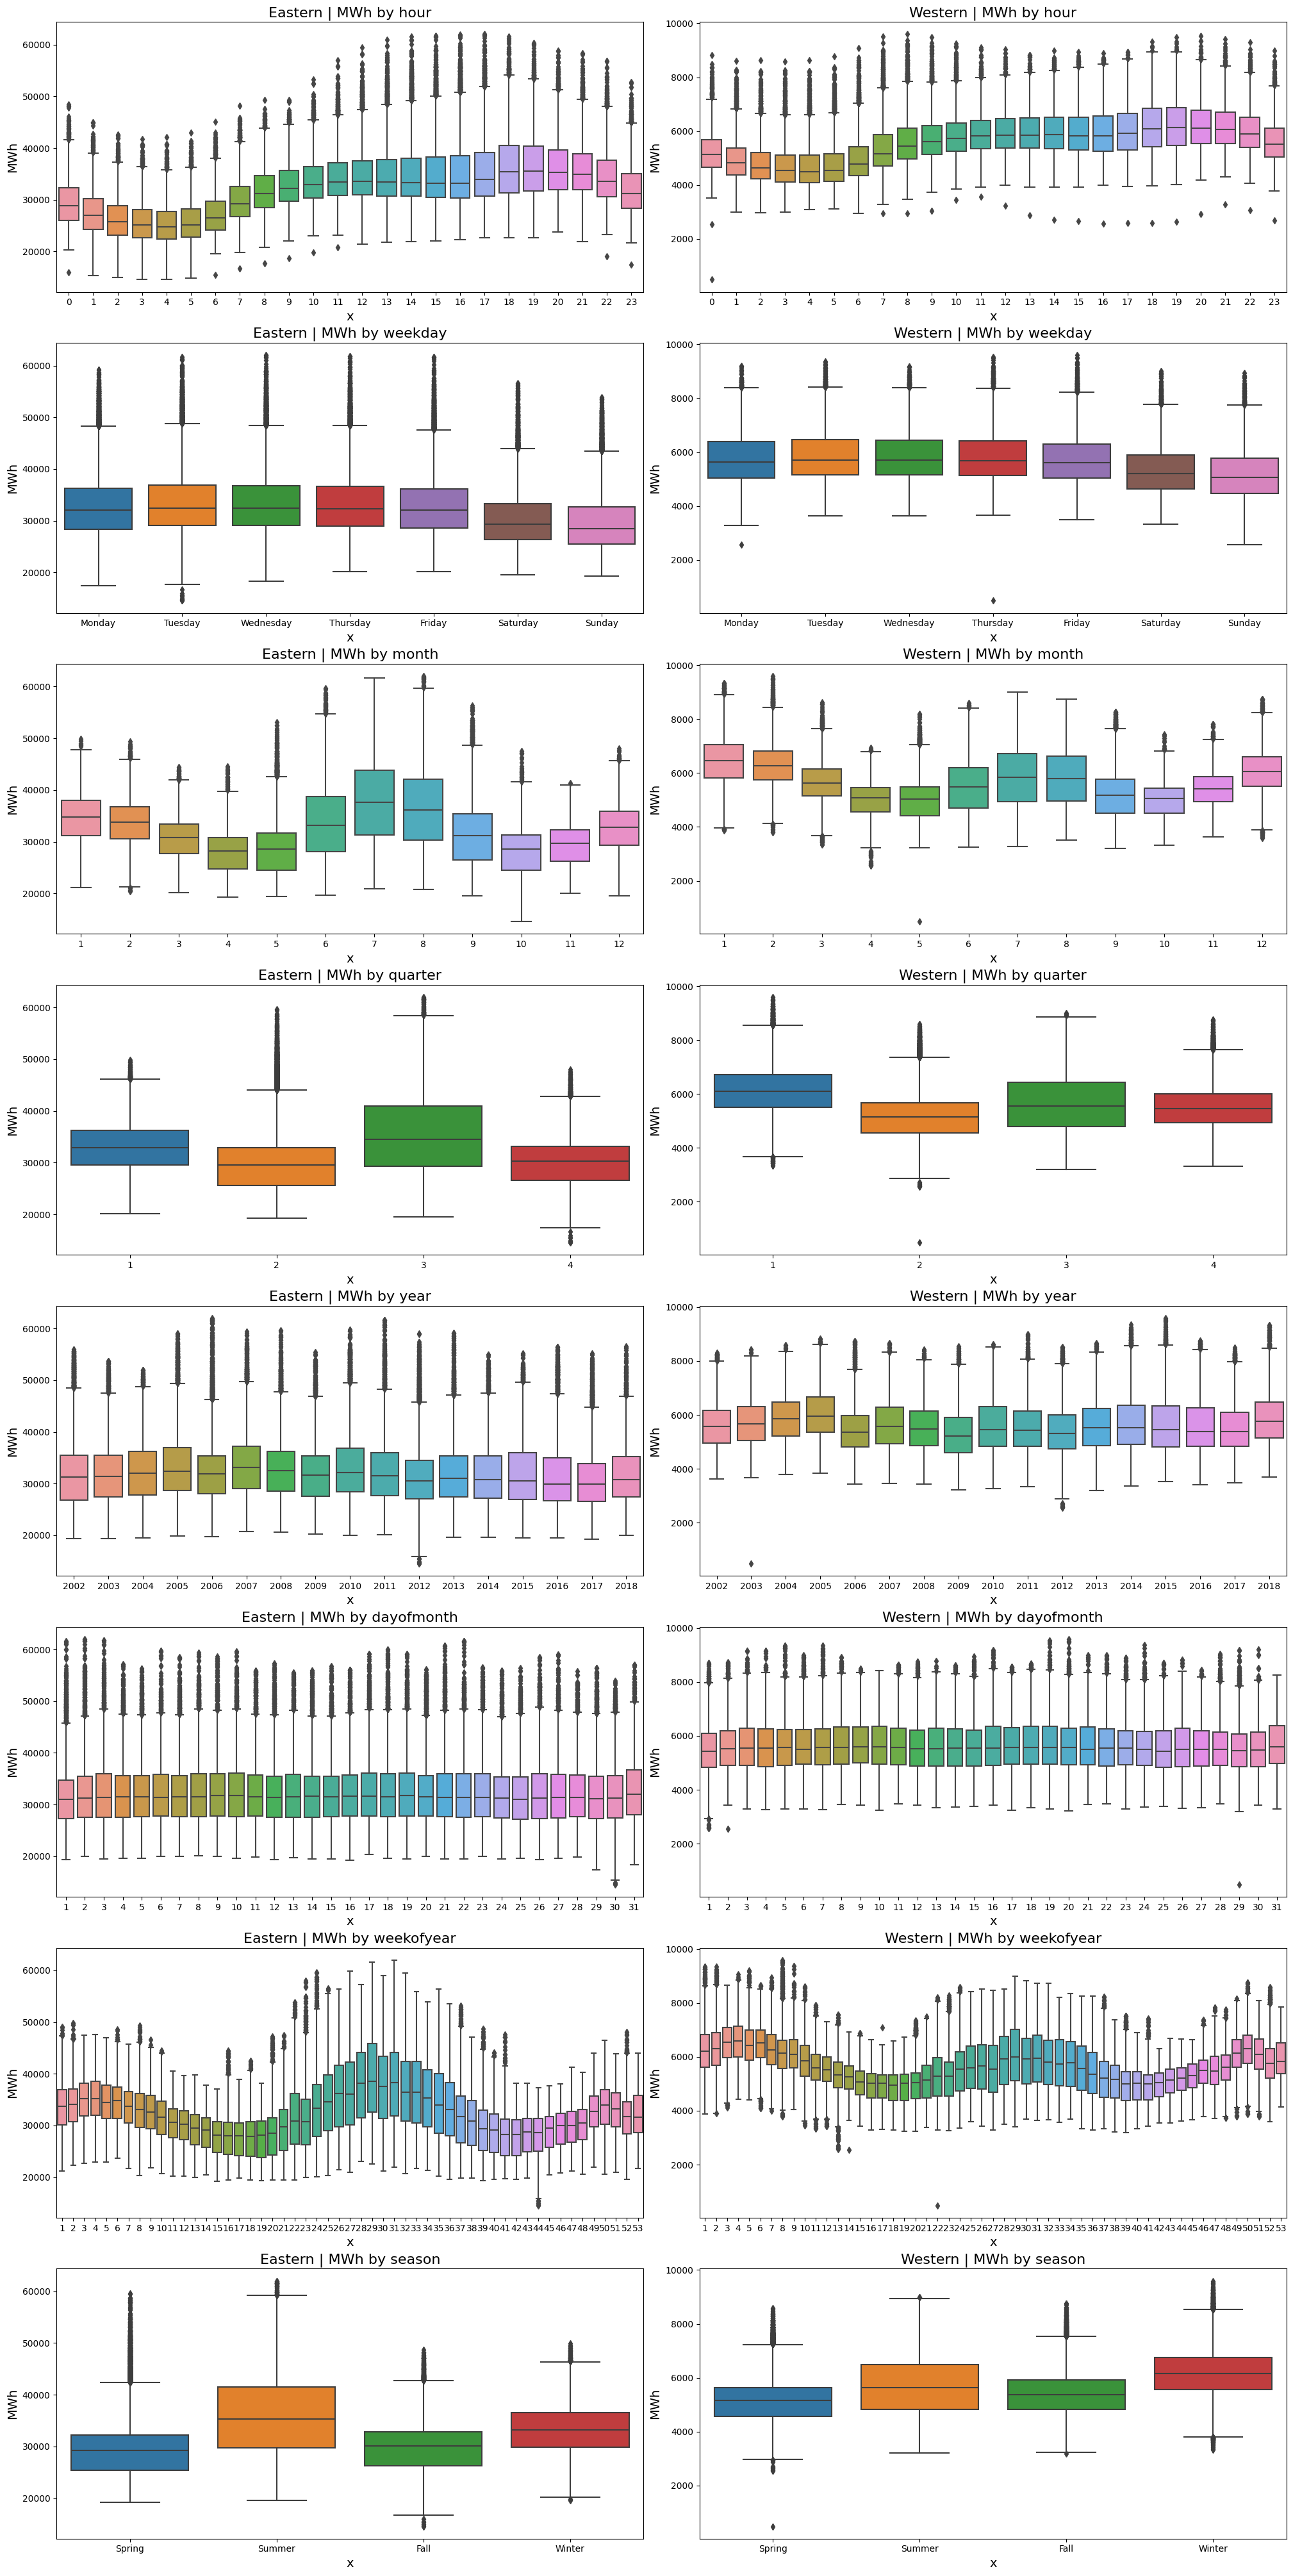

In [21]:
fig, ax = plt.subplots(nrows=ts_el, ncols=2, figsize=(20, 5*ts_el))

for i, ts in enumerate(ts_curious):
    sns.boxplot(data=df_ts, x=ts, y='PJME', ax=ax[i, 0])
    ax[i, 0].set_title(f'Eastern | MWh by {ts}', fontsize=16)
    ax[i, 0].set_xlabel('x', fontsize=14)
    ax[i, 0].set_ylabel('MWh', fontsize=14)

    sns.boxplot(data=df_ts, x=ts, y='PJMW', ax=ax[i, 1])
    ax[i, 1].set_title(f'Western | MWh by {ts}', fontsize=16)
    ax[i, 1].set_xlabel('x', fontsize=14)
    ax[i, 1].set_ylabel('MWh', fontsize=14)
    
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.show();

<a id="3.4">

### <b> 3.4 <span style='color:#FFAE42'> | </span> Графический анализ энергопотребления с учётом времени года </b>

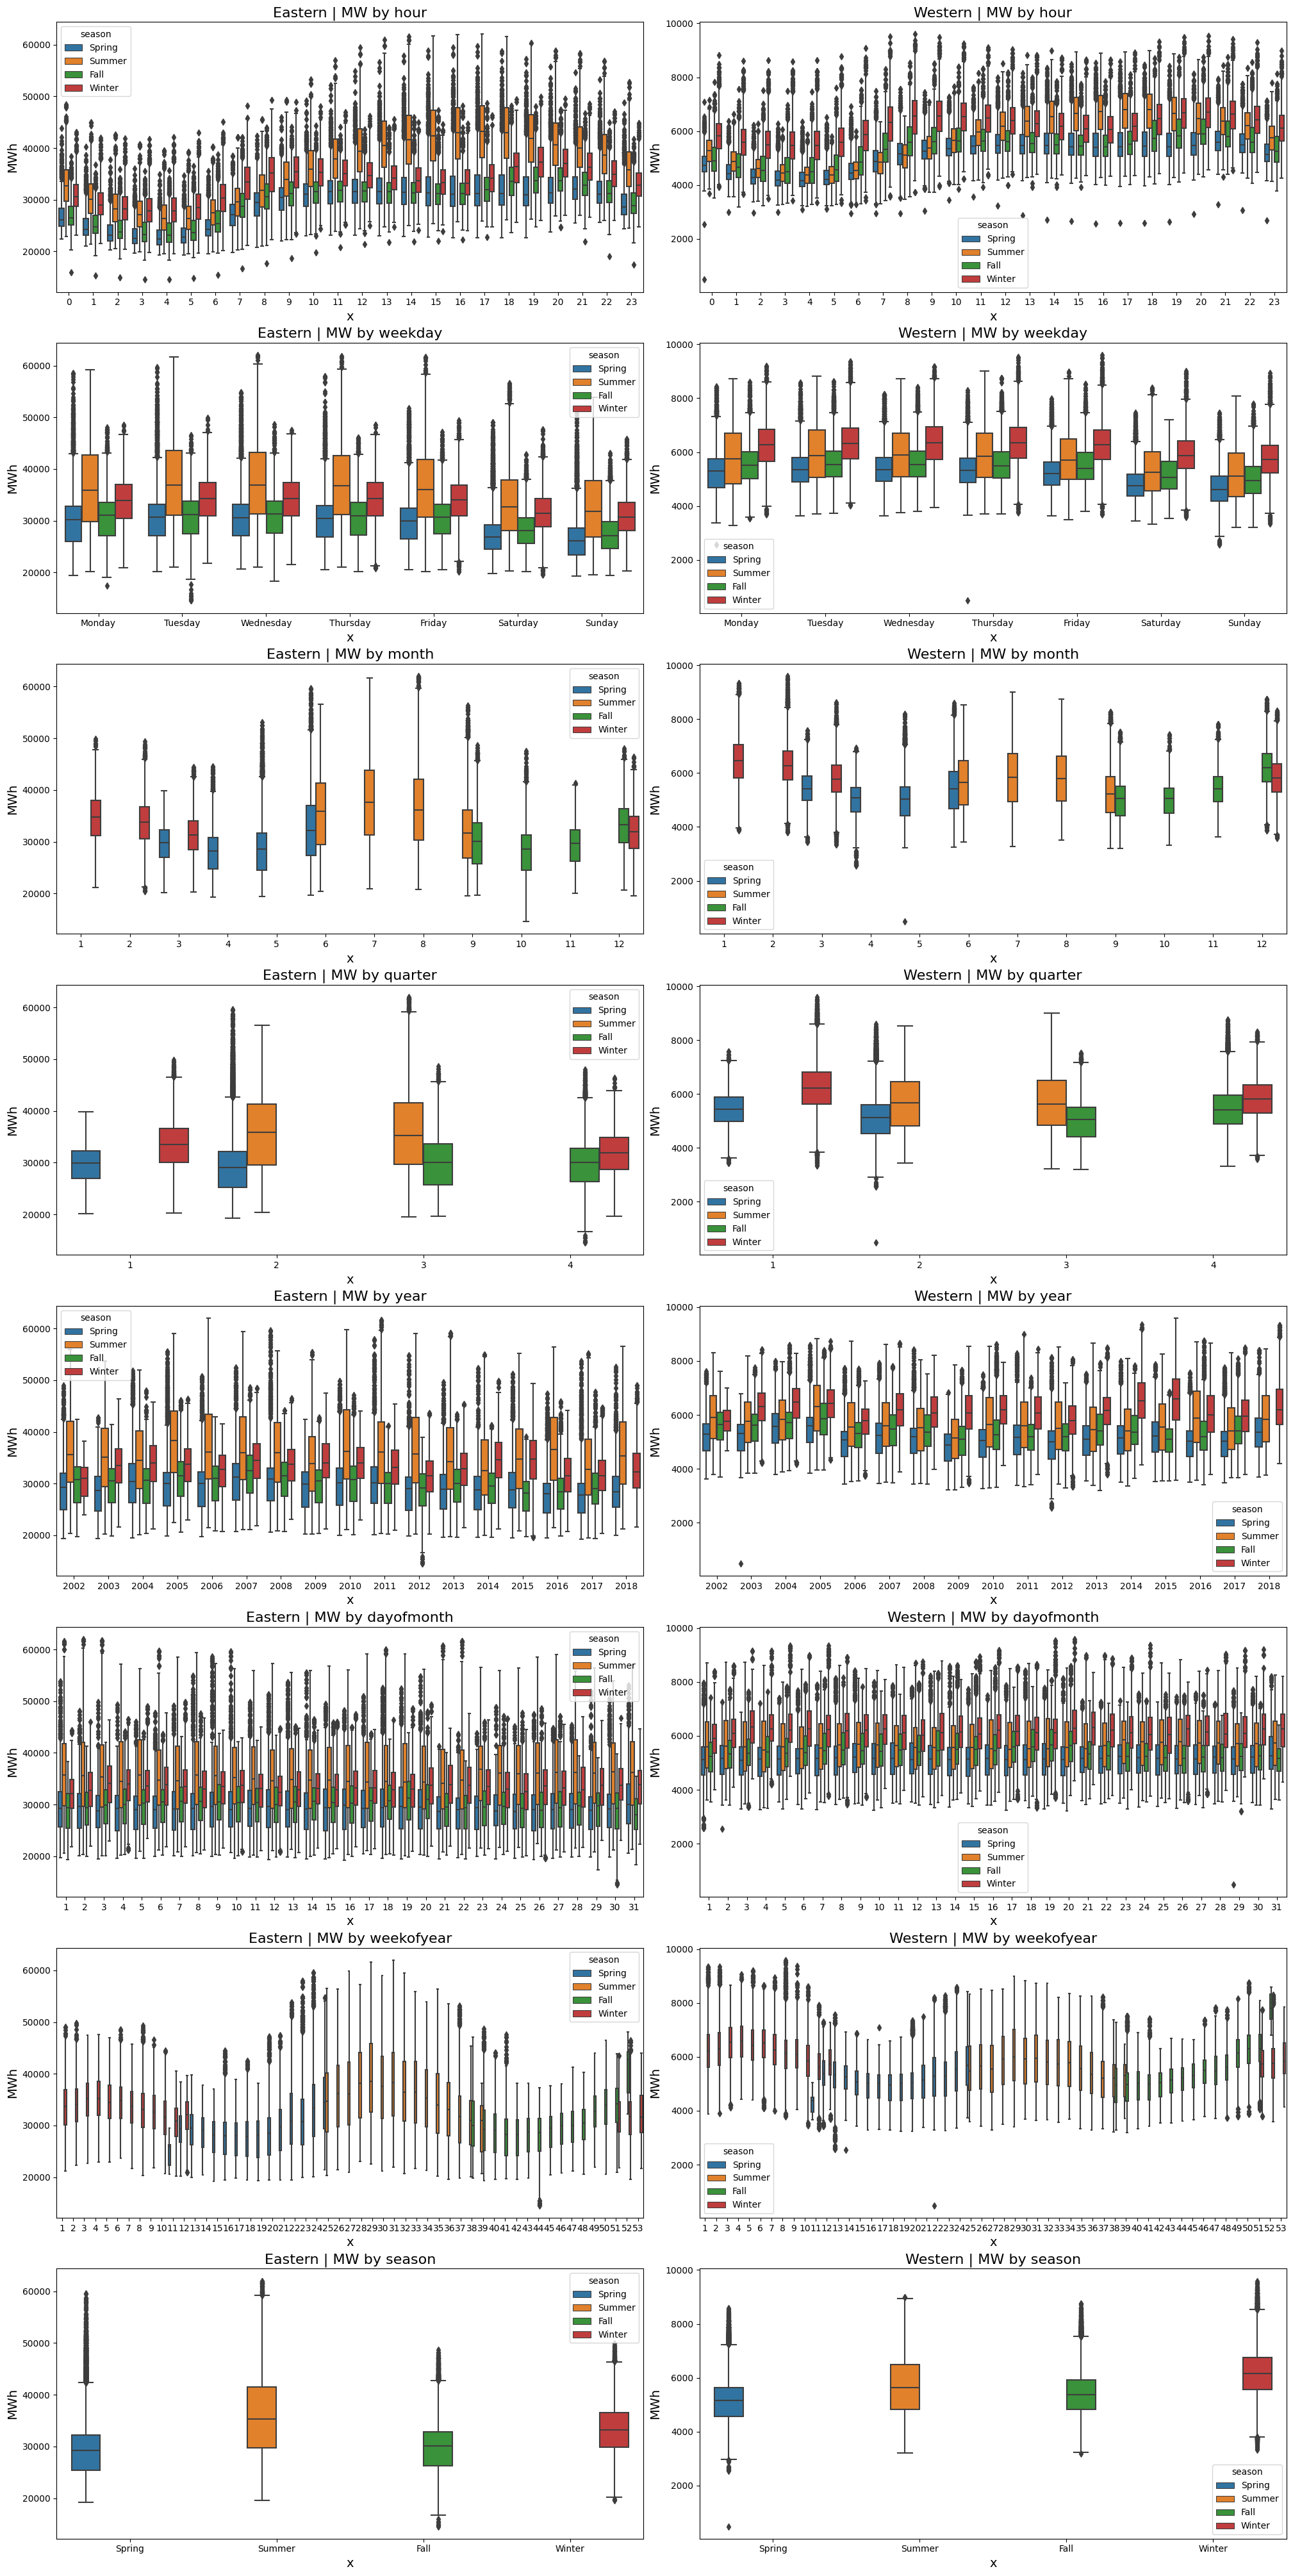

In [22]:
fig, ax = plt.subplots(nrows=ts_el, ncols=2, figsize=(20, 5*ts_el))

for i, ts in enumerate(ts_curious):
    sns.boxplot(data=df_ts, x=ts, y='PJME', hue='season', ax=ax[i, 0])
    ax[i, 0].set_title(f'Eastern | MW by {ts}', fontsize=16)
    ax[i, 0].set_xlabel('x', fontsize=14)
    ax[i, 0].set_ylabel('MWh', fontsize=14)

    sns.boxplot(data=df_ts, x=ts, y='PJMW', hue='season', ax=ax[i, 1])
    ax[i, 1].set_title(f'Western | MW by {ts}', fontsize=16)
    ax[i, 1].set_xlabel('x', fontsize=14)
    ax[i, 1].set_ylabel('MWh', fontsize=14)
    
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.show();

<a id="3.5">

### <b> 3.5 <span style='color:#FFAE42'> | </span> Анализ на гистограммах по временам года </b>


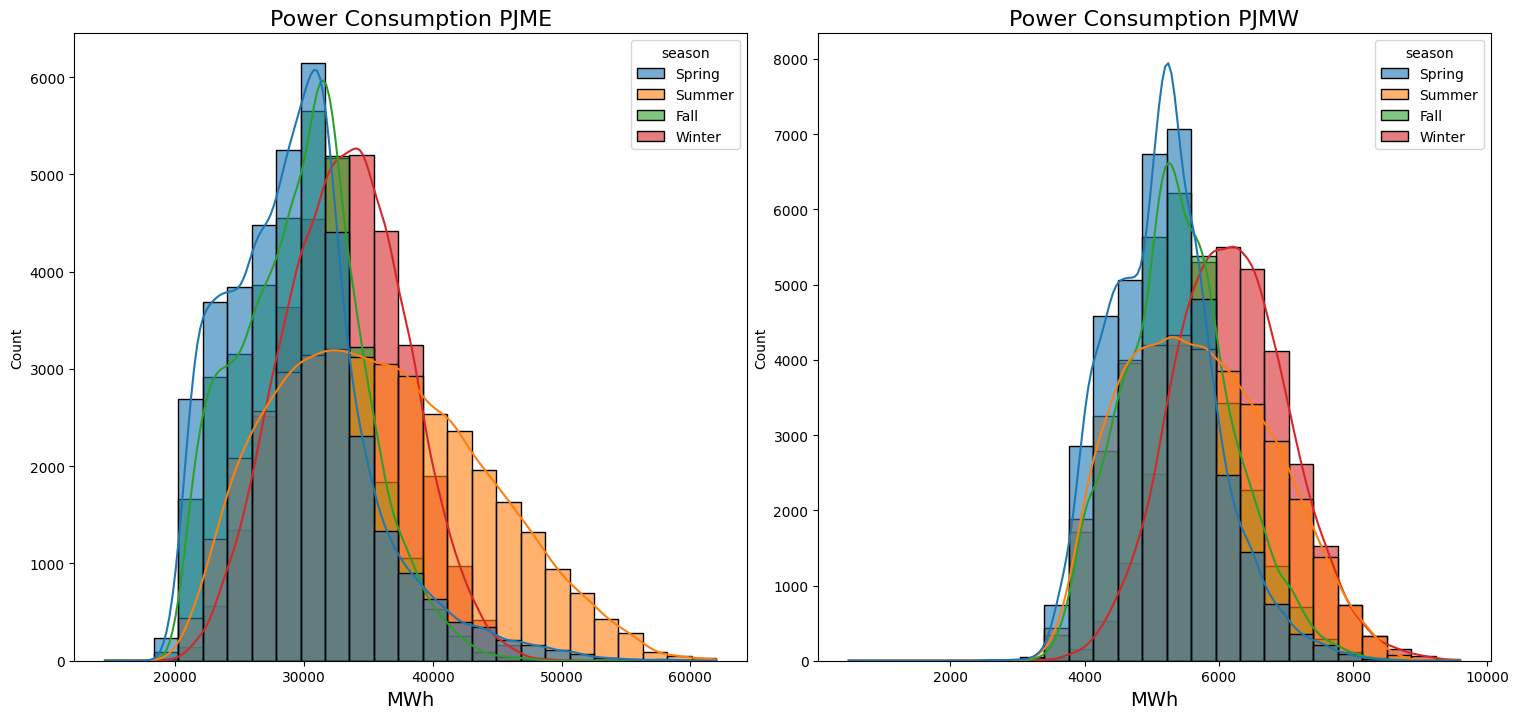

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

for i, reg in enumerate(['PJME','PJMW']):
    sns.histplot(df_ts[['PJME','PJMW','year','season']], 
                 x=reg,
                 kde=True,
                 bins=25,
                 hue='season',
                 palette='tab10',
                 alpha=0.6,
                 ax=ax[i])
    ax[i].set_title('Power Consumption ' + reg, fontsize=16)
    ax[i].set_xlabel('MWh', fontsize=14)
    
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.show();

> Восточный энергорегион *(PJME)* обладает более высоким энергопотреблением, чем западный *(PJMW)*.<br>
> В среднесуточном потреблении: дневной пик приходится примерно на 5-8 часов вечера, а спад - на 2-4 часа ночи.<br>
> В средненедельном потреблении: пик приходится на будние дни, а спад - на выходные.<br>
> Самое высокое потребление энергии за год приходится либо на конец/начало года (новогодние праздники), либо на середину года (жаркий период года, отпуска).

***

<a id="4">

## <b> 4 <span style='color:#FFAE42'> | </span> СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАННЫХ </b>

<a id="4.1">

### <b> 4.1 <span style='color:#FFAE42'> | </span> Сезонная декомпозиция </b>

> Данные временных рядов можно рассматривать как компоненты собранные вместе, то есть: <br>
**Данные = Уровень + Тренд + Сезонность + Шум**
* **Уровень**: среднее значение в серии.
* **Тренд**: увеличивающееся или уменьшающееся значение в ряду.
* **Сезонность**: повторяющийся краткосрочный цикл в серии.
* **Шум/остаточное значение**: случайное изменение в серии.

> Используя библиотеку *Python statsmodels*, вышеуказанные компоненты могут быть "разложены" (т.е. выполнена сезонная декомпозиция). Сезонность может быть аддитивная или мультипликативная.

>Если модель с учетом мультипликативной сезонности демонстрирует более низкие значения метрик, такие как *MSE (Mean Squared Error)*, *MAE (Mean Absolute Error)* или *MAPE (Mean Absolute Percentage Error)*, по сравнению с моделью без сезонности или с учетом аддитивной сезонности, то можно предположить, что тип сезонности мультипликативный. Аналогично, если модель с учетом аддитивной сезонности демонстрирует более низкие значения метрик, то можно предположить, что тип сезонности аддитивный.<br>
Образец для расчёта взят здесь: 
[Аддитивная или мультипликативная сезонность](https://qaa-engineer.ru/kak-vy-obnaruzhivaete-sezonnost-multiplikativnuyu-ili-additivnuyu-v-dannyh-vremennogo-ryada/)

In [24]:
# Построим модель прогнозирования временного ряда с учетом аддитивной или мультипликативной сезонности и сравним
# метрики оценки качества модели. Для начала возьмём восточный энергорегион.
 
# Метрики качества модели
model_add = sm.tsa.ExponentialSmoothing(df['PJME'], seasonal='add', seasonal_periods=12)
model_add_fit = model_add.fit()
mape_add = model_add_fit.fittedvalues.sub(df['PJME']).div(df['PJME']).abs().mean()
mae_add = model_add_fit.fittedvalues.sub(df['PJME']).abs().mean()
mse_add = model_add_fit.fittedvalues.sub(df['PJME']).pow(2).mean()
 
model_mul = sm.tsa.ExponentialSmoothing(df['PJME'], seasonal='mul', seasonal_periods=12)
model_mul_fit = model_mul.fit()
mape_mul = model_mul_fit.fittedvalues.sub(df['PJME']).div(df['PJME']).abs().mean()
mae_mul = model_mul_fit.fittedvalues.sub(df['PJME']).abs().mean()
mse_mul = model_mul_fit.fittedvalues.sub(df['PJME']).pow(2).mean()
 
print(
    '\nMAPE PJME с учетом аддитивной сезонности:', round(mape_add, 3),
    '\nMAPE PJME с учетом мультипликативной сезонности:', round(mape_mul, 3),
    '\nMAE PJME с учетом аддитивной сезонности:', round(mae_add, 3),
    '\nMAE PJME с учетом мультипликативной сезонности:', round(mae_mul, 3),
    '\nRMSE PJME с учетом аддитивной сезонности:', round(np.sqrt(mse_add), 3),
    '\nRMSE PJME с учетом мультипликативной сезонности:', round(np.sqrt(mse_mul), 3)
    )


MAPE PJME с учетом аддитивной сезонности: 0.03 
MAPE PJME с учетом мультипликативной сезонности: 0.031 
MAE PJME с учетом аддитивной сезонности: 978.463 
MAE PJME с учетом мультипликативной сезонности: 1021.296 
RMSE PJME с учетом аддитивной сезонности: 1249.161 
RMSE PJME с учетом мультипликативной сезонности: 1325.037


In [25]:
# Построим модель прогнозирования временного ряда с учетом аддитивной или мультипликативной сезонности и сравним
# метрики оценки качества модели. Теперь возьмём западный энергорегион.
 
# Метрики качества модели
model_add = sm.tsa.ExponentialSmoothing(df['PJMW'], seasonal='add', seasonal_periods=12)
model_add_fit = model_add.fit()
mape_add = model_add_fit.fittedvalues.sub(df['PJMW']).div(df['PJMW']).abs().mean()
mae_add = model_add_fit.fittedvalues.sub(df['PJMW']).abs().mean()
mse_add = model_add_fit.fittedvalues.sub(df['PJMW']).pow(2).mean()
 
model_mul = sm.tsa.ExponentialSmoothing(df['PJMW'], seasonal='mul', seasonal_periods=12)
model_mul_fit = model_mul.fit()
mape_mul = model_mul_fit.fittedvalues.sub(df['PJMW']).div(df['PJMW']).abs().mean()
mae_mul = model_mul_fit.fittedvalues.sub(df['PJMW']).abs().mean()
mse_mul = model_mul_fit.fittedvalues.sub(df['PJMW']).pow(2).mean()
 
print(
    '\nMAPE PJMW с учетом аддитивной сезонности:', round(mape_add, 3),
    '\nMAPE PJMW с учетом мультипликативной сезонности:', round(mape_mul, 3),
    '\nMAE PJMW с учетом аддитивной сезонности:', round(mae_add, 3),
    '\nMAE PJMW с учетом мультипликативной сезонности:', round(mae_mul, 3),
    '\nRMSE PJMW с учетом аддитивной сезонности:', round(np.sqrt(mse_add), 3),
    '\nRMSE PJMW с учетом мультипликативной сезонности:', round(np.sqrt(mse_mul), 3)
    )


MAPE PJMW с учетом аддитивной сезонности: 0.026 
MAPE PJMW с учетом мультипликативной сезонности: 0.027 
MAE PJMW с учетом аддитивной сезонности: 143.535 
MAE PJMW с учетом мультипликативной сезонности: 150.324 
RMSE PJMW с учетом аддитивной сезонности: 185.961 
RMSE PJMW с учетом мультипликативной сезонности: 194.703


> Видим, что значения всех метрик для аддитивной сезонности меньше, чем для мультипликативной.<br>
> Значит можем применить аддитивную модель для расчёта сезонной декомпозиции.

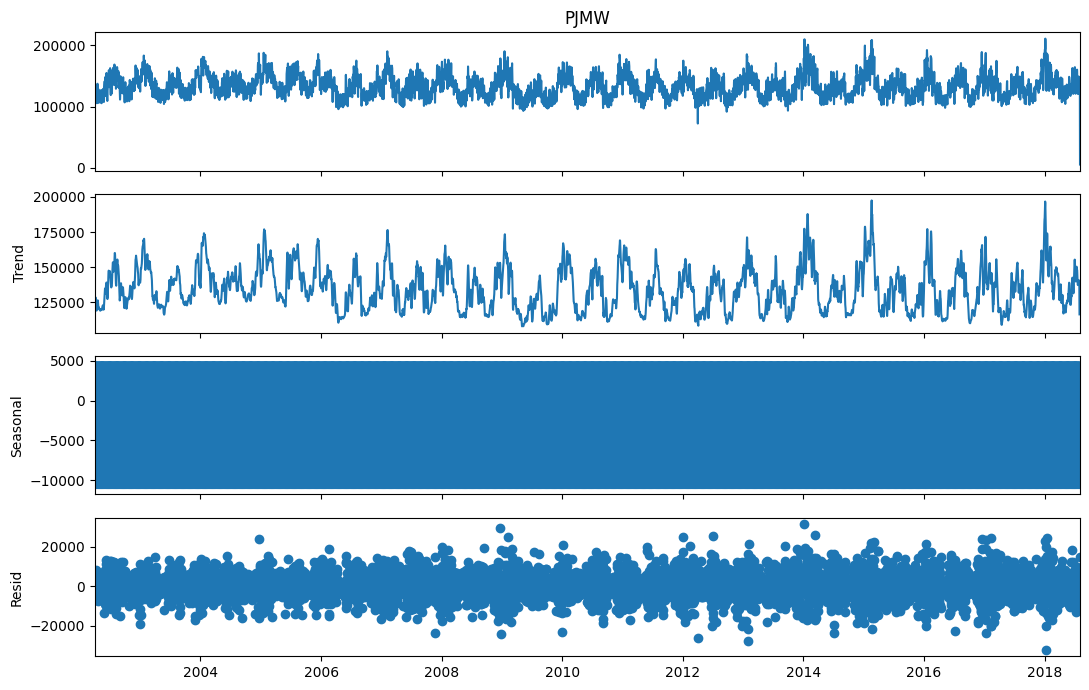

In [26]:
# Построим сезонную декомпозицию для западного энергорегиона
# Агрегируем до дневного уровня
daily_df_w = daily_df['PJMW']
decomposition = seasonal_decompose(daily_df_w, model='additive')

fig = decomposition.plot()
#fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

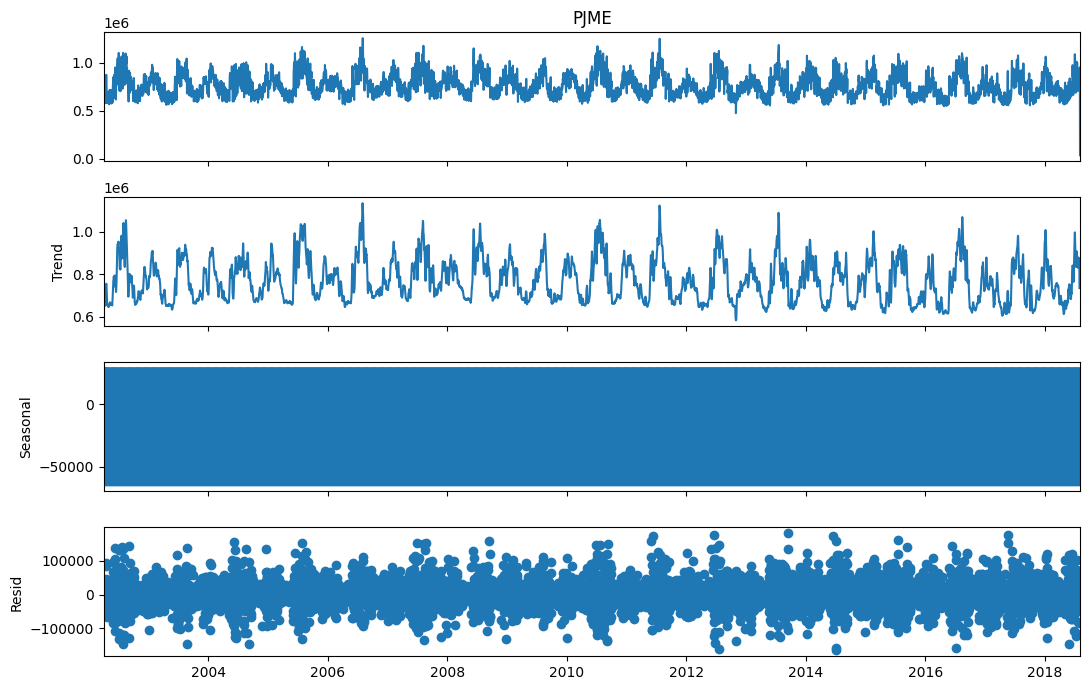

In [27]:
# Построим сезонную декомпозицию для восточного энергорегиона
# Агрегируем до дневного уровня
daily_df_e = daily_df['PJME']
decomposition = seasonal_decompose(daily_df_e, model='additive')

fig = decomposition.plot()
#fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

> Очень трудно понять, что происходит, поскольку график очень "упакован".

> Для правильной работы более "традиционных" эконометрических/статистических моделей, таких как *Holt winters* и *ARIMA*, требуются 3 характеристики, а именно:
* Сезонность: набор данных носит циклический характер.
* Стационарность: свойства набора данных не меняются с течением времени.
* Автокорреляция: существует сходство между текущими и прошлыми (т.е. "запаздывающими") точками данных.

> Попробуем увеличить количество до недельного уровня, чтобы уменьшить шум.

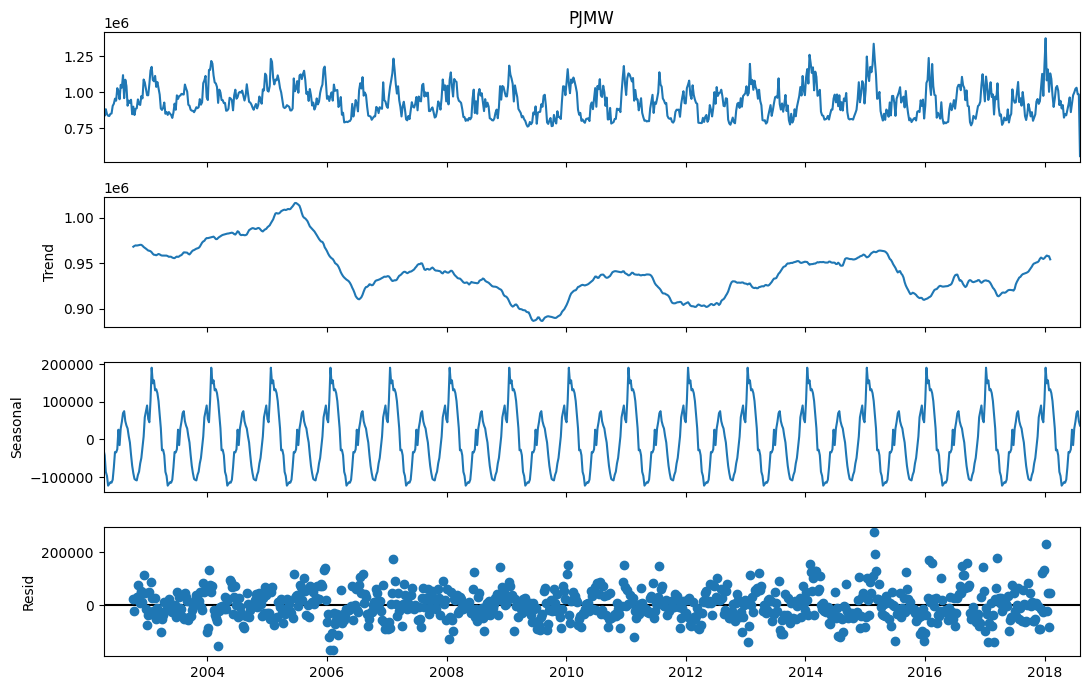

In [28]:
# Построим сезонную декомпозицию для западного энергорегиона
# Агрегируем до недельного уровня
weekly_df_w = weekly_df['PJMW']
decomposition = seasonal_decompose(weekly_df_w, model='additive') 

fig = decomposition.plot()
#fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

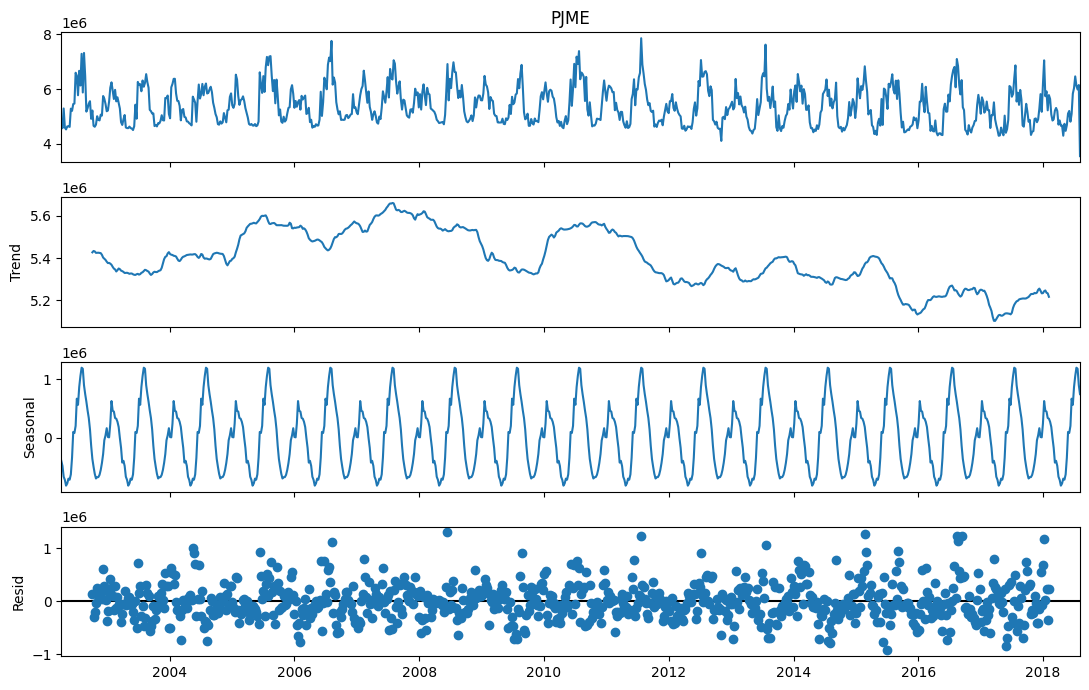

In [29]:
# Построим сезонную декомпозицию для восточного энергорегиона
# Агрегируем до недельного уровня
weekly_df_e = weekly_df['PJME']
decomposition = seasonal_decompose(weekly_df_e, model='additive') 

fig = decomposition.plot()
#fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

> Мы видим, что начинает прослеживаться закономерность - пики и спады потребления электроэнергии кажутся очень сезонными и повторяющимися. Это имеет смысл, учитывая часы работы офиса, погодные условия, праздничные дни для покупок и т.д.<br>
> Кроме того, можно видеть, что тенденция данных, по-видимому, снижается в течение последних нескольких лет.

<a id="4.2">

### <b> 4.2 <span style='color:#FFAE42'> | </span> Стационарность и гетероскедастичность </b>

>Проверим стационарность данных выработки энергии. Для начала рассчитаем скользящее среднее значение за 30 дней.

> Проверим временной ряд на стационарность расширенным тестом Дики — Фуллера. В тесте формулируется две гипотезы:
- нулевая гипотеза *(H0)*: временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;
- альтернативная гипотеза *(H1)*: временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.

> В результате проведения теста мы получим несколько значений: значение статистики из теста и критические значения разных уровней значимости (1 %, 5 %, 10 %). Уровень значимости означает допустимую  для данной задачи вероятность ошибки, то есть чем ниже уровень значимости, тем ниже вероятность ошибочного результата теста.
- Если значение статистики ниже критического значения выбранного уровня значимости, отвергаем гипотезу *H0* и принимаем гипотезу *H1* (ряд стационарный).
- Если значение статистики выше критического значения выбранного уровня значимости, принимаем гипотезу *H0* (ряд нестационарный).

In [30]:
# Проверим временной ряд на стационарность восточного энергорегиона.
data_east = df['PJME']
data_east = pd.DataFrame(data_east)
result = adfuller(data_east.values)

print('ADF Statistic: {:.3f}'.format(result[0]))
print('P-value: {:.15f}'.format(result[1]))
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

if result[0] > result[4]['5%']:
	print ('Восточный энергорегион - ряд нестационарный')
else:
	print ('Восточный энергорегион - ряд стационарный')

ADF Statistic: -20.219
P-value: 0.000000000000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Восточный энергорегион - ряд стационарный


In [31]:
# Проверим временной ряд на стационарность западного энергорегиона.
data_west = df['PJMW']
data_west = pd.DataFrame(data_west)
result = adfuller(data_west.values)

print('ADF Statistic: {:.3f}'.format(result[0]))
print('P-value: {:.15f}'.format(result[1]))
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

if result[0] > result[4]['5%']:
	print ('Западный энергорегион - ряд нестационарный')
else:
	print ('Западный энергорегион - ряд стационарный')

ADF Statistic: -19.887
P-value: 0.000000000000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Западный энергорегион - ряд стационарный


> Видим, что как для восточного, так и для западного энергорегионов, значение статистики ниже критического значения выбранного уровня значимости (5%), отвергаем гипотезу *H0* и принимаем гипотезу *H1* (ряды стационарные).

> Гетероскедантичность это неоднородность наблюдений, выражающаяся в неодинаковой дисперсии.

> Гетероскедастические данные означают, что пики и спады (т.е. выбросы) наблюдаются намного чаще, чем в "нормально распределенном" наборе данных. Это означает, что модели будет трудно предсказать эти всплески.

> Чтобы смягчить это, гетероскедастические данные, как правило, должны быть преобразованы по методу Бокса-Кокса / логарифма, чтобы ослабить экстремальные пики /впадины. То есть сближение данных, чтобы модель могла лучше соответствовать всем данным и достигать пиков / впадин.

In [32]:
data = daily_df.copy()

data['Time_Period'] = range(1, len(data)+1) 

formula_e = 'PJME ~ Time_Period' 
formula_w = 'PJMW ~ Time_Period'

model_e = ols(formula_e, data).fit()
model_w = ols(formula_w, data).fit()

result_e = BP(model_e.resid, model_e.model.exog)
result_w = BP(model_w.resid, model_w.model.exog)

print('ADF Statistic: {:.3f}'.format(result_e[0]))
print('P-value: {:.5f}'.format(result_e[1]))
print ('Critical values: {:.5f}'.format(result_e[3]))

if result_e[0] > result_e[3]:
	print ('Восточный энергорегион - ряд гомоскедастичный')
else:
	print ('Восточного энергорегион - ряд гетероскедастичный')

print('-----'*20)

print('ADF Statistic: {:.3f}'.format(result_w[0]))
print('P-value: {:.10f}'.format(result_w[1]))
print ('Critical values: {:.10f}'.format(result_w[3]))

if result_e[0] > result_w[3]:
	print ('Западный энергорегион - ряд гомоскедастичный')
else:
	print ('Западный энергорегион - ряд гетероскедастичный')

ADF Statistic: 1.169
P-value: 0.27964
Critical values: 0.27972
Восточный энергорегион - ряд гомоскедастичный
----------------------------------------------------------------------------------------------------
ADF Statistic: 35.885
P-value: 0.0000000021
Critical values: 0.0000000020
Западный энергорегион - ряд гомоскедастичный


> В нашем случае мы получили приведенные выше результаты, что означает:
* Данные как восточного, так и западного энергорегионов являются **стационарными** (поскольку значение `P` было ниже `0.05`)
* Данные как восточного, так и западного энергорегионов являются являются **гомоскедастичными** (поскольку значение `P` было ниже `0.05`)

<a id="4.3">

### <b> 4.3 <span style='color:#FFAE42'> | </span> Автокорреляция и частичная автокорреляция</b>

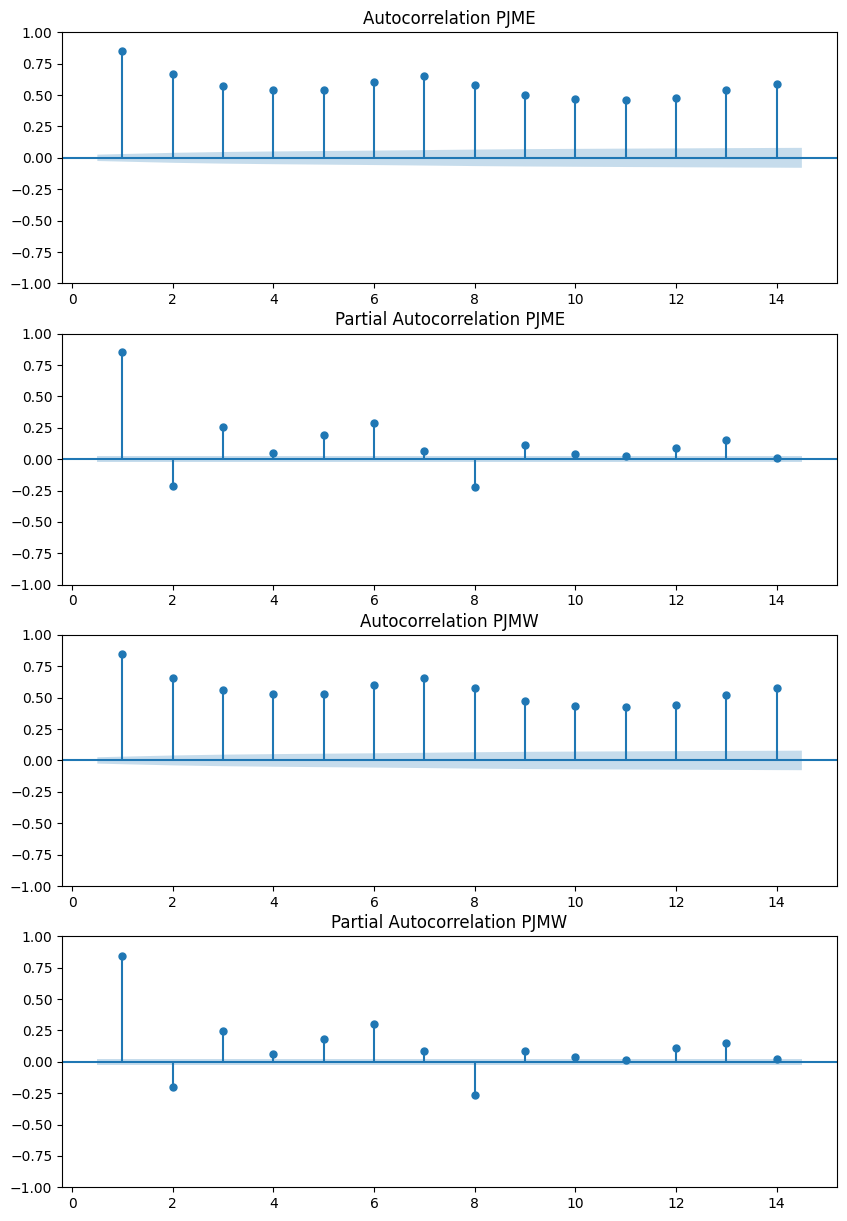

In [33]:
data_e = daily_df['PJME'].copy()
data_w = daily_df['PJMW'].copy()

fig, ax = plt.subplots(figsize=(10,15), nrows = 4, ncols = 1)

ax[0] = plot_acf(data_e, title = "Autocorrelation PJME", lags=14, zero=False, ax=ax[0])
ax[1] = plot_pacf(data_e, title = "Partial Autocorrelation PJME", lags=14, zero=False, ax=ax[1])
ax[2] = plot_acf(data_w, title = "Autocorrelation PJMW", lags=14, zero=False, ax=ax[2])
ax[3] = plot_pacf(data_w, title = "Partial Autocorrelation PJMW", lags=14, zero=False, ax=ax[3])

plt.show();

>Здесь, предварительно, мы видим, что: p=4, d=0, q=1, m=7. Далее мы ещё уточним эти коэффициенты.

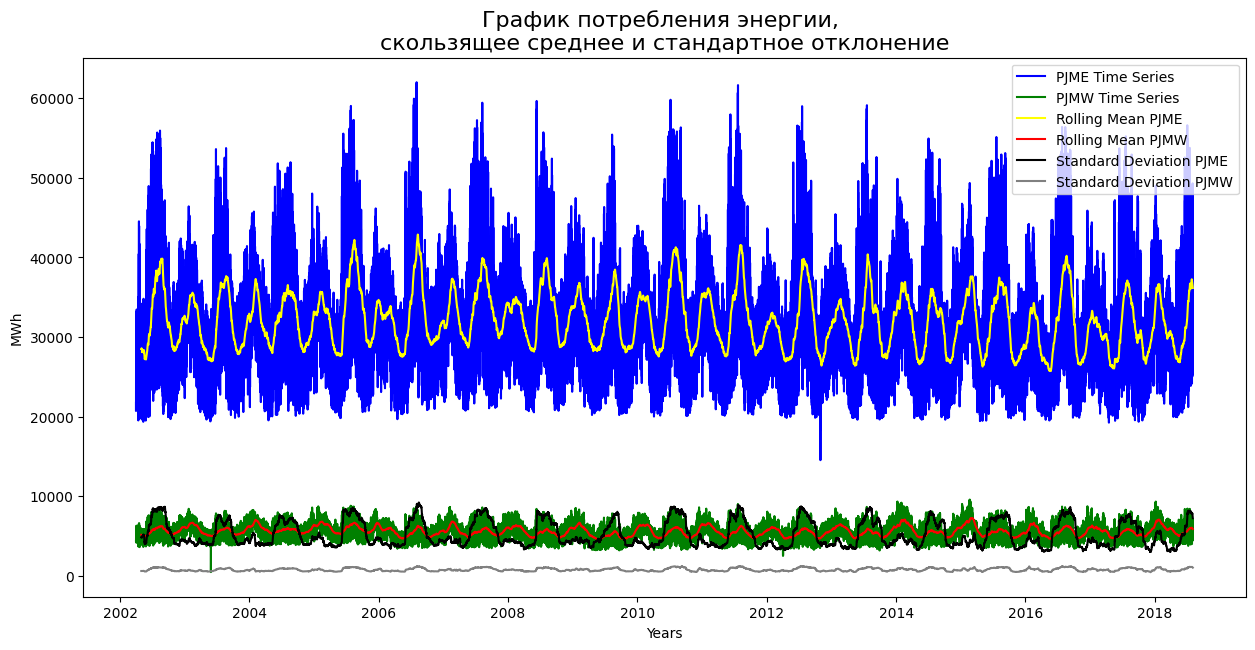

In [34]:
# Наложим на наш временной ряд скользящее среднее значение и скользящее стандартное отклонение за 30 дней 
# (30 дней х 24 часа = 720 часов):
rolling_mean_PJME = df['PJME'].rolling(720).mean()
rolling_mean_PJMW = df['PJMW'].rolling(720).mean()
rolling_std_PJME = df['PJME'].rolling(720).std()
rolling_std_PJMW = df['PJMW'].rolling(720).std()

plt.figure(figsize = (15, 7))
# Построим график нашего временного ряда:
plt.plot(df['PJME'], color="blue",label="PJME Time Series")
plt.plot(df['PJMW'], color="green",label="PJMW Time Series")

# Добавим скользящее среднее:
plt.plot(rolling_mean_PJME, color="yellow", label="Rolling Mean PJME")
plt.plot(rolling_mean_PJMW, color="red", label="Rolling Mean PJMW")

# Добавим стандартное отклонение:
plt.plot(rolling_std_PJME, color="black", label = "Standard Deviation PJME")
plt.plot(rolling_std_PJMW, color="grey", label = "Standard Deviation PJMW")

# Добавим заголовоки:
plt.title("График потребления энергии, \nскользящее среднее и стандартное отклонение", fontsize=16)
plt.xlabel('Years')
plt.ylabel('MWh')

# Добавим легенду:
plt.legend(loc="best");

>Судя по графику прослеживается явная сезонность.

***

<a id="5">

## <b> 5 <span style='color:#FFAE42'> | </span> МОДЕЛИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ </b>

<a id="5.1">

### <b> 5.1 <span style='color:#FFAE42'> | </span> Подготовка данных к моделированию</b>

> В качестве моделирования временого ряда возьмём несколько наиболее известных моделей:
- `Baseline - AR`
- `HWES`
- `XGBoost`
- `Lasso`
- `SARIMA`
- `Prophet`

> Сделаем сравнение моделей и выберем наилучшую для окончательного прогнозирования и продакшена.<br>
> Моделирование (в целях упрощения расчётов и затрат времени) будем проводить только на одних данных. Возьмём, например восточный энергорегион. Моделирования по другим энергорегионам аналогичны, что было видно на стадии подготовки и  обработки данных.

> Разделим данные на тренировочную и тестовую выборки.

In [35]:
data = df['PJME'].resample(rule='D').sum()
data = pd.DataFrame(data)

# Разделим данные на обучающую и тестовую выборки. Мы будем стремиться к 12-месячному горизонту прогноза
# (т.е. прогнозировать последние 12 месяцев в наборе данных)
df_train = data[:-366]
df_test = data[-366:-1] #исключаем последнюю строку, т.к. там сутки представлены 1 часом.

print(f"Train size: {df_train.size}")
print(f"Test size: {df_test.size}")

Train size: 5603
Test size: 365


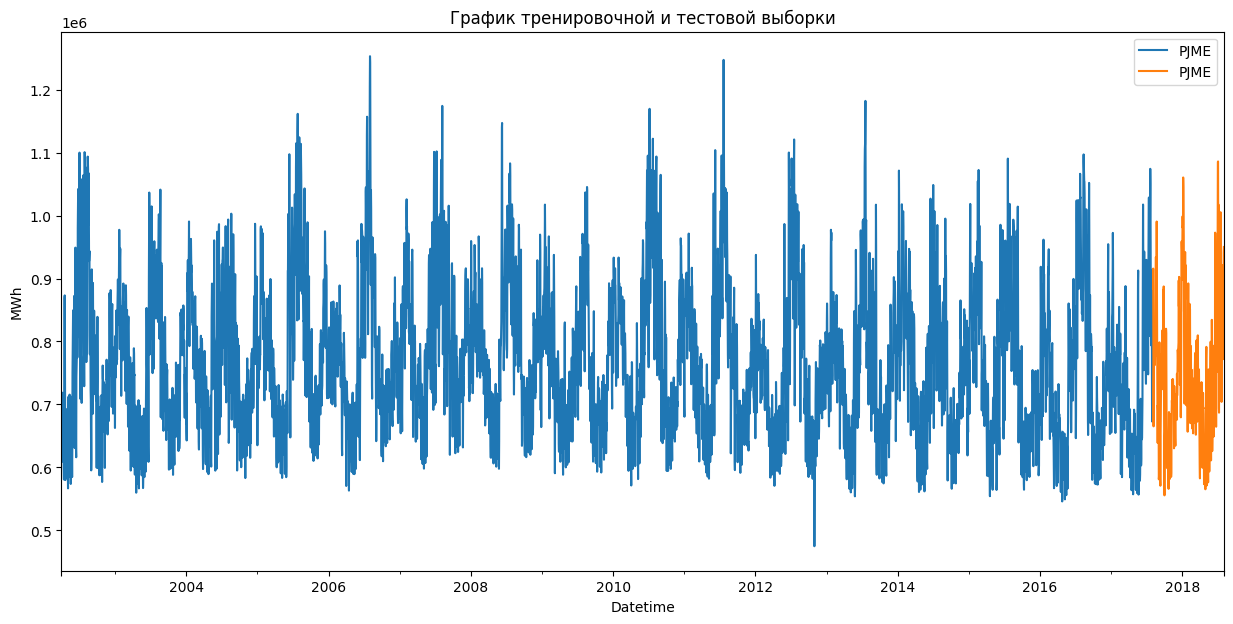

In [36]:
# Построим график тренировочной и тестовой выборки
def plot_ts(
    s_train=df_train,
    s_test=df_test,
    s_pred=None,
    ax=None,
    fit_params="График тренировочной и тестовой выборки"
    ):
    fig, ax = plt.subplots(figsize = (15, 7));
    s_train.plot(label='train', ax=ax);
    s_test.plot(label='test', ax=ax);
    plt.ylabel("MWh")
    if isinstance(s_pred, pd.Series):
        s_pred.plot(label='predict', ax=ax);
    if ax is not None:
        ax.legend(loc='upper right');
        ax.set_title(fit_params);
    else:
        plt.legend();
        
plot_ts()

<a id="5.2">

### <b> 5.2 <span style='color:#FFAE42'> | </span> Базовая модель - Наивный прогноз</b>

>Прежде всего, используем методы наивного прогнозирования для определения "базовой линии". То есть, если модели ML не могут превзойти эти базовые прогнозы, тогда нам было бы лучше просто использовать наивный прогноз вместо этого.<br>
>Распространенным наивным прогнозом для прогнозирования многоступенчатого прогноза (т.е. для нас это были бы следующие 365 дней) является использование "Постоянного прогноза годовой давности". Это в основном означает, что значение, скажем, на 31 августа 2019 года прогнозируется с использованием значения на 31 августа 2018 года.

In [37]:
baseline_pred_v1 = df_train[-365:]
baseline_pred_v1.index = pd.date_range(start='2017-08-03', end='2018-08-02')
baseline_pred_v1

PJME
2017-08-03  844169.0
2017-08-04  850357.0
2017-08-05  851820.0
2017-08-06  894816.0
2017-08-07  832704.0
...              ...
2018-07-29  700426.0
2018-07-30  672616.0
2018-07-31  830714.0
2018-08-01  914385.0
2018-08-02  895428.0

[365 rows x 1 columns]

In [38]:
# Создадим функцию, которая извлекает данные день недели и за месяц
def engineer_date_attributes(df):
    '''
    Предварительно предполагается, что входной df имеет datetime в качестве индекса.
    
    :param df : DataFrame
    
    return: Dataframe
    '''
    df['DOW'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['WOY'] = df.index.isocalendar().week
    df = df.reset_index()    

    df = df.set_index(['Month', 'DOW', 'WOY'])

    return df

# Рассчитать среднее значение текущего показателя по дню недели и месяцу
# Затем получите "форму" кривой по дням недели
current_df = df_train['2014-08-04':'2017-08-02']
current_df = engineer_date_attributes(current_df)
current_df['SHAPE_AVG'] = current_df.reset_index().groupby(by=['Month', 'DOW']).mean()['PJME']
current_df['PCT_SHAPE_AVG'] = current_df['PJME'] / current_df['SHAPE_AVG']
current_df = current_df.reset_index().groupby(by=['Month', 'DOW', 'WOY']).mean()

current_df

Datetime           PJME      SHAPE_AVG  PCT_SHAPE_AVG
Month DOW WOY                                                                 
1     0   1   2016-07-04 00:00:00  773626.000000  825645.615385       0.936995
          2   2016-01-08 16:00:00  857649.666667  825645.615385       1.038762
          3   2016-01-15 16:00:00  844077.333333  825645.615385       1.022324
          4   2016-01-22 16:00:00  804639.666667  825645.615385       0.974558
          5   2016-01-28 12:00:00  833520.500000  825645.615385       1.009538
...                           ...            ...            ...            ...
12    6   48  2016-12-04 00:00:00  666708.000000  692704.166667       0.962471
          49  2015-12-08 08:00:00  730478.666667  692704.166667       1.054532
          50  2015-12-15 08:00:00  684809.000000  692704.166667       0.988602
          51  2015-12-22 08:00:00  713889.333333  692704.166667       1.030583
          52  2015-06-28 00:00:00  629105.500000  692704.166667       0.908188

[431 rows x 4 columns]

In [39]:
# Создать прогнозируемый/будущий фрейм данных
future_df = pd.DataFrame()
future_df['Datetime'] = pd.date_range(start='2017-08-03', end='2018-08-02', freq='D')
future_df = future_df.set_index('Datetime')
future_df = engineer_date_attributes(future_df)

# Используйте DOW, месячный способ пересылки проектных данных по электричеству в горизонт прогноза, применяя форму
# текущего года
baseline_pred_v2 = future_df.merge(
    current_df[['SHAPE_AVG', 'PCT_SHAPE_AVG']],
    how='left',
    left_on=['Month', 'DOW', 'WOY'],
    right_on=['Month', 'DOW', 'WOY']
    )
baseline_pred_v2['PJME'] = baseline_pred_v2['PCT_SHAPE_AVG'] * baseline_pred_v2['SHAPE_AVG']

baseline_pred_v2 = baseline_pred_v2.set_index('Datetime').drop(columns=['SHAPE_AVG', 'PCT_SHAPE_AVG'])

baseline_pred_v2 = baseline_pred_v2.fillna(baseline_pred_v2.median())
baseline_pred_v2

PJME
Datetime                 
2017-08-03  850357.000000
2017-08-04  851820.000000
2017-08-05  873123.000000
2017-08-06  825269.500000
2017-08-07  882928.333333
...                   ...
2018-07-29  795554.333333
2018-07-30  880667.000000
2018-07-31  992581.000000
2018-08-01  869798.500000
2018-08-02  850357.000000

[365 rows x 1 columns]

>Оценим нашу модель, используя MAE (средняя абсолютная ошибка), RMSE (среднеквадратичная ошибка), MAPE (средняя абсолютная процентная ошибка).

In [40]:
# Оценим `baseline` используя: MAE, RMSE, MAPE, R2
Baseline_mae_error = meanabs(df_test['PJME'], baseline_pred_v2['PJME'])
Baseline_rmse_error = rmse(df_test['PJME'], baseline_pred_v2['PJME'])
Baseline_mape_error = mean_absolute_percentage_error(df_test['PJME'], baseline_pred_v2['PJME'])*100
Baseline_r2_error = r2_score(df_test['PJME'],baseline_pred_v2['PJME'])

print(
    "\nMAE Baseline: {:.3f}".format(Baseline_mae_error),
    "\nRMSE Baseline: {:.3f}".format(Baseline_rmse_error),
    "\nMAPE Baseline: {:.3f}".format(Baseline_mape_error),
    "\nR2 Baseline: {:.3f}".format(Baseline_r2_error),
    )


MAE Baseline: 69773.467 
RMSE Baseline: 94868.320 
MAPE Baseline: 9.152 
R2 Baseline: 0.209


>Визуализируем результаты: данные обучения выделены синим цветом, в то время как данные тестирования / оценки - красным, соответственно прогноз предварительный  и уточнённый оранжевым и зелёным цветом.

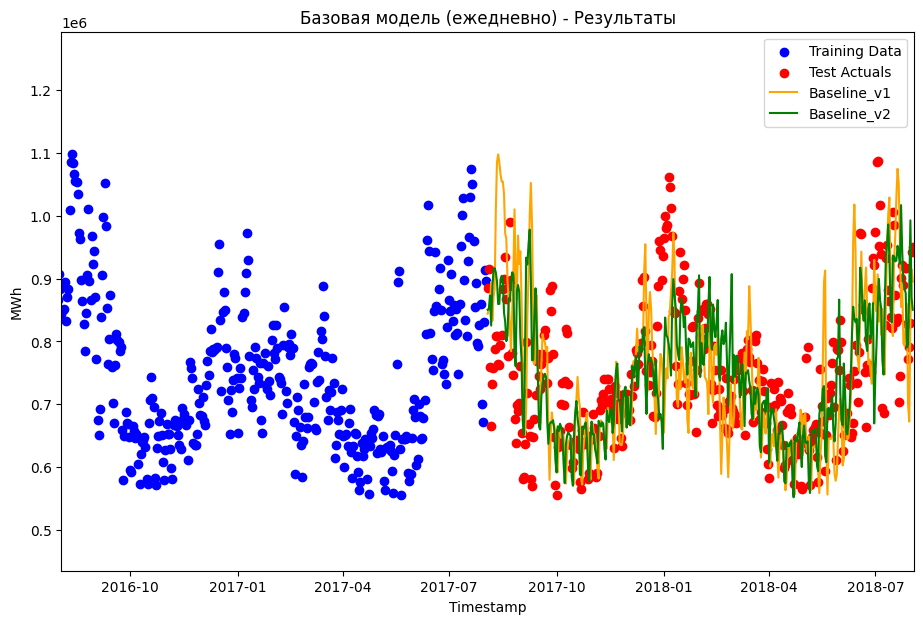

In [41]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=df_train.index,
    y=df_train,
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=df_test.index,
    y=df_test,
    label='Test Actuals',
    color='red'
    )
plt.plot(
    baseline_pred_v1,
    label='Baseline_v1',
    color='orange'
    )
plt.plot(
    baseline_pred_v2,
    label='Baseline_v2',
    color='green'
    )

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Базовая модель (ежедневно) - Результаты')

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3))
plt.show()

>Довольно приличный прогноз.<br>
>Но нужно ещё увидеть ошибки / остатки, чтобы выяснить, являются ли они:
1. Нормально распределёнными (т.е. не имеет склонности к занижению или завышению прогноза).
2. Автокоррелированными (то есть не удалось ли модели обнаружить какие-либо закономерности автокорреляции).

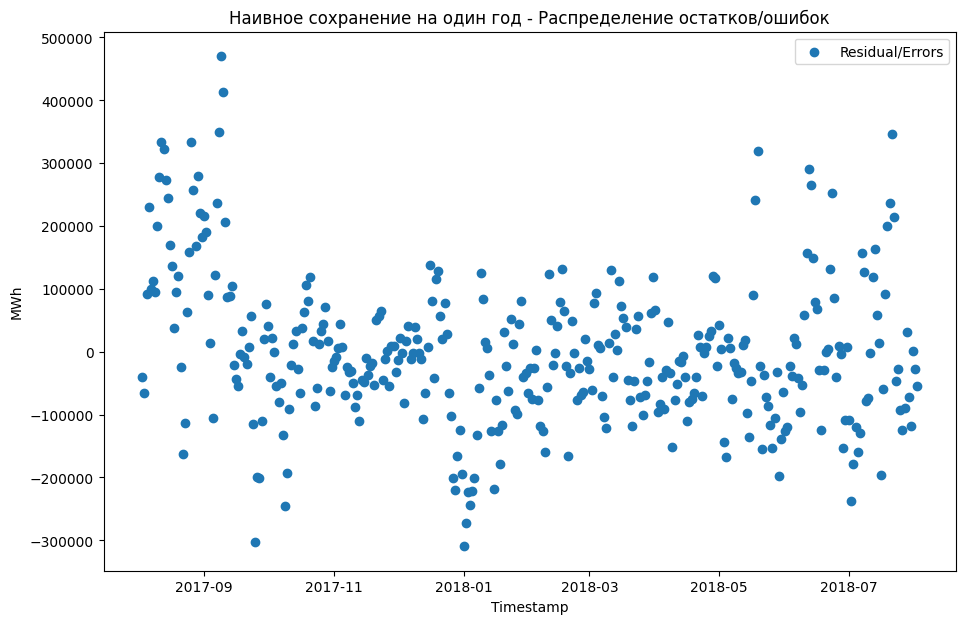

In [42]:
# Сначала посмотрим на остатки / ошибки
naive_errors = df_test.copy()
naive_errors['PJME_PRED'] = baseline_pred_v1['PJME']
naive_errors['error'] = naive_errors['PJME_PRED'] - naive_errors['PJME']

# Визуализируем ошибки с помощью диаграммы рассеяния
plt.scatter(naive_errors.index, naive_errors['error'], label='Residual/Errors')

# Графические метки, легенды и т.д.
plt.title('Наивное сохранение на один год - Распределение остатков/ошибок')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

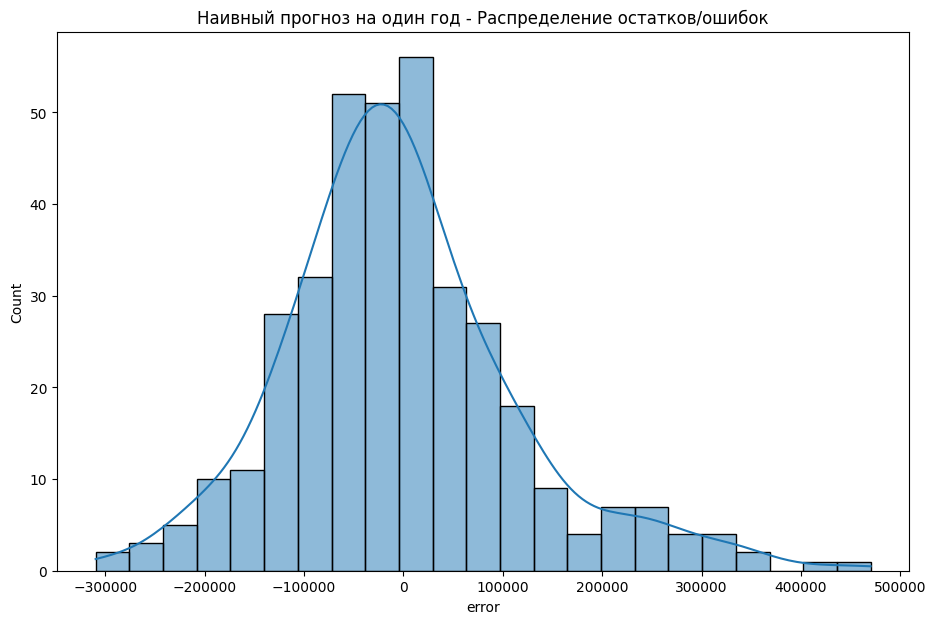

In [43]:
# Построим гистограмму с оценкой плотности ядра (KDE)
sns.histplot(naive_errors['error'], kde=True);

# Графические метки, легенды и т.д.
plt.title('Наивный прогноз на один год - Распределение остатков/ошибок');

>Наивный прогноз довольно нормально распределен с точки зрения его ошибок.

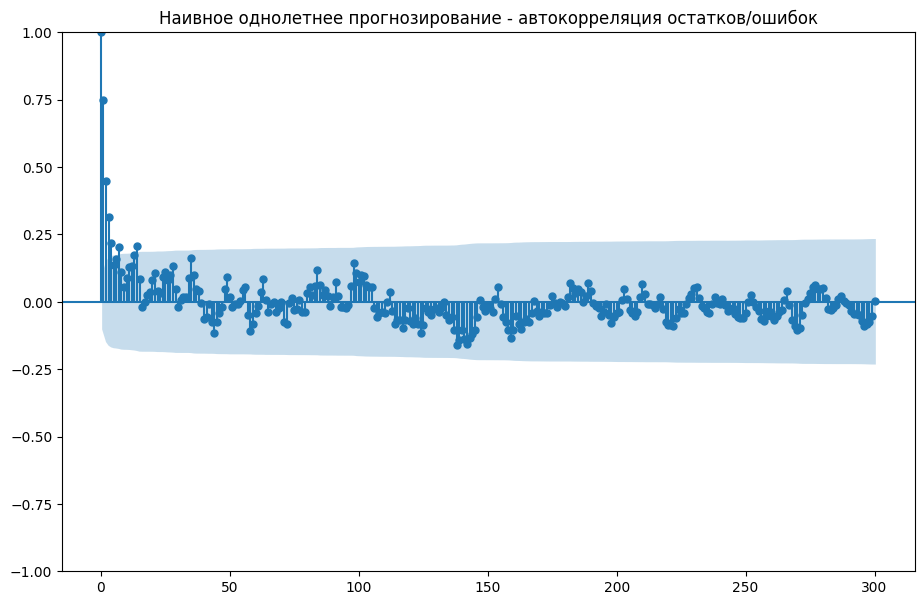

In [44]:
# Построим график функции acf
plot_acf(naive_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('Наивное однолетнее прогнозирование - автокорреляция остатков/ошибок')
plt.show()

>Таким образом, большинство точек находятся в пределах заштрихованного синего цвета (т.е. доверительного интервала), что указывает на отсутствие статистически значимой автокорреляции. Это хорошо, так как если бы существовала автокорреляция с нашими ошибками, это означало бы, что есть некоторая автокорреляция, которую наша модель не в состоянии уловить.

<a id="5.3">

### <b> 5.3 <span style='color:#FFAE42'> | </span> HWES (Тройное экспоненциальное сглаживание Холт-Винтера)</b>

>Далее мы будем использовать модель прогнозирования временных рядов, которая использует преимущества вышеуказанных компонентов.<br>
>Это известно как "генерирующая аддитивная модель", поскольку конечное прогнозируемое значение "складывается" из нескольких компонентов.<br>
>"Тройка" относится к трем компонентам:
1. **Уровень**
2. **Тенденция**
3. **Сезонность**<br>
>*Holtwinters* действительно хорошо работает, когда данные являются сезонными и имеют тенденции.<br>
>"Сглаживание" в основном означает, что более свежим данным придается больший вес по сравнению с прошлыми.
>Основными гиперпараметрами модели являются:
* **Аддитивный против мультипликативного** (т.е. "add" или "mul") 
* ***Box Cox*** - используется преобразование журнала box cox для уменьшения "шума" данных
* **Альфа** - коэффициент сглаживания от 0 до 1: 1 - означает, что всегда будет приниматься вчерашнее значение (наивное прогнозирование), 0 - означает простое усреднение по прошлому.<br>
>***add*** означает, что формула выглядит примерно так: Данные = уровень + Тренд + Сезонность<br>
>***mul*** означает, что формула выглядит примерно так: Данные = уровень x Тренд x Сезонность

In [45]:
%%time
# Сначала мы разделим его между тренировкой и тестированием. HWES принимает серию, а не DF.
htrain = df_train['PJME'].resample(rule='D').sum()
htest = df_test['PJME'].resample(rule='D').sum()

model_hw = ExponentialSmoothing(
    htrain,
    trend='add',
    seasonal='add',
    freq='D',
    seasonal_periods=90 #По умолчанию используется автоматическая оценка - 4 - ежеквартально, а 7 - еженедельно
).fit(
    optimized=True, # Значение по умолчанию True - автоматическая оценка других параметров с помощью поиска по сетке
    method="trust-constr" # Использует алгоритм перепрыгивания через бассейн для оптимизации параметров
    )

HWES_pred = model_hw.predict(start=htest.index[0], end=htest.index[-1])
HWES_pred = HWES_pred.to_frame().rename(columns={0: 'PJME'})

# Давайте посмотрим, что сделала модель
display(model_hw.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     PJME   No. Observations:                 5603
Model:             ExponentialSmoothing   SSE                 20217590631224.754
Optimized:                         True   AIC                         123490.513
Trend:                         Additive   BIC                         124113.833
Seasonal:                      Additive   AICC                        123493.896
Seasonal Periods:                    90   Date:                 Thu, 02 Nov 2023
Box-Cox:                          False   Time:                         13:58:10
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend               0.0004754                 beta                 True
smoothing_seasonal           1.4901e-08                gamma                 True
initial_level                6.9676e+05                  l.0                 True
initial_trend                -5522.3768                  b.0                 True
initial_seasons.0            -15929.806                  s.0                 True
initial_seasons.1            -11521.806                  s.1                 True
initial_seasons.2            -1120.4179                  s.2                 True
initial_seasons.3            -6210.2467                  s.3                 True
initial_seasons.4            -2989.5369                  s.4                 True
initial_seasons.5            -2682.2815                  s.5                 True
initial_seasons.6            -17340.655                  s.6                 True
initial_seasons.7            -12852.013                  s.7                 True
initial_seasons.8            -7434.4580                  s.8                 True
initial_seasons.9            -12962.188                  s.9                 True
initial_seasons.10           -26512.525                 s.10                 True
initial_seasons.11           -21209.133                 s.11                 True
initial_seasons.12           -22517.597                 s.12                 True
initial_seasons.13           -28465.418                 s.13                 True
initial_seasons.14           -17548.844                 s.14                 True
initial_seasons.15           -12353.610                 s.15                 True
initial_seasons.16           -11433.920                 s.16                 True
initial_seasons.17            3373.8104                 s.17                 True
initial_seasons.18            6763.3505                 s.18                 True
initial_seasons.19            1729.1231                 s.19                 True
initial_seasons.20            1372.3957                 s.20                 True
initial_seasons.21            12928.306                 s.21                 True
initial_seasons.22            6531.2159                 s.22                 True
initial_seasons.23            2372.6097                 s.23                 True
initial_seasons.24           -1671.5605                 s.24                 True
initial_seasons.25            11970.222                 s.25                 True
initial_seasons.26            13598.797                 s.26                 True
initial_seasons.27            8779.4334                 s.27                 True
initial_seasons.28            17018.766                 s.28                 True
initial_seasons.29            27891.388                 s.29                 True
initial_seasons.30        

CPU times: total: 16.7 s
Wall time: 16.8 s


>Используя Holt winters, данные с 2002 по 2016 год были использованы для обучения модели, в то время как остальные данные с 2016 по 2018 год были использованы для тестирования / оценки точности модели.<br>
>Давайте оценим нашу модель, используя среднюю абсолютную ошибку (MAE), и визуализируем результаты.<br>
>Данные обучения выделены синим цветом, в то время как данные тестирования / оценки - красным.

In [46]:
# Оценим `HWES` используя: MAE, RMSE, MAPE, R2
HWES_mae_error = meanabs(htest, HWES_pred['PJME'])
HWES_rmse_error = rmse(htest, HWES_pred['PJME'])
HWES_mape_error = mean_absolute_percentage_error(htest, HWES_pred['PJME'])*100
HWES_r2_error = r2_score(htest, HWES_pred['PJME'])

print(
    "\nMAE HWES: {:.3f}".format(HWES_mae_error),
    "\nRMSE HWES: {:.3f}".format(HWES_rmse_error),
    "\nMAPE HWES: {:.3f}".format(HWES_mape_error),
    "\nR2 HWES: {:.3f}".format(HWES_r2_error)
    )


MAE HWES: 124601.363 
RMSE HWES: 144758.370 
MAPE HWES: 17.684 
R2 HWES: -0.842


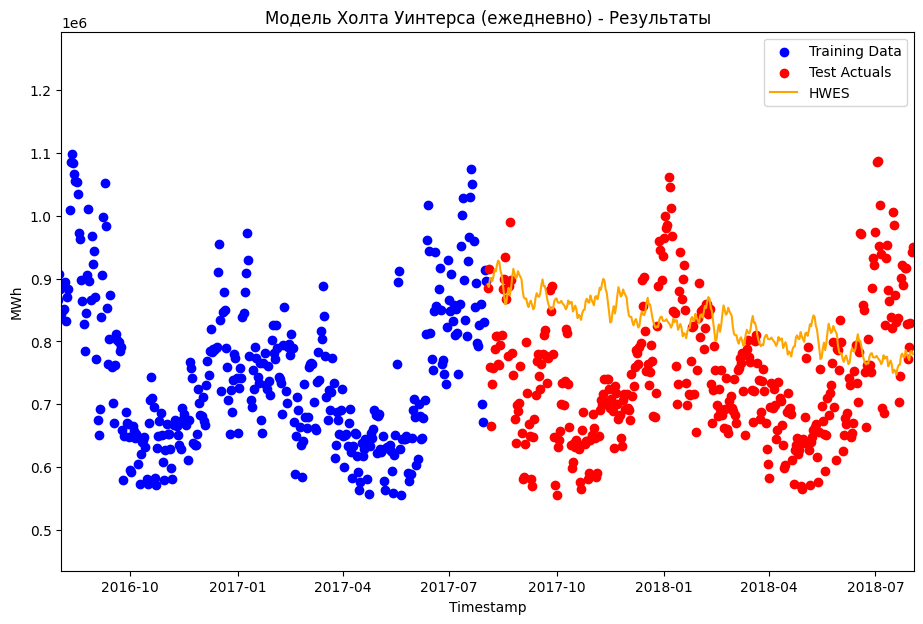

In [47]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=htrain.index,
    y=htrain,
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=htest.index,
    y=htest,
    label='Test Actuals',
    color='red'
    )
plt.plot(
    HWES_pred,
    label='HWES',
    color='orange'
    )

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Модель Холта Уинтерса (ежедневно) - Результаты')

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3))
plt.show()

>Так что, похоже, экспоненциальное сглаживание никуда не годится - давайте посмотрим, как обстоят дела у других.

<a id="5.4">

### <b> 5.4 <span style='color:#FFAE42'> | </span> XGBoost - Обучение в ансамбле</b>

>Модель XGBoost приобрел популярность благодаря тому, что довольно хорошо предсказывает множество различных типов проблем.<br>
>Обычно при использовании моделей дерева принятия решений мы получаем данные и создаём для них одно дерево. Это означает, что он очень подвержен переобучению и сбит с толку уникальными тенденциями прошлых данных.<br>
>Чтобы преодолеть это, мы выполняем "повышение градиента". На очень высоком уровне это аналогично алгоритму, создающему дерево решений, чтобы попытаться предсказать результат, выяснить, насколько он был неправильным, а затем создаём другое дерево, которое учится на "ошибках" первого.<br>
>Затем этот процесс повторяется несколько сотен или даже несколько тысяч раз, причем каждое дерево "усиливается" за счет ошибок предыдущего. Алгоритм продолжает работать до тех пор, пока не перестанет совершенствоваться сам по себе.

>Большинство моделей машинного обучения не "оглядываются" на предыдущие значения. По сути, если есть таблица, каждая "строка" является независимой точкой данных, и модель ML не учитывает данные предыдущей строки.<br>
>Это проблематично для данных временных рядов, поскольку, происходит автокорреляция.<br>
>Чтобы решить эту проблему, мы используем разработку функций для создания дополнительных функций - в данном случае я создавал 365 дополнительных столбцов каждый предыдущий день. Сегодня минус 1 день, сегодня минус 2 дня... до сегодняшнего дня минус 365 дней.

In [48]:
# Сначала разработка функций
def preprocess_xgb_data(df, lag_start=1, lag_end=365):
    '''
    Принимает данные и предварительно обрабатывает их для XGBoost.
    
    :param lag_start default 1 : int
        Lag window start - 1 indicates one-day behind
    :param lag_end default 365 : int
        Lag window start - 365 indicates one-year behind
        
    Returns tuple : (data, target)
    '''
    # По умолчанию добавляется задержка данных в 365 дней - т.е. модель учитывает 365 дней предыдущих данных
    for i in range(lag_start,lag_end):
        df[f'PJME {i}'] = df.shift(periods=i, freq='D')['PJME']
    
    df.reset_index(inplace=True)

    # Разделим атрибуты временной метки, это позволит алгоритму учитывать сезонность
    df['date_epoch'] = pd.to_numeric(df['Datetime'])
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    #Не нужна временная метка и цель
    x = df.drop(columns=['Datetime', 'PJME'])
    # Целевое предсказание - это нагрузка
    y = df['PJME']
    
    return x, y

>Посмотрим, как это выглядит:

In [49]:
#В противном случае он становится указателем
example_data = df_train.copy()

example_x, example_y = preprocess_xgb_data(example_data)
example_x.head(10)

PJME 1    PJME 2    PJME 3    PJME 4    PJME 5    PJME 6    PJME 7  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1  637480.0       NaN       NaN       NaN       NaN       NaN       NaN   
2  687613.0  637480.0       NaN       NaN       NaN       NaN       NaN   
3  681449.0  687613.0  637480.0       NaN       NaN       NaN       NaN   
4  704041.0  681449.0  687613.0  637480.0       NaN       NaN       NaN   
5  718623.0  704041.0  681449.0  687613.0  637480.0       NaN       NaN   
6  666345.0  718623.0  704041.0  681449.0  687613.0  637480.0       NaN   
7  609001.0  666345.0  718623.0  704041.0  681449.0  687613.0  637480.0   
8  693387.0  609001.0  666345.0  718623.0  704041.0  681449.0  687613.0   
9  681338.0  693387.0  609001.0  666345.0  718623.0  704041.0  681449.0   

     PJME 8    PJME 9  PJME 10  ...  PJME 363  PJME 364           date_epoch  \
0       NaN       NaN      NaN  ...       NaN       NaN  1017619200000000000   
1       NaN       NaN      NaN  ...       NaN       NaN  1017705600000000000   
2       NaN       NaN      NaN  ...       NaN       NaN  1017792000000000000   
3       NaN       NaN      NaN  ...       NaN       NaN  1017878400000000000   
4       NaN       NaN      NaN  ...       NaN       NaN  1017964800000000000   
5       NaN       NaN      NaN  ...       NaN       NaN  1018051200000000000   
6       NaN       NaN      NaN  ...       NaN       NaN  1018137600000000000   
7       NaN       NaN      NaN  ...       NaN       NaN  1018224000000000000   
8  637480.0       NaN      NaN  ...       NaN       NaN  1018310400000000000   
9  687613.0  637480.0      NaN  ...       NaN       NaN  1018396800000000000   

   dayofweek  dayofmonth  dayofyear  weekofyear  quarter  month  year  
0          0           1         91          14        2      4  2002  
1          1           2         92          14        2      4  2002  
2          2           3         93          14        2      4  2002  
3          3           4         94          14        2      4  2002  
4          4           5         95          14        2      4  2002  
5          5           6         96          14        2      4  2002  
6          6           7         97          14        2      4  2002  
7          0           8         98          15        2      4  2002  
8          1           9         99          15        2      4  2002  
9          2          10        100          15        2      4  2002  

[10 rows x 372 columns]

>Теперь нам нужно разделить временные ряды между обучением и тестированием - подобно тому, что мы делали раньше.<br>
>Перекрестная проверка в этом случае сложнее, так как наборы данных должны быть последовательными.<br>
>Нам также нужно будет указать объекты и метки (т.е. цель, которую мы хотим предсказать).

In [50]:
xtrain = df_train.copy()
xtest = df_test.copy()

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

>Наконец, мы обучаем модель и смотрим, насколько хорошо она работает (используя MAE), и визуализируем результаты.<br>
>Чтобы обучить модель, разделяем данные на две части: обучение с 2002 по 2017 год и оценка/тестирование с 2017 по 2018 год.<br>
>В этом случае используем 1000 прогонов, а максимальная глубина каждого дерева равна 6. То есть, он выполняет 1000 запусков (или меньше, если перестает улучшаться), при этом каждое дерево имеет максимум 6 уровней.<br>
>Как древовидный алгоритм, XGBoost, как правило, плохо обрабатывает тенденции в данных по сравнению с линейными моделями. Однако, учитывая, что данные являются стационарными, тенденция на самом деле не является проблемой, и мы можем продолжать.

In [51]:
%%time
# Мы попробуем использовать 1000 деревьев и максимальную глубину каждого дерева, равную 5
# Досрочная остановка, если модель не улучшилась за 100 раундов
model_xgb = XGBRegressor(
    max_depth=6, # Default - 6
    n_estimators=1000,
    booster='gbtree',
    colsample_bytree=1, # Subsample ratio of columns when constructing each tree - default 1
    eta=0.3, # Learning Rate - default 0.3
    importance_type='weight' # Default is gain
)
model_xgb.fit(
    train_feature,
    train_label,
    eval_set=[(train_feature, train_label)],
    eval_metric='mae',
    verbose=True,
    early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME_Pred'] = model_xgb.predict(test_feature)
XGB_pred = xtest[['Datetime', 'PJME_Pred']].set_index('Datetime')

[0]	validation_0-mae:68405.18957
[1]	validation_0-mae:53286.10769
[2]	validation_0-mae:43100.56823
[3]	validation_0-mae:36587.28058
[4]	validation_0-mae:32074.92160
[5]	validation_0-mae:29093.40117
[6]	validation_0-mae:27159.64199
[7]	validation_0-mae:25424.33545
[8]	validation_0-mae:24283.20587
[9]	validation_0-mae:23386.45560
[10]	validation_0-mae:22679.40589
[11]	validation_0-mae:22085.55906
[12]	validation_0-mae:21496.33649
[13]	validation_0-mae:21017.86592
[14]	validation_0-mae:20686.53033
[15]	validation_0-mae:20181.78777
[16]	validation_0-mae:19779.48207
[17]	validation_0-mae:19538.95357
[18]	validation_0-mae:19280.59792
[19]	validation_0-mae:18960.71638
[20]	validation_0-mae:18698.19754
[21]	validation_0-mae:18272.38039
[22]	validation_0-mae:17943.28974
[23]	validation_0-mae:17452.41734
[24]	validation_0-mae:17301.82856
[25]	validation_0-mae:17053.30014
[26]	validation_0-mae:16695.85184
[27]	validation_0-mae:16549.30022
[28]	validation_0-mae:16303.84643
[29]	validation_0-mae:16

In [52]:

# Оценим `XGB` используя: MAE, RMSE, MAPE, R2
print(
    "\nMAE XGB: {:.3f}".format(meanabs(test_label, XGB_pred['PJME_Pred'])),
    "\nRMSE XGB: {:.3f}".format(rmse(test_label, XGB_pred['PJME_Pred'])),
    "\nMAPE XGB: {:.3f}".format(mean_absolute_percentage_error(test_label, XGB_pred['PJME_Pred'])),
    "\nR2 XGB: {:.3f}".format(r2_score(test_label, XGB_pred['PJME_Pred']))
    )


MAE XGB: 41052.930 
RMSE XGB: 52987.295 
MAPE XGB: 0.055 
R2 XGB: 0.753


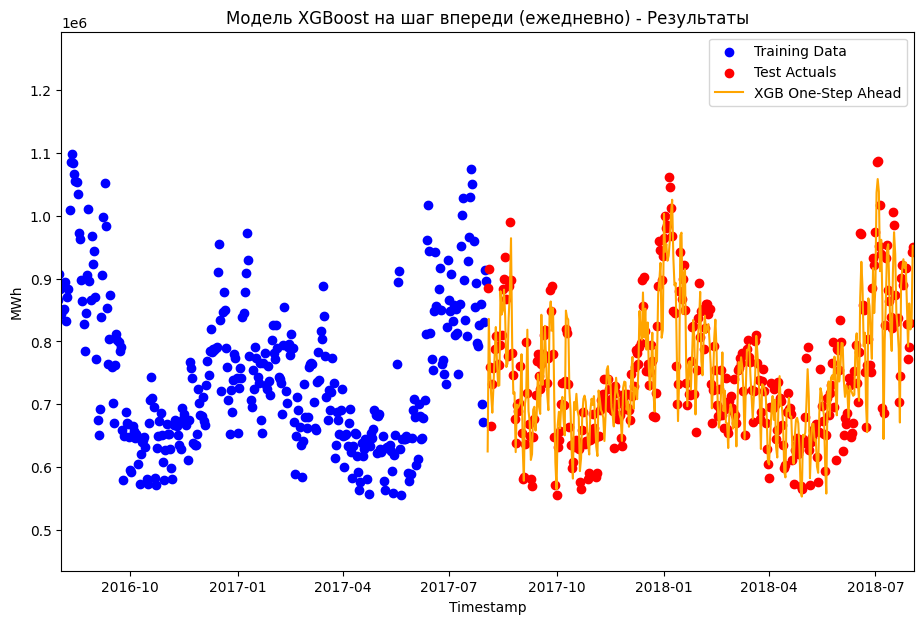

In [53]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=df_train.index,
    y=df_train['PJME'],
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=df_test.index,
    y=df_test['PJME'],
    label='Test Actuals',
    color='red'
    )
plt.plot(
    XGB_pred,
    label='XGB One-Step Ahead',
    color='orange'
    )

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Модель XGBoost на шаг впереди (ежедневно) - Результаты')

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3))

plt.show()

>Результаты модели довольно точны!<br>
>Однако предостережение заключается в том, что модель знает о вчерашнем значении. Таким образом, "горизонт прогноза" (т.е. максимальный промежуток времени, который он может предсказать в будущем) составляет всего 1 день. Это также известно как "Прогноз на один шаг вперед".<br>
>Если у вас есть только вчерашнее значение, вы можете предсказать только сегодняшнее значение.

>Посмотрим, что алгоритм счёл наиболее важным - мы возьмем Топ-10 функций по весу.<br>
>Вес - это процент, представляющий относительное количество раз, когда определенный объект встречается в деревьях модели. Это грубый способ сказать, что чем больше раз вы ссылаетесь на ту или иную функцию, тем больше вероятность того, что она важна.

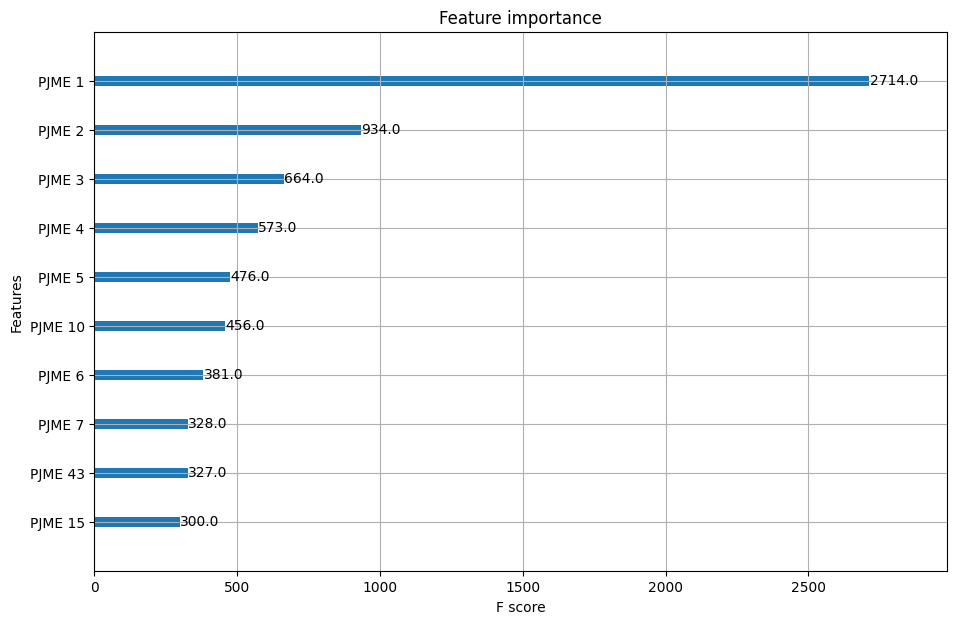

In [54]:
# "вес” - это количество раз, когда объект появляется в дереве
xgb.plot_importance(
    model_xgb,
    max_num_features=10,
    importance_type='weight'
    ) 

plt.show();

>Похоже, вчерашние значения являются самым важным фактором в определении сегодняшних значений! Это, опять же, имеет смысл, учитывая, как автокорреляционная функция показала, что вчерашнее значение имело наибольшую корреляцию с сегодняшним значением.

>Альтернативный подход к разработке функций - давайте включим задержку без утечки данных.<br>
>Давайте попробуем сделать модель XGBoost более чем на шаг впереди - у нас будет только признак:
- День недели
- День месяца
- День в году
- Неделя в году
- Месяц
- Год<br>
>Надеюсь, этого достаточно для того, чтобы модель искусственно подобрала факторы "сезонности" - например, если один и тот же день недели может быть коррелирован.<br>
>Однако, поскольку горизонт прогноза составляет 365 дней, мы все еще можем включить данные с запаздыванием от 365 до 720 дней (т.е. данные за позапрошлый год).

In [55]:
# Итак, поскольку нам нужны данные о задержке, нам нужно выполнить предварительную обработку, а затем
# выполнить разделение
all_data = daily_df.copy()

feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# Мы будем стремиться к 12-месячному горизонту прогноза (т.е. прогнозируем последние 365 дней в наборе данных).
train_feature = feature[:-366]
train_label = label[:-366]

test_feature = feature[-366:-1]
test_label = label[-366:-1]

In [56]:
%%time
# Мы попробуем использовать 1000 деревьев и максимальную глубину каждого дерева, равную 6
# Досрочная остановка, если модель не улучшилась за 100 раундов
model = XGBRegressor(
    max_depth=6, # Default - 6
    n_estimators=1000,
    booster='gbtree',
    colsample_bytree=1, # Subsample ratio of columns when constructing each tree - default 1
    eta=0.3, # Learning Rate - default 0.3
    importance_type='gain' # Default is gain
)
model.fit(
    train_feature,
    train_label,
    eval_set=[(train_feature, train_label)],
    eval_metric='mae',
    verbose=True,
    early_stopping_rounds=100 # Stop after 100 rounds if it doesn't after 100 times
)

xtest['PJME Prediction'] = model.predict(test_feature)
XGB_prediction_no_lag = xtest[['Datetime', 'PJME Prediction']].set_index('Datetime')
XGB_prediction_no_lag = XGB_prediction_no_lag.rename(columns={'PJME Prediction': 'PJME'})

[0]	validation_0-mae:67555.05043
[1]	validation_0-mae:51240.82901
[2]	validation_0-mae:40250.69483
[3]	validation_0-mae:32927.32101
[4]	validation_0-mae:27876.20485
[5]	validation_0-mae:24218.72640
[6]	validation_0-mae:21665.05739
[7]	validation_0-mae:19916.75972
[8]	validation_0-mae:18582.72583
[9]	validation_0-mae:17514.47115
[10]	validation_0-mae:16777.97146
[11]	validation_0-mae:16207.00930
[12]	validation_0-mae:15758.65755
[13]	validation_0-mae:15305.80506
[14]	validation_0-mae:14842.43650
[15]	validation_0-mae:14524.96804
[16]	validation_0-mae:14282.99643
[17]	validation_0-mae:13945.55467
[18]	validation_0-mae:13766.91860
[19]	validation_0-mae:13622.25866
[20]	validation_0-mae:13363.65075
[21]	validation_0-mae:13070.70385
[22]	validation_0-mae:12859.99661
[23]	validation_0-mae:12601.27181
[24]	validation_0-mae:12324.43540
[25]	validation_0-mae:11983.48051
[26]	validation_0-mae:11733.78025
[27]	validation_0-mae:11557.76071
[28]	validation_0-mae:11366.99207
[29]	validation_0-mae:11

In [57]:
# Оценим `XGB` используя: MAE, RMSE, MAPE, R2
XGB_mae_error = meanabs(test_label, XGB_prediction_no_lag['PJME'])
XGB_rmse_error = rmse(test_label, XGB_prediction_no_lag['PJME'])
XGB_mape_error = mean_absolute_percentage_error(test_label, XGB_prediction_no_lag['PJME'])*100
XGB_r2_error = r2_score(test_label, XGB_prediction_no_lag['PJME'])

print(
    "\nMAE XGB: {:.3f}".format(XGB_mae_error),
    "\nRMSE XGB: {:.3f}".format(XGB_rmse_error),
    "\nMAPE XGB: {:.3f}".format(XGB_mape_error),
    "\nR2 XGB: {:.3f}".format(XGB_r2_error),
    )


MAE XGB: 31141.441 
RMSE XGB: 40434.609 
MAPE XGB: 4.196 
R2 XGB: 0.856


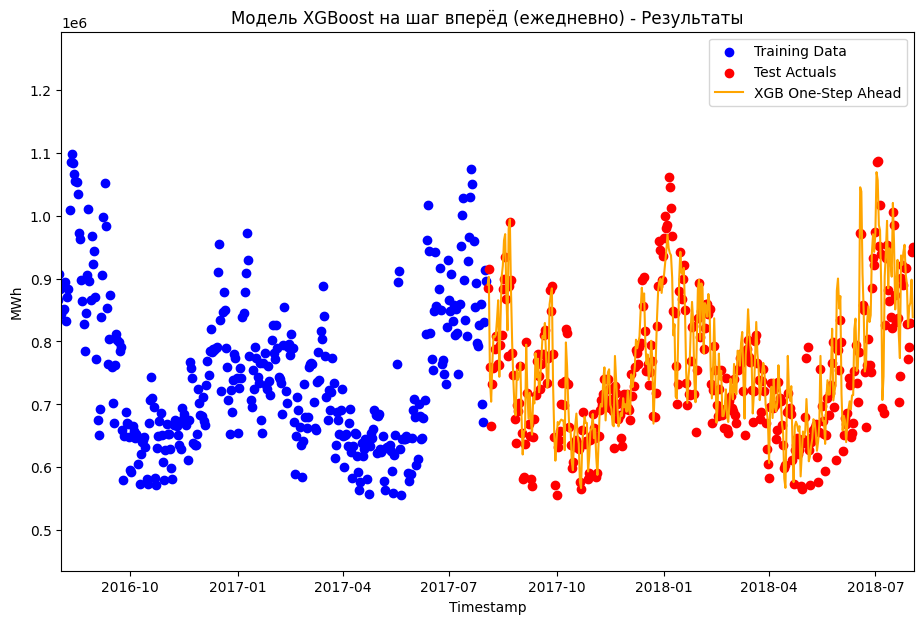

In [58]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=df_train.index,
    y=df_train['PJME'],
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=df_test.index,
    y=df_test['PJME'],
    label='Test Actuals',
    color='red'
    )
plt.plot(
    XGB_prediction_no_lag,
    label='XGB One-Step Ahead',
    color='orange'
    )

# Plot Labels, Legends etc
# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Модель XGBoost на шаг вперёд (ежедневно) - Результаты')

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3))

plt.show()

>Снова посмотрим на важность функции - на этот раз по приросту, а не по весу (как модель, обученная на приросте).

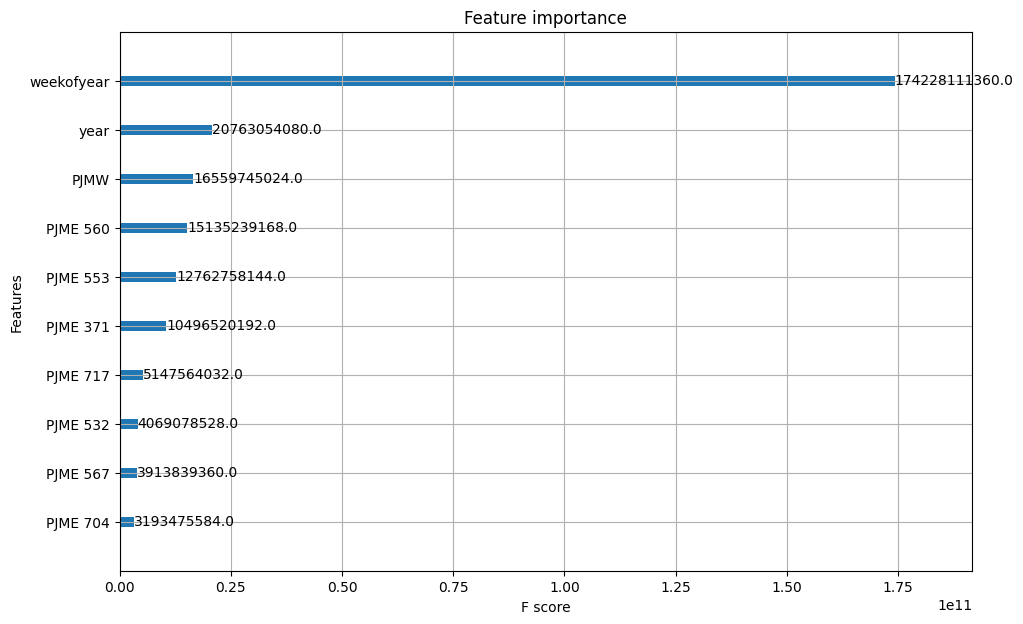

In [59]:
xgb.plot_importance(
    model,
    max_num_features=10,
    importance_type='gain'
    ) # gain is how much each feature contributed to 'improvement' of tree

plt.show()

>Теперь давайте взглянем на остатки / ошибки.

>Сначала давайте посмотрим на распределение ошибок - помните, что идеальным состоянием является то, что ошибки сосредоточены вокруг нуля (это означает, что модель не делает особенно предвзятых прогнозов).:

In [60]:
# Сначала построим остатки - в основном ошибки
xgboost_errors = XGB_prediction_no_lag.copy()
xgboost_errors['PJME_ACTUAL'] = df_test.copy()
xgboost_errors['error'] = xgboost_errors['PJME'] - xgboost_errors['PJME_ACTUAL']

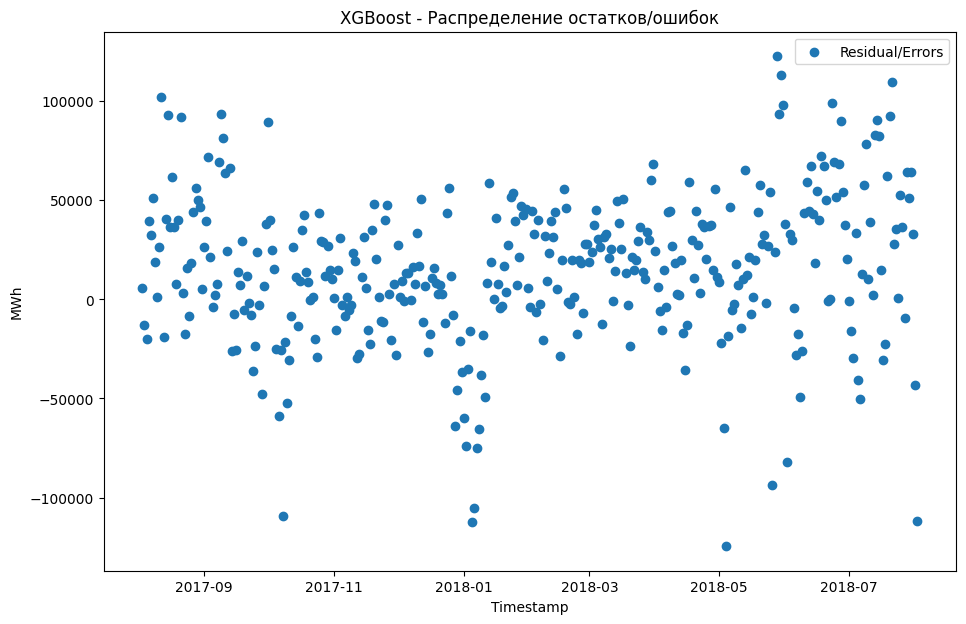

In [61]:
# Давайте визуально увидим ошибки с помощью диаграммы рассеяния
plt.scatter(xgboost_errors.index, xgboost_errors['error'], label='Residual/Errors')

# Графические метки, легенды и т.д.
plt.title('XGBoost - Распределение остатков/ошибок')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show();

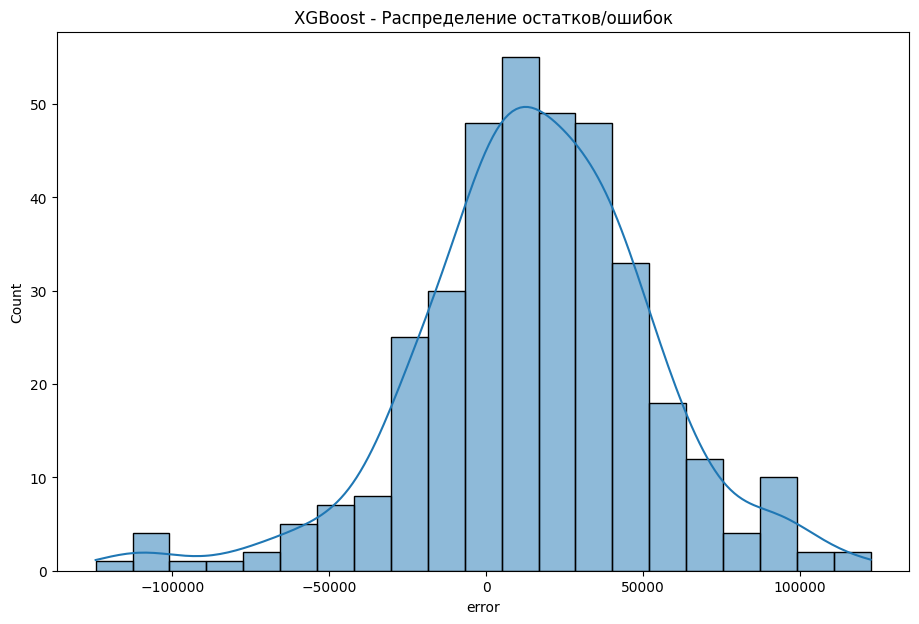

In [62]:
# Построение гистограммы с оценкой плотности ядра (KDE)
sns.histplot(xgboost_errors['error'], kde=True);

# Plot Labels, Legends etc
# Графические метки, легенды и т.д.
plt.title('XGBoost - Распределение остатков/ошибок');

>Итак, выглядит довольно неплохо - вы можете видеть, что некоторые прогнозы были довольно неточными (особенно для всплесков), но в целом, похоже, что модель учитывает превышения и недооценки на равных.

>Далее давайте посмотрим на автокорреляцию ошибок

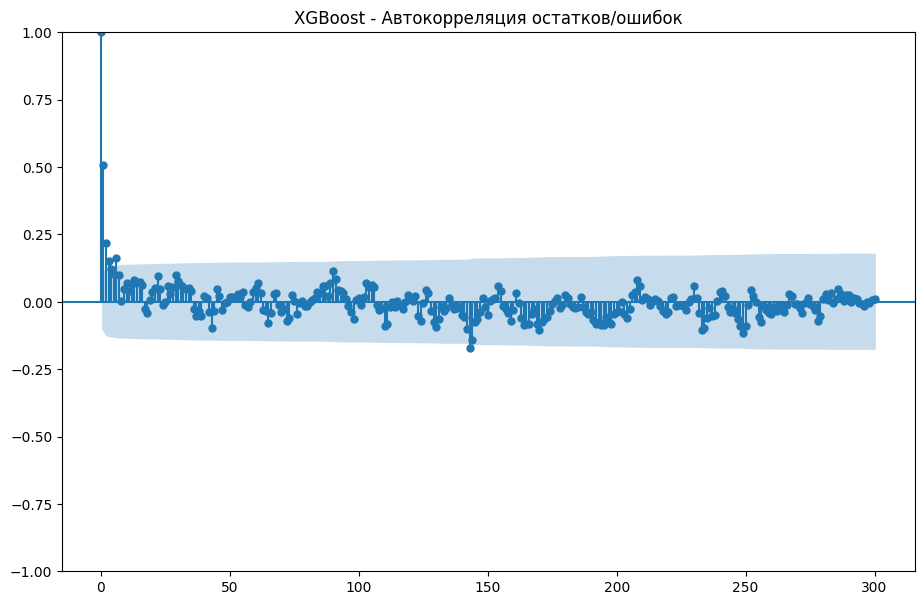

In [63]:
# Построим график функции acf
plot_acf(xgboost_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('XGBoost - Автокорреляция остатков/ошибок')
plt.show()

>Таким образом, большинство точек находятся в пределах заштрихованного синего цвета (т.е. доверительного интервала), что указывает на отсутствие статистически значимой автокорреляции. Это хорошо, так как если бы существовала автокорреляция с нашими ошибками, это означало бы, что есть некоторая автокорреляция, которую наша модель не в состоянии уловить.

<a id="5.5">

### <b> 5.5 <span style='color:#FFAE42'> | </span> LASSO L1-Регрессия</b>

>Регрессия LASSO включает в свой алгоритм регуляризацию и выбор признаков. Регуляризация - это метод, используемый в алгоритмах регрессии, чтобы избежать переобучения. Для LASSO это означает, что он будет наказывать "нерелевантные" функции, эффективно "обнуляя" эти функции (умножая их на коэффициент 0).<br>
>Основным гиперпараметром для настройки является штрафной коэффициент (т.е. лямбда или альфа). Коэффициент, равный 0, означает, что штрафных санкций не происходит, и фактически выполняется обычная регрессия по методу наименьших квадратов (OLS).<br>
>Поскольку мы уже настроили все разделение на обучающие тесты (а также разработку функций) в предыдущей модели XGBoost, мы можем просто повторно использовать ее.<br>
>Однако, как и XGBoost на основе дерева решений, линейная регрессия чувствительна к масштабу. Следовательно, нам также необходимо масштабировать данные.

In [64]:
# Итак, поскольку нам нужны данные о задержке, нам нужно выполнить предварительную обработку,  а затем выполнить
# разделение
all_data = daily_df.copy()

# Создадим набор данных для тестирования поезда с использованием предварительной обработки XGBoost (задержка от 365
# дней до 720 дней)
feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# Мы будем стремиться к 12-месячному горизонту прогноза (т.е. прогнозируем последние 365 дней в наборе данных).
train_feature = feature[:-366]
train_label = label[:-366]

test_feature = feature[-366:-1]
test_label = label[-366:-1]

train_feature = train_feature.fillna(0)
test_feature = test_feature.fillna(0)

# Масштабируем набор данных
scaler = StandardScaler()

train_feature_scaled = scaler.fit_transform(train_feature)
test_feature_scaled = scaler.transform(test_feature)

In [65]:
# Создаём перекрестную проверку временных рядов в k-кратном размере
tscv = TimeSeriesSplit(n_splits=5) # in this case 5-fold

model = LassoCV(
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1],
    max_iter=1000, # 1000 iterations
    random_state=42,
    cv=tscv,
    verbose=True
)
model.fit(
    train_feature_scaled,
    train_label
)
LASSO_prediction = xtest.copy()
LASSO_prediction['PJME Prediction'] = model.predict(test_feature_scaled)
LASSO_prediction = LASSO_prediction[['Datetime', 'PJME Prediction']].set_index('Datetime')
LASSO_prediction = LASSO_prediction.rename(columns={'PJME Prediction': 'PJME'})

LASSO_prediction

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


PJME
Datetime                 
2017-08-03  914204.373339
2017-08-04  903970.636867
2017-08-05  759742.592801
2017-08-06  709213.744637
2017-08-07  804412.581166
...                   ...
2018-07-29  794349.788146
2018-07-30  828623.768451
2018-07-31  862000.675520
2018-08-01  886989.508417
2018-08-02  875616.742562

[365 rows x 1 columns]

In [66]:
# Оценим `LASSO` используя: MAE, RMSE, MAPE, R2
LASSO_mae_error = meanabs(test_label, LASSO_prediction['PJME'])
LASSO_rmse_error = rmse(test_label, LASSO_prediction['PJME'])
LASSO_mape_error = mean_absolute_percentage_error(test_label, LASSO_prediction['PJME'])*100
LASSO_r2_error = r2_score(test_label, LASSO_prediction['PJME'])

print(
    "\nMAE LASSO: {:.3f}".format(LASSO_mae_error),
    "\nMAE LASSO: {:.3f}".format(LASSO_rmse_error),
    "\nMAE LASSO: {:.3f}".format(LASSO_mape_error),
    "\nMAE LASSO: {:.3f}".format(LASSO_r2_error)
    )


MAE LASSO: 35615.335 
MAE LASSO: 43906.675 
MAE LASSO: 4.780 
MAE LASSO: 0.831


>Теперь давайте построим график результатов

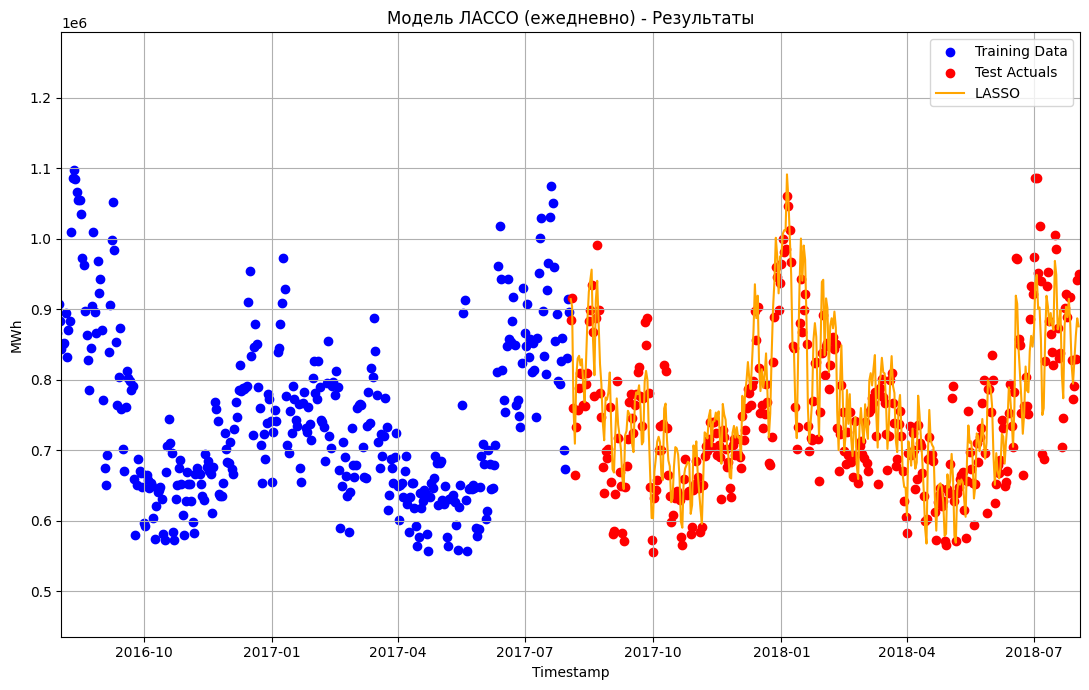

In [67]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=df_train.index,
    y=df_train['PJME'],
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=df_test.index,
    y=df_test['PJME'],
    label='Test Actuals',
    color='red'
    )
plt.plot(
    LASSO_prediction,
    label='LASSO',
    color='orange'
    )

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Модель ЛАССО (ежедневно) - Результаты')
plt.tight_layout()
plt.grid(True)

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3))      

plt.show();

>Далее давайте посмотрим на важность функции с помощью коэффициентов - мы получим только топ-10.

>Помните, что LASSO "обнулит" нерелевантные функции, поэтому в данном случае это топ-10 функций, которые LASSO считает наиболее важными.

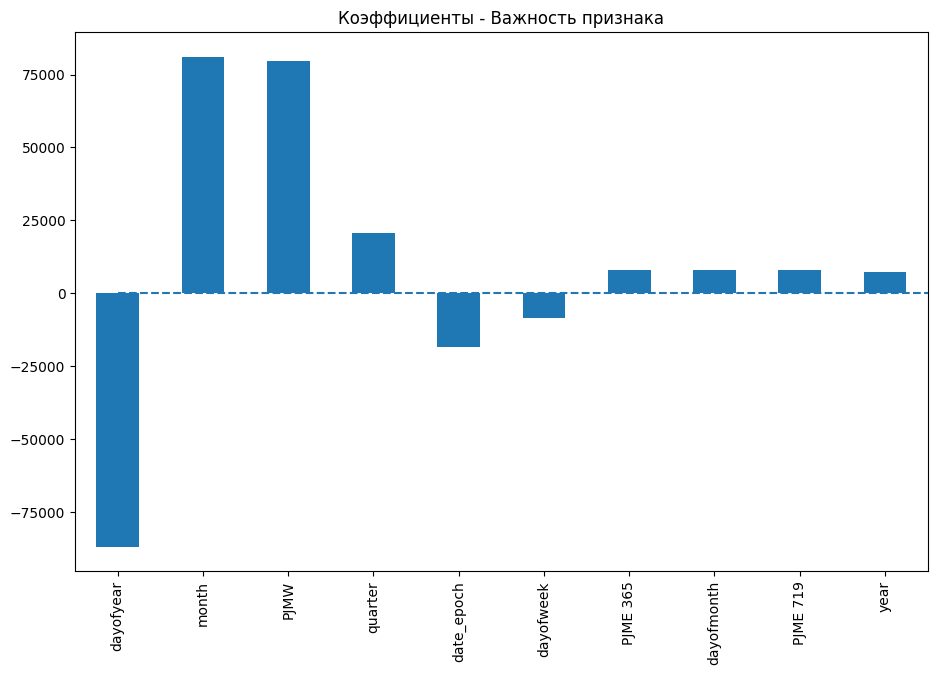

In [68]:
# Построить график важности объекта с помощью коэффициентов    
# Создать фрейм данных
coefs = pd.DataFrame(model.coef_, train_feature.columns)
coefs.columns = ["coef"]

# Используйте только 10 лучших коэффициентов
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).head(10)
coefs = coefs.drop(["abs"], axis=1)

coefs.coef.plot(kind='bar')

# Заголовок графика и линия по оси x
plt.title("Коэффициенты - Важность признака")
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

>Таким образом, ЛАССО дает приличные результаты! Теперь давайте взглянем на остатки / ошибки.

>Сначала давайте посмотрим на распределение ошибок, идеальное состояние - это когда ошибки сосредоточены вокруг нуля (это означает, что модель не дает предвзятого прогноза).

In [69]:
# Сначала построим остатки - в основном ошибки
lasso_errors = LASSO_prediction.copy()
lasso_errors['PJME_ACTUAL'] = df_test.copy()
lasso_errors['error'] = lasso_errors['PJME'] - lasso_errors['PJME_ACTUAL']

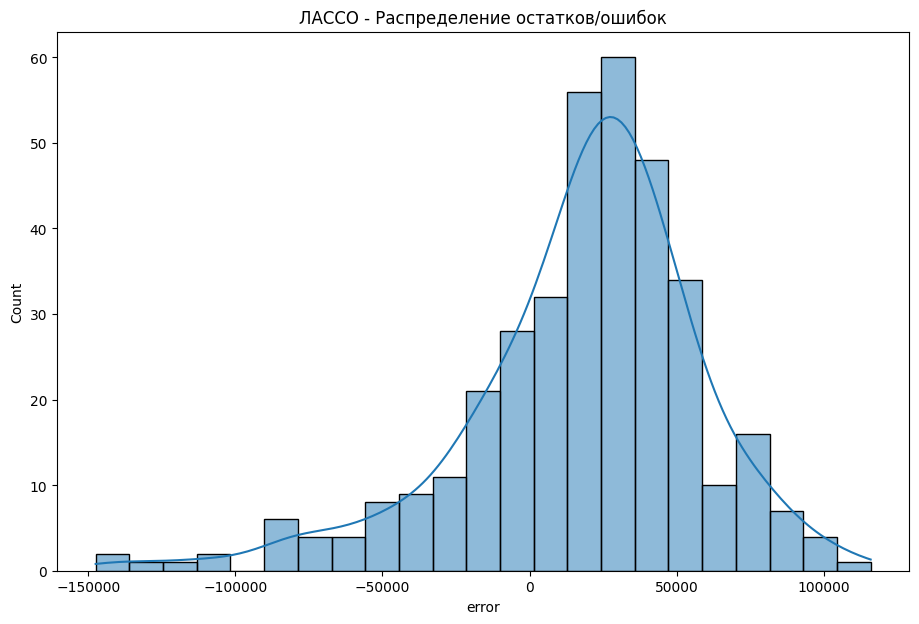

In [70]:
# Построение гистограммы с оценкой плотности ядра (KDE)
sns.histplot(lasso_errors['error'], kde=True)

# Графические метки, легенды и т.д.
plt.title('ЛАССО - Распределение остатков/ошибок')

plt.show();

>Выглядит довольно неплохо, некоторые прогнозы были довольно неточными, но в целом, модель учитывает превышения и недооценки на равных.

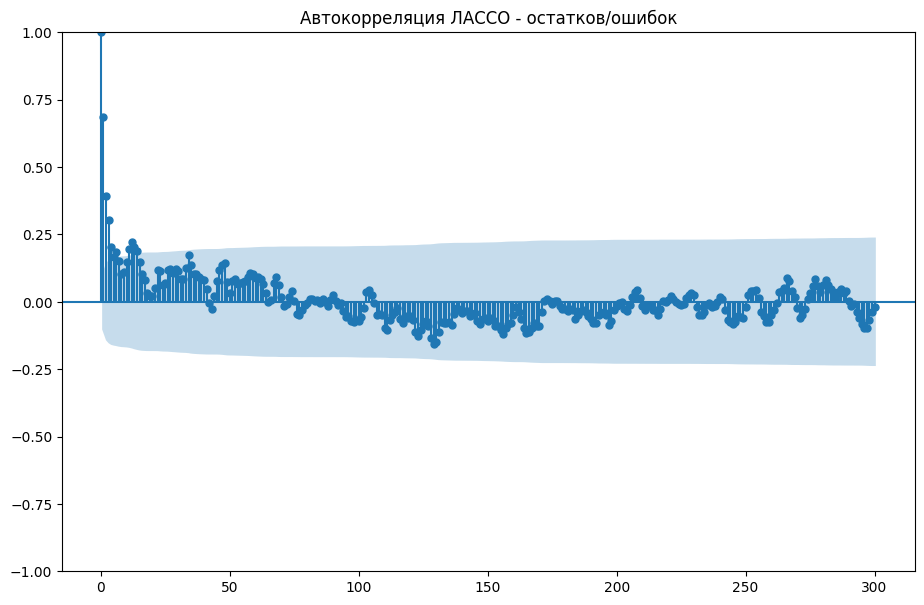

In [71]:
# Построим график функции acf
plot_acf(lasso_errors['error'],lags=300) #alpha 1 suppresses CI

plt.title('Автокорреляция ЛАССО - остатков/ошибок')
plt.show();

>Таким образом, большинство точек находятся в пределах заштрихованного синего цвета (т.е. доверительного интервала), что указывает на отсутствие статистически значимой автокорреляции. Это хорошо, так как если бы существовала автокорреляция с нашими ошибками, это означало бы, что есть некоторая автокорреляция, которую наша модель не в состоянии уловить.

<a id="5.6"></a> 

### <b> 5.6 <span style='color:#FFAE42'> | </span> SARIMA</b>

>Обычная модель ARIMA предполагает, что исторические данные полезны для прогнозирования значения на следующем временном шаге. В данном случае это отчасти верно, поскольку график ACF, показанный ранее, показал, что прошлое значение в некоторой степени коррелирует с сегодняшним значением.

>ARIMA в основном объединяет два наивных метода прогнозирования вместе:
1. **Авторегрессия** - использует одно или несколько прошлых значений для прогнозирования будущего. Количество используемых значений известно как "порядок" (например, порядок 2 означает, что используется вчерашнее и позапрошлое значение).
2. **Интеграция** - часть, которая уменьшает сезонность. Сколько степеней дифференциации делается для уменьшения сезонности - это "порядок".
3. **Скользящее среднее** - Использует скользящее среднее исторических данных для корректировки прогнозируемых значений. Это оказывает "сглаживающий" эффект на прошлые данные, поскольку при этом используется скользящее среднее, а не фактические значения за прошлые периоды. Количество дней в окне скользящей средней - это "порядок".

>Затем SARIMA добавляет в модель ARIMA "сезонность" - она учитывает тенденции и сезонность, как объяснялось выше.

>Основными гиперпараметрами являются SARIMAX(p,d,q)(P,D,Q,m):
1. порядок авторегрессии (p)
2. Порядок интегрирования (d)
3. окно скользящей средней (q)
4. Порядок сезонной авторегрессии (P)
5. Порядок сезонных различий (D)
6. Порядок сезонной скользящей средней (Q)
7. количество временных шагов за один сезонный период (m)

>X - это экзогенные (внешние) переменные модели - они необязательны, и для этой модели мы не будем их использовать.

>Нам нужно найти оптимальную модель. Что это значит? Модель должна обладать достаточной мощностью прогнозирования и при этом быть как можно более простой, чтобы предотвратить переопределение данных.

>Для этого мы проведем итерацию со всеми разумными комбинациями параметров. Это называется “поиск по сетке". Нам нужно сопоставить каждую модель SARIMA с выбранными значениями параметров с данными обучения и сравнить оценочный показатель.

In [72]:
%%time
# Определим диапазон значений для p, d, q, P, D, Q и m
p_values = range(0, 6)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Создадим все возможные комбинации параметров SARIMA
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Инициализируем AIC с лучшим значением
best_aic = float("inf")  
best_params = None

# Выполним поиск по сетке
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = sm.tsa.SARIMAX(df_train, 
                               order=order, 
                               easonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Обеспечим сходимость модели
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Выведем наилучшие параметры и AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 167937.75627285193
(0, 0, 0) (0, 0, 1, 12) 167937.75627285193
(0, 0, 0) (1, 0, 0, 12) 167937.75627285193
(0, 0, 0) (1, 0, 1, 12) 167937.75627285193
(0, 0, 1) (0, 0, 0, 12) 163780.68557442437
(0, 0, 1) (0, 0, 1, 12) 163780.68557442437
(0, 0, 1) (1, 0, 0, 12) 163780.68557442437
(0, 0, 1) (1, 0, 1, 12) 163780.68557442437
(0, 0, 2) (0, 0, 0, 12) 162822.01677466906
(0, 0, 2) (0, 0, 1, 12) 162822.01677466906
(0, 0, 2) (1, 0, 0, 12) 162822.01677466906
(0, 0, 2) (1, 0, 1, 12) 162822.01677466906
(1, 0, 0) (0, 0, 0, 12) 139159.67740524648
(1, 0, 0) (0, 0, 1, 12) 139159.67740524648
(1, 0, 0) (1, 0, 0, 12) 139159.67740524648
(1, 0, 0) (1, 0, 1, 12) 139159.67740524648
(1, 0, 1) (0, 0, 0, 12) 138773.50898260312
(1, 0, 1) (0, 0, 1, 12) 138773.50898260312
(1, 0, 1) (1, 0, 0, 12) 138773.50898260312
(1, 0, 1) (1, 0, 1, 12) 138773.50898260312
(1, 0, 2) (0, 0, 0, 12) 138009.30865963254
(1, 0, 2) (0, 0, 1, 12) 138009.30865963254
(1, 0, 2) (1, 0, 0, 12) 138009.30865963254
(1, 0, 2) (

>Затем давайте подберем для модели оптимальные параметры и проверим ее результаты.

In [73]:
model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Покажим сводку
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   PJME   No. Observations:                 5603
Model:               SARIMAX(5, 0, 1)   Log Likelihood              -68722.807
Date:                Thu, 02 Nov 2023   AIC                         137459.614
Time:                        14:01:13   BIC                         137506.031
Sample:                    04-01-2002   HQIC                        137475.789
                         - 08-02-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7017      0.026     64.480      0.000       1.650       1.753
ar.L2         -1.2524      0.037    -33.929      0.000      -1.325      -1.180
ar.L3          0.7117      0.032     22.479      0.000       0.650       0.774
ar.L4         -0.4102      0.027    -15.262      0.000      -0.463      -0.358
ar.L5          0.2489      0.016     15.795      0.000       0.218       0.280
ma.L1         -0.6051      0.025    -24.239      0.000      -0.654      -0.556
sigma2      2.814e+09    3.6e-12   7.82e+20      0.000    2.81e+09    2.81e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):               142.25
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.09
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.8e+36. Standard errors may be unstable.
"""

>Мы можем построить модели диагностику , чтобы посмотреть, если модель подходит.

>Чтобы это считалось таковым, нам необходимо соответствовать следующим требованиям:
- Стандартизированный остаток не должен иметь каких-либо очевидных закономерностей. В этом случае мы можем просто видеть случайный шум, данные с нулевым средним и равномерной дисперсией, так что это требование выполнено.
- Гистограмма плюс оценка KDE должны выглядеть аналогично нормальному распределению. Это также соблюдается в нашем случае.
- На обычном графике Q-Q мы должны наблюдать большую часть точки, лежащей на прямой.
- В ACF или коррелограмме все лаги должны находиться в пределах доверительного интервала. Это также соблюдается в нашем случае.

In [74]:
# Определим наилучшие метрики
# Сначала мы разделим данные между тренировкой и тестированием
s_train = df_train['PJME'] # SARIMAX takes series, not DF
s_test = df_test['PJME'] # SARIMAX takes series, not DF

# Далее  используем лучшие гиперпараметры
p = 5 # AR order
d = 0 # I degree
q = 1 # MA window
P = 0 # AR seasonal order
D = 0 # I seasonal order
Q = 0 # MA seasonal order
m = 12 # Seasonality period length

model = SARIMAX(
    s_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
    ).fit( maxiter=50 # Default is 50
        )

results = model.get_prediction(start=s_test.index[0], end=s_test.index[-1], dynamic=False)
SARIMA_prediction_CI = results.conf_int(alpha=(1-0.6)) # 60% CI
SARIMA_prediction = results.predicted_mean
SARIMA_prediction = SARIMA_prediction.to_frame().rename(columns={'predicted_mean': 'PJME'})

# Оценим его производительность, используя среднюю абсолютную ошибку (MAE)
print("\nMAE SARIMA: {:.3f}. \nAIC: {:.3f}. \nParameters: p, d, q, P, D, Q, m: ".format(
    meanabs(s_test, SARIMA_prediction['PJME']),
    model.aic,
    p, d, q, P, D, Q, m))


MAE SARIMA: 97722.804. 
AIC: 137334.949. 
Parameters: p, d, q, P, D, Q, m: 


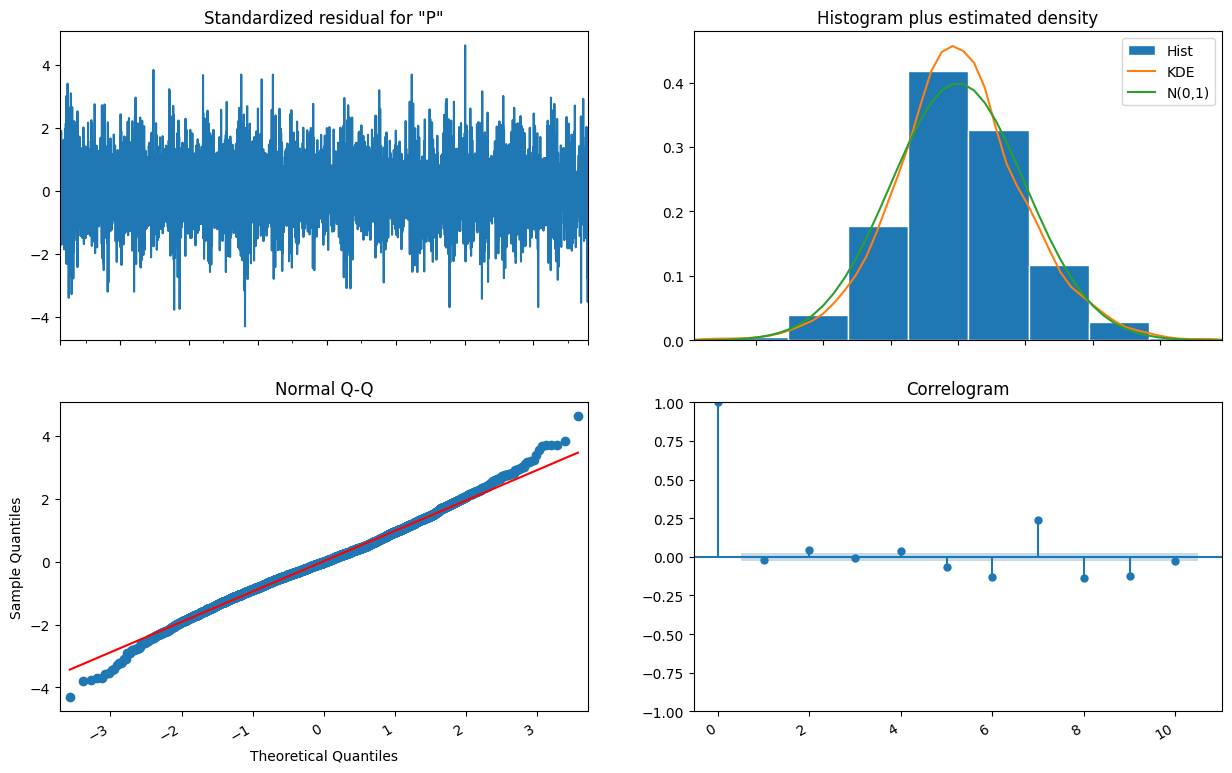

In [75]:
# Отобразим диагностику модели
fig = result.plot_diagnostics(figsize=(15, 10))
fig.autofmt_xdate()
plt.show()

>Важно отметить, что в модели остатки должны быть некоррелированными и нормально распределенными (т.е. среднее значение должно быть равно нулю). То есть центральная точка остатков должна быть равна нулю, и график распределения (KDE) также должен быть центрирован на 0.

>Давайте оценим результаты и визуализируем их.

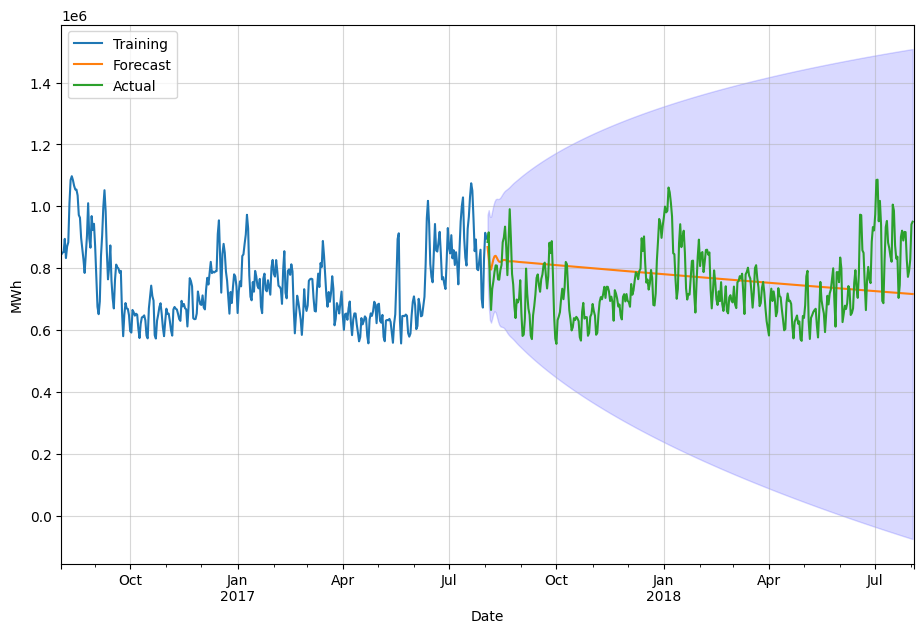

In [76]:
# Получим прогноз и доверительные интервалы на год
forecast = result.get_forecast(steps=365)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Составим прогноз с использованием обучающих данных
ax = df_train.plot()
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervals['lower PJME'], 
                 confidence_intervals['upper PJME'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training', 
            'Forecast', 
            'Actual'], 
            loc='upper left')
plt.xlabel('Date')
plt.ylabel('MWh')
plt.grid(alpha=0.5)

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3)) 
plt.show()

>Таким образом, вы можете видеть, что, несмотря на некоторую настройку, результаты не особенно хороши. Доверительный интервал очень велик, что указывает на то, что модель также не "уверена" в прогнозе.

>Если мы хотим проверить, лучше или хуже ли наша модель другой, например, Экспоненциального сглаживания или Facebook Prophet, мы могли бы рассчитать некоторые показатели и сравнить их. Мы будем использовать среднюю абсолютную ошибку (MAE), среднеквадратичную ошибку (RMSE) и среднюю абсолютную процентную ошибку (MAPE).

In [77]:
predicted_values = forecast_values.values
actual_values = df_test.values.flatten()

# Mean Absolute Error (MAE)
SARIMA_mae_error = np.mean(np.abs(predicted_values - actual_values)).round(3)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
SARIMA_rmse_error = np.sqrt(mse).round(3)

# Mean Absolute Percentage Error (MAPE)
SARIMA_mape_error = (np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100).round(3)

# Mean Absolute Percentage Error (R2)
SARIMA_r2_error = np.mean(r2_score(actual_values, predicted_values)).round(3)

print(
    "\nMAE SARIMA:", SARIMA_mae_error,
    "\nRMSE SARIMA:", SARIMA_rmse_error,
    "\nMAPE SARIMA:", SARIMA_mape_error,
    "\nR2 SARIMA:", SARIMA_r2_error
    )


MAE SARIMA: 96365.165 
RMSE SARIMA: 118034.41 
MAPE SARIMA: 13.157 
R2 SARIMA: -0.224


<a id="5.7">

### <b> 5.7 <span style='color:#FFAE42'> | </span> Prophet</b>

>Наконец, мы будем использовать Facebook Prophet - библиотеку с открытым исходным кодом, которая также является обобщенной аддитивной моделью (т.е. конечный результат состоит из нескольких компонентов, сложенных вместе).<br>
>В отличие от обычных обобщенных линейных моделей, Facebook Prophet's использует байесовский подход к подбору кривой. Концепция байесовской теоремы на высоком уровне заключается в попытке определить вероятность связанных событий с учетом знаний / предположений, которые вы уже знаете (т.е. "предварительных данных").<br>
>Поскольку он фокусируется на поиске множества возможных параметров и вероятности каждого из них, а не на поиске фиксированных оптимальных значений для модели. Степень определенности (или неопределенности) модели в отношении каждого возможного параметра известна как "интервал неопределенности" - чем меньше данных видит модель, тем больше этот интервал.

>Prophet работает довольно хорошо из коробки, поэтому просто придерживаемся гиперпараметров по умолчанию.
>Результаты можно увидеть ниже, где черные точки представляют исторические точки, а синяя линия представляет прогноз:

In [78]:
# Prophet принимает только `ds` и `y` в качестве имён столбцов
ftrain = df_train.reset_index().rename(columns={'Datetime':'ds', 'PJME': 'y'})

model = Prophet(
    n_changepoints=25, # Default is 25
    changepoint_prior_scale=0.05, # Default is 0.05
    seasonality_mode='additive',
    interval_width=0.8 # CI - default is 0.8 or 80%
    )
model.fit(ftrain)

# Создадим будущий фрейм данных с диапазоном дат, который будет использоваться для проверки точности
future_df = df_test.reset_index()['Datetime'].to_frame().rename(columns={"Datetime":'ds'})

# Предсказываем будущее
forecast = model.predict(future_df)
PROPHET_prediction = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']][-366:]
PROPHET_prediction = PROPHET_prediction.rename(columns={'yhat': 'PJME'})

14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
Prophet_mae_error = meanabs(df_test['PJME'], PROPHET_prediction['PJME'])
Prophet_rmse_error = rmse(df_test['PJME'], PROPHET_prediction['PJME'])
Prophet_mape_error = mean_absolute_percentage_error(df_test['PJME'], PROPHET_prediction['PJME'])*100
Prophet_r2_error = r2_score(df_test['PJME'], PROPHET_prediction['PJME'])

print(
    "\nMAE Prophet: {:.3f}".format(Prophet_mae_error),
    "\nRMSE Prophet: {:.3f}".format(Prophet_rmse_error),
    "\nMAPE Prophet: {:.3f}".format(Prophet_mape_error),
    "\nR2 Prophet: {:.3f}".format(Prophet_r2_error)                        
    ) 


MAE Prophet: 61767.226 
RMSE Prophet: 83526.460 
MAPE Prophet: 7.973 
R2 Prophet: 0.387


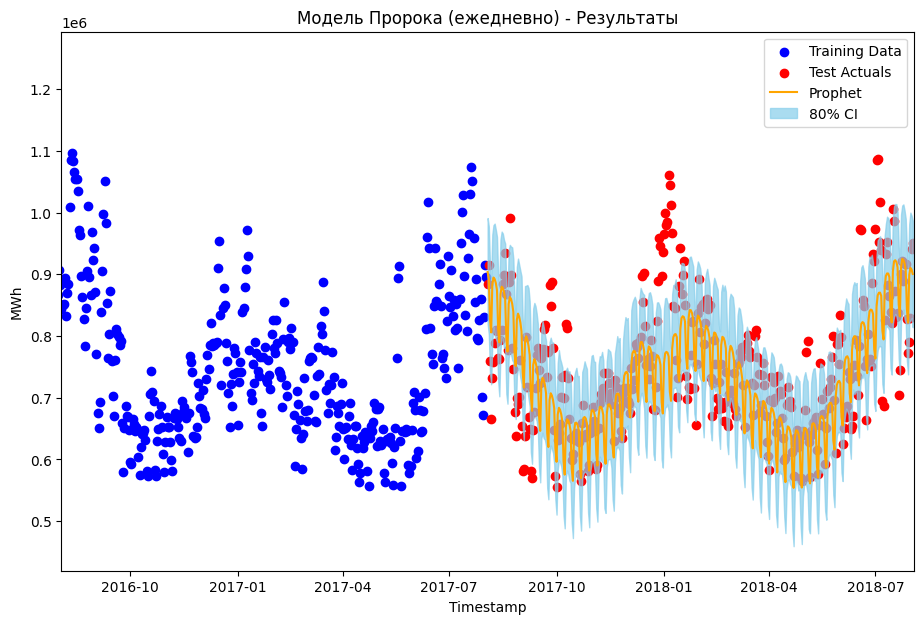

In [80]:
# Давайте визуально посмотрим на результаты
plt.scatter(
    x=df_train.index,
    y=df_train['PJME'],
    label='Training Data',
    color='blue'
    )
plt.scatter(
    x=df_test.index,
    y=df_test['PJME'],
    label='Test Actuals',
    color='red'
    )
plt.plot(
    PROPHET_prediction['PJME'],
    label='Prophet',
    color='orange'
    )

# Построим доверительный интервал
plt.fill_between(
    PROPHET_prediction.index,
    PROPHET_prediction['yhat_lower'],
    PROPHET_prediction['yhat_upper'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('Модель Пророка (ежедневно) - Результаты')

# Для наглядности ограничимся только 2016 - 2018 годами
plt.xlim(datetime(2016, 8, 3),datetime(2018, 8, 3)) 

plt.show()

>Мы можем видеть 80% доверительный интервал (выделен светло-синим цветом), указывающий на то, что модель уверена в том, что 80% фактических данных окажутся в этом прогнозируемом диапазоне.

>Как и у Холта Уинтерса, давайте посмотрим на компоненты модели:

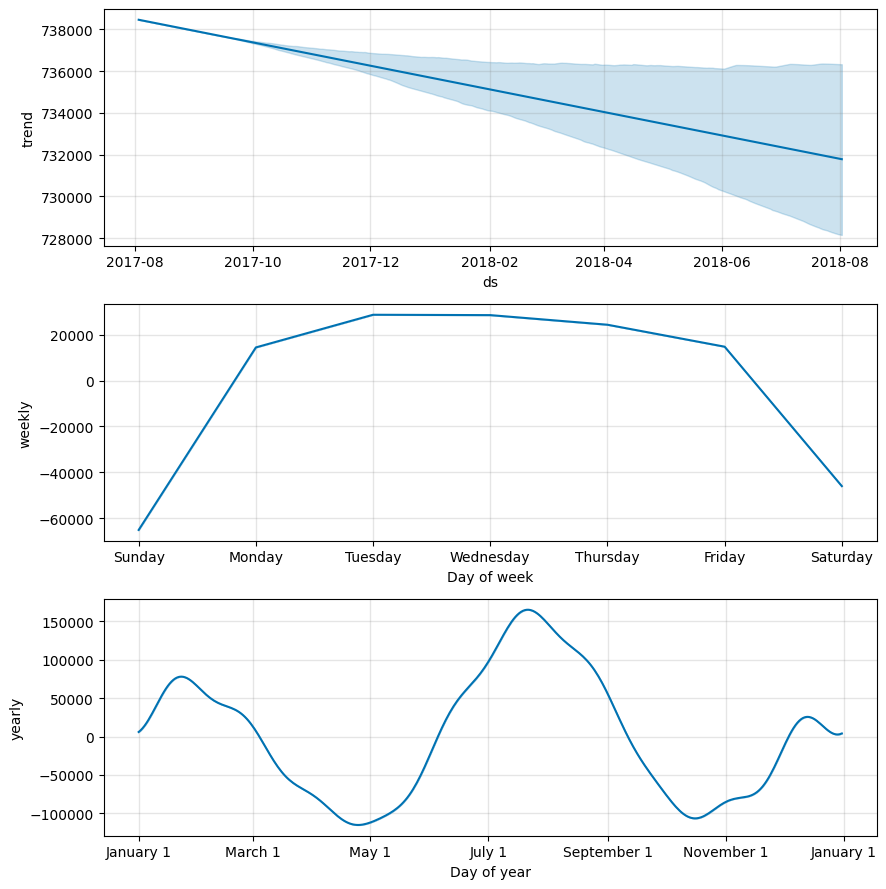

In [81]:
model.plot_components(forecast)

plt.show()

>Мы можем легко увидеть сезонность и тенденции - с каждым годом наблюдается четкая тенденция к снижению и сезонность (зимой используется больше электроэнергии).

>Теперь давайте оценим остатки и посмотрим, является ли модель каким-либо образом предвзятой. Сначала мы рассмотрим распределение ошибок:

In [82]:
# Сначала построим остатки - в основном ошибки
prophet_errors = PROPHET_prediction.copy()
prophet_errors['PJME_ACTUAL'] = df_test['PJME']
prophet_errors['error'] = prophet_errors['PJME'] - prophet_errors['PJME_ACTUAL']

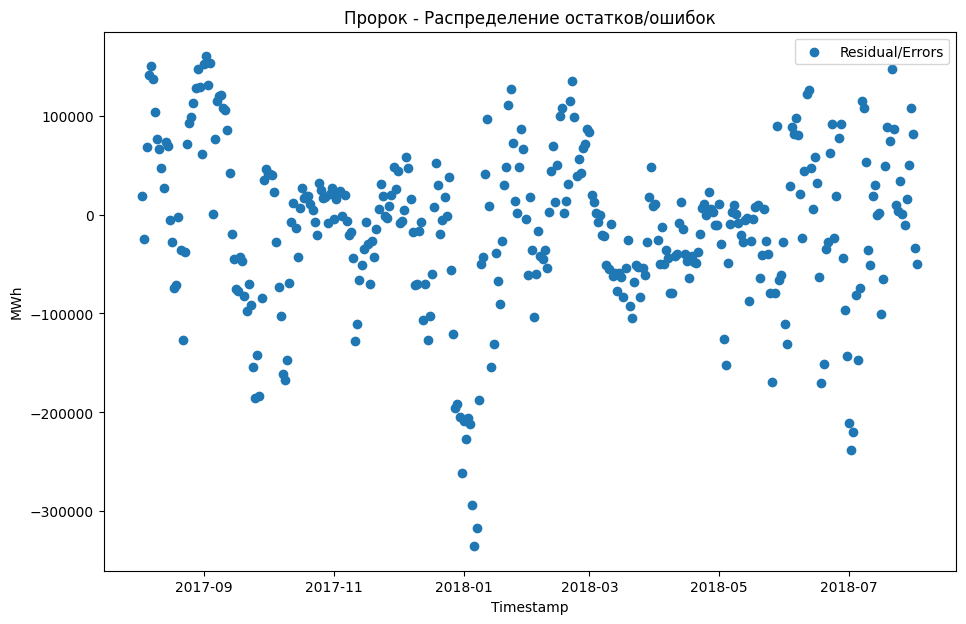

In [83]:
# Давайте визуально увидим ошибки с помощью диаграммы рассеяния
plt.scatter(prophet_errors.index, prophet_errors['error'], label='Residual/Errors')

# Графические метки, легенды и т.д.
plt.title('Пророк - Распределение остатков/ошибок')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')

plt.show()

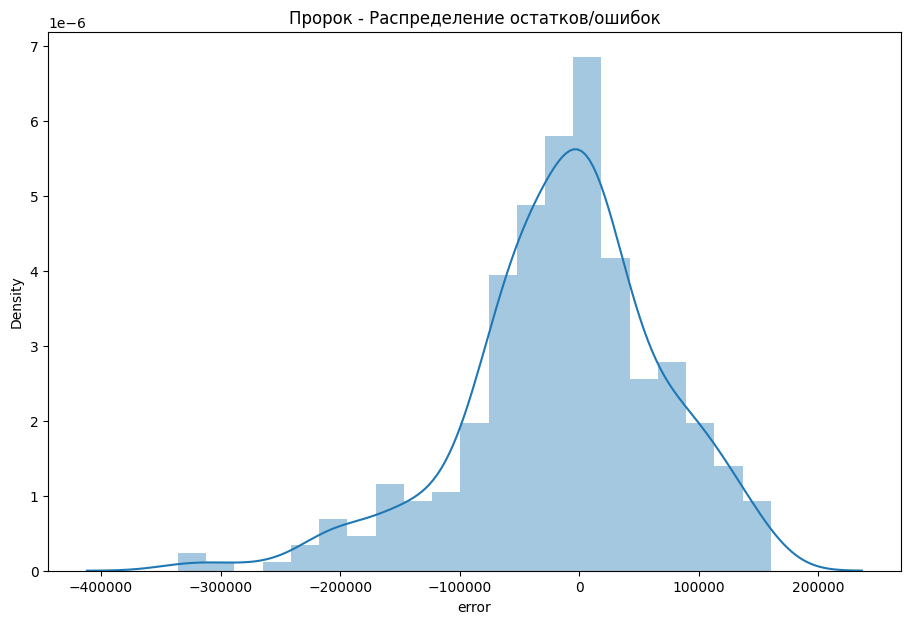

In [84]:
# Построение гистограммы с оценкой плотности ядра (KDE)
sns.distplot(prophet_errors['error'], kde=True);

# Графические метки, легенды и т.д.
plt.title('Пророк - Распределение остатков/ошибок');

>Опять же, мы можем видеть, что ошибки, по-видимому, распределены вокруг нуля, и статистически значимой автокорреляции не происходит. Это указывает на то, что модель не является предвзятой и не склоняется к занижению или завышению прогноза.

>Однако мы можем видеть, что модель, похоже, немного больше не соответствует прогнозу, особенно в отношении всплесков.

>Давайте подробнее рассмотрим самые большие недооценки:

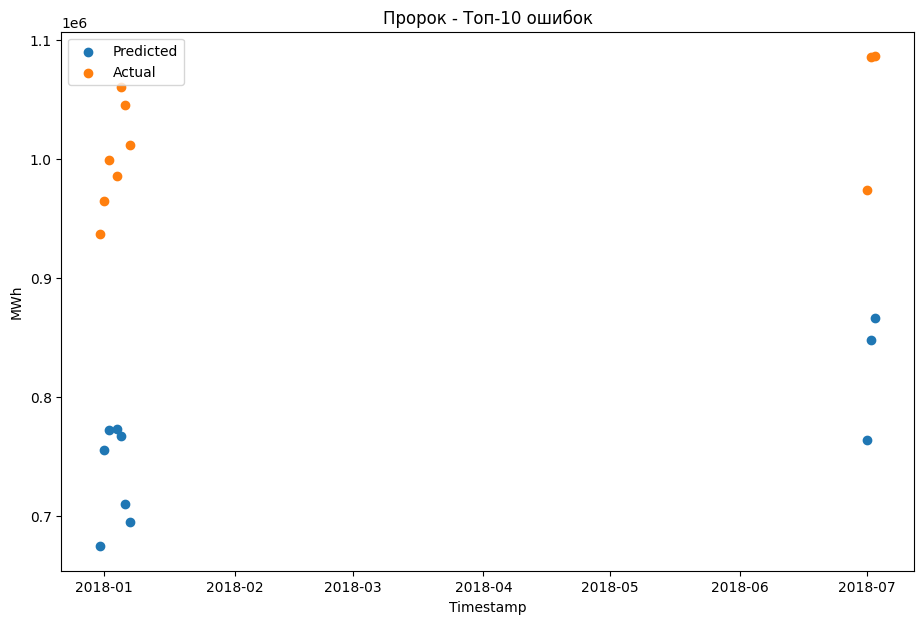

In [85]:
# Давайте получим топ-10 по прогнозам (т.е. где ошибка является наибольшим отрицательным числом)
top_10_errors = prophet_errors.sort_values('error', ascending=True)[['PJME_ACTUAL', 'PJME', 'error']].head(10)

plt.scatter(top_10_errors.index, top_10_errors['PJME'], label='Predicted')
plt.scatter(top_10_errors.index, top_10_errors['PJME_ACTUAL'], label='Actual')

# Ярлыки, заголовки и т.д.
plt.title('Пророк - Топ-10 ошибок')
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best');

In [86]:
top_10_errors.head(10)

PJME_ACTUAL           PJME          error
ds                                                   
2018-01-06    1045578.0  709897.230680 -335680.769320
2018-01-07    1011833.0  694913.473666 -316919.526334
2018-01-05    1060747.0  766962.110129 -293784.889871
2017-12-31     936384.0  674438.043938 -261945.956062
2018-07-02    1085235.0  847345.990160 -237889.009840
2018-01-02     999056.0  771927.811081 -227128.188919
2018-07-03    1086193.0  865856.125903 -220336.874097
2018-01-04     985560.0  773104.136001 -212455.863999
2018-07-01     974036.0  763517.480926 -210518.519074
2018-01-01     964585.0  755653.260982 -208931.739018

>Самыми "не правильными" днями были дни июля и января, пик лета и зимы соответственно. В эти периоды наблюдаются самые большие пики из-за погодных условий.

***
<a id="6">

## <b> 6 <span style='color:#FFAE42'> | </span> ВЫВОДЫ </b>

>Наконец, давайте соберем модели вместе и посмотрим, какая из них получилась лучше всего:

In [87]:
mae_errors = [
    Baseline_mae_error,
    HWES_mae_error,
    XGB_mae_error,
    LASSO_mae_error,
    SARIMA_mae_error,
    Prophet_mae_error
    ]
rmse_errors = [
    Baseline_rmse_error,
    HWES_rmse_error,
    XGB_rmse_error,
    LASSO_rmse_error,
    SARIMA_rmse_error,
    Prophet_rmse_error
    ]
mape_errors = [
    Baseline_mape_error,
    HWES_mape_error,
    XGB_mape_error,
    LASSO_mape_error,
    SARIMA_mape_error,
    Prophet_mape_error
    ]
r2_errors = [
    Baseline_r2_error,
    HWES_r2_error,
    XGB_r2_error,
    LASSO_r2_error,
    SARIMA_r2_error,
    Prophet_r2_error
    ]
errors = pd.DataFrame({
    "Models" : ["Baseline", "HWES", "XGBoost", "LASSO", "SARIMA", "Prophet"],
    "MAE" : mae_errors,
    "RMSE" : rmse_errors,
    "MAPE" : mape_errors,
    "R2" : r2_errors
    })

errors.round(2)

Models        MAE       RMSE   MAPE    R2
0  Baseline   69773.47   94868.32   9.15  0.21
1      HWES  124601.36  144758.37  17.68 -0.84
2   XGBoost   31141.44   40434.61   4.20  0.86
3     LASSO   35615.34   43906.67   4.78  0.83
4    SARIMA   96365.16  118034.41  13.16 -0.22
5   Prophet   61767.23   83526.46   7.97  0.39

>Для наглядности визуализируем все данные.

In [88]:
def plot_model_result(ax, prediction, model_name, color):
    '''
    Постройте график результатов моделирования.
    
    prediction : DataFrame
    model_name : str
    
    return ax
    '''
    # Фактические результаты обучения и тестирования
    ax.scatter(
        x=df_train.index,
        y=df_train['PJME'],
        label='Training Data',
        color='black'
        )
    ax.scatter(
        x=df_test.index,
        y=df_test['PJME'],
        label='Test Actuals',
        color='red'
        )

    # Результаты моделирования
    ax.plot(prediction['PJME'], label=model_name, color=color, alpha=0.7)
    
    # Для ясности давайте ограничимся только августом 2016 года и далее
    ax.set_xlim(datetime(2016, 8, 1),datetime(2018, 10, 1))

    # Установить ось Y
    ax.set_ylim(500000, 1100000)
   
    # Установить метки осей
    ax.set_ylabel("MWh")
    ax.legend(loc='best')
    ax.set_title(
        "{}: MAPE: {:.2f}% | MAE: {:.2f}".format(
            model_name, mean_absolute_percentage_error(df_test["PJME"], prediction["PJME"])*100,
            mean_absolute_error(df_test["PJME"], prediction["PJME"])
            )
        , fontsize=40
    )

    return ax

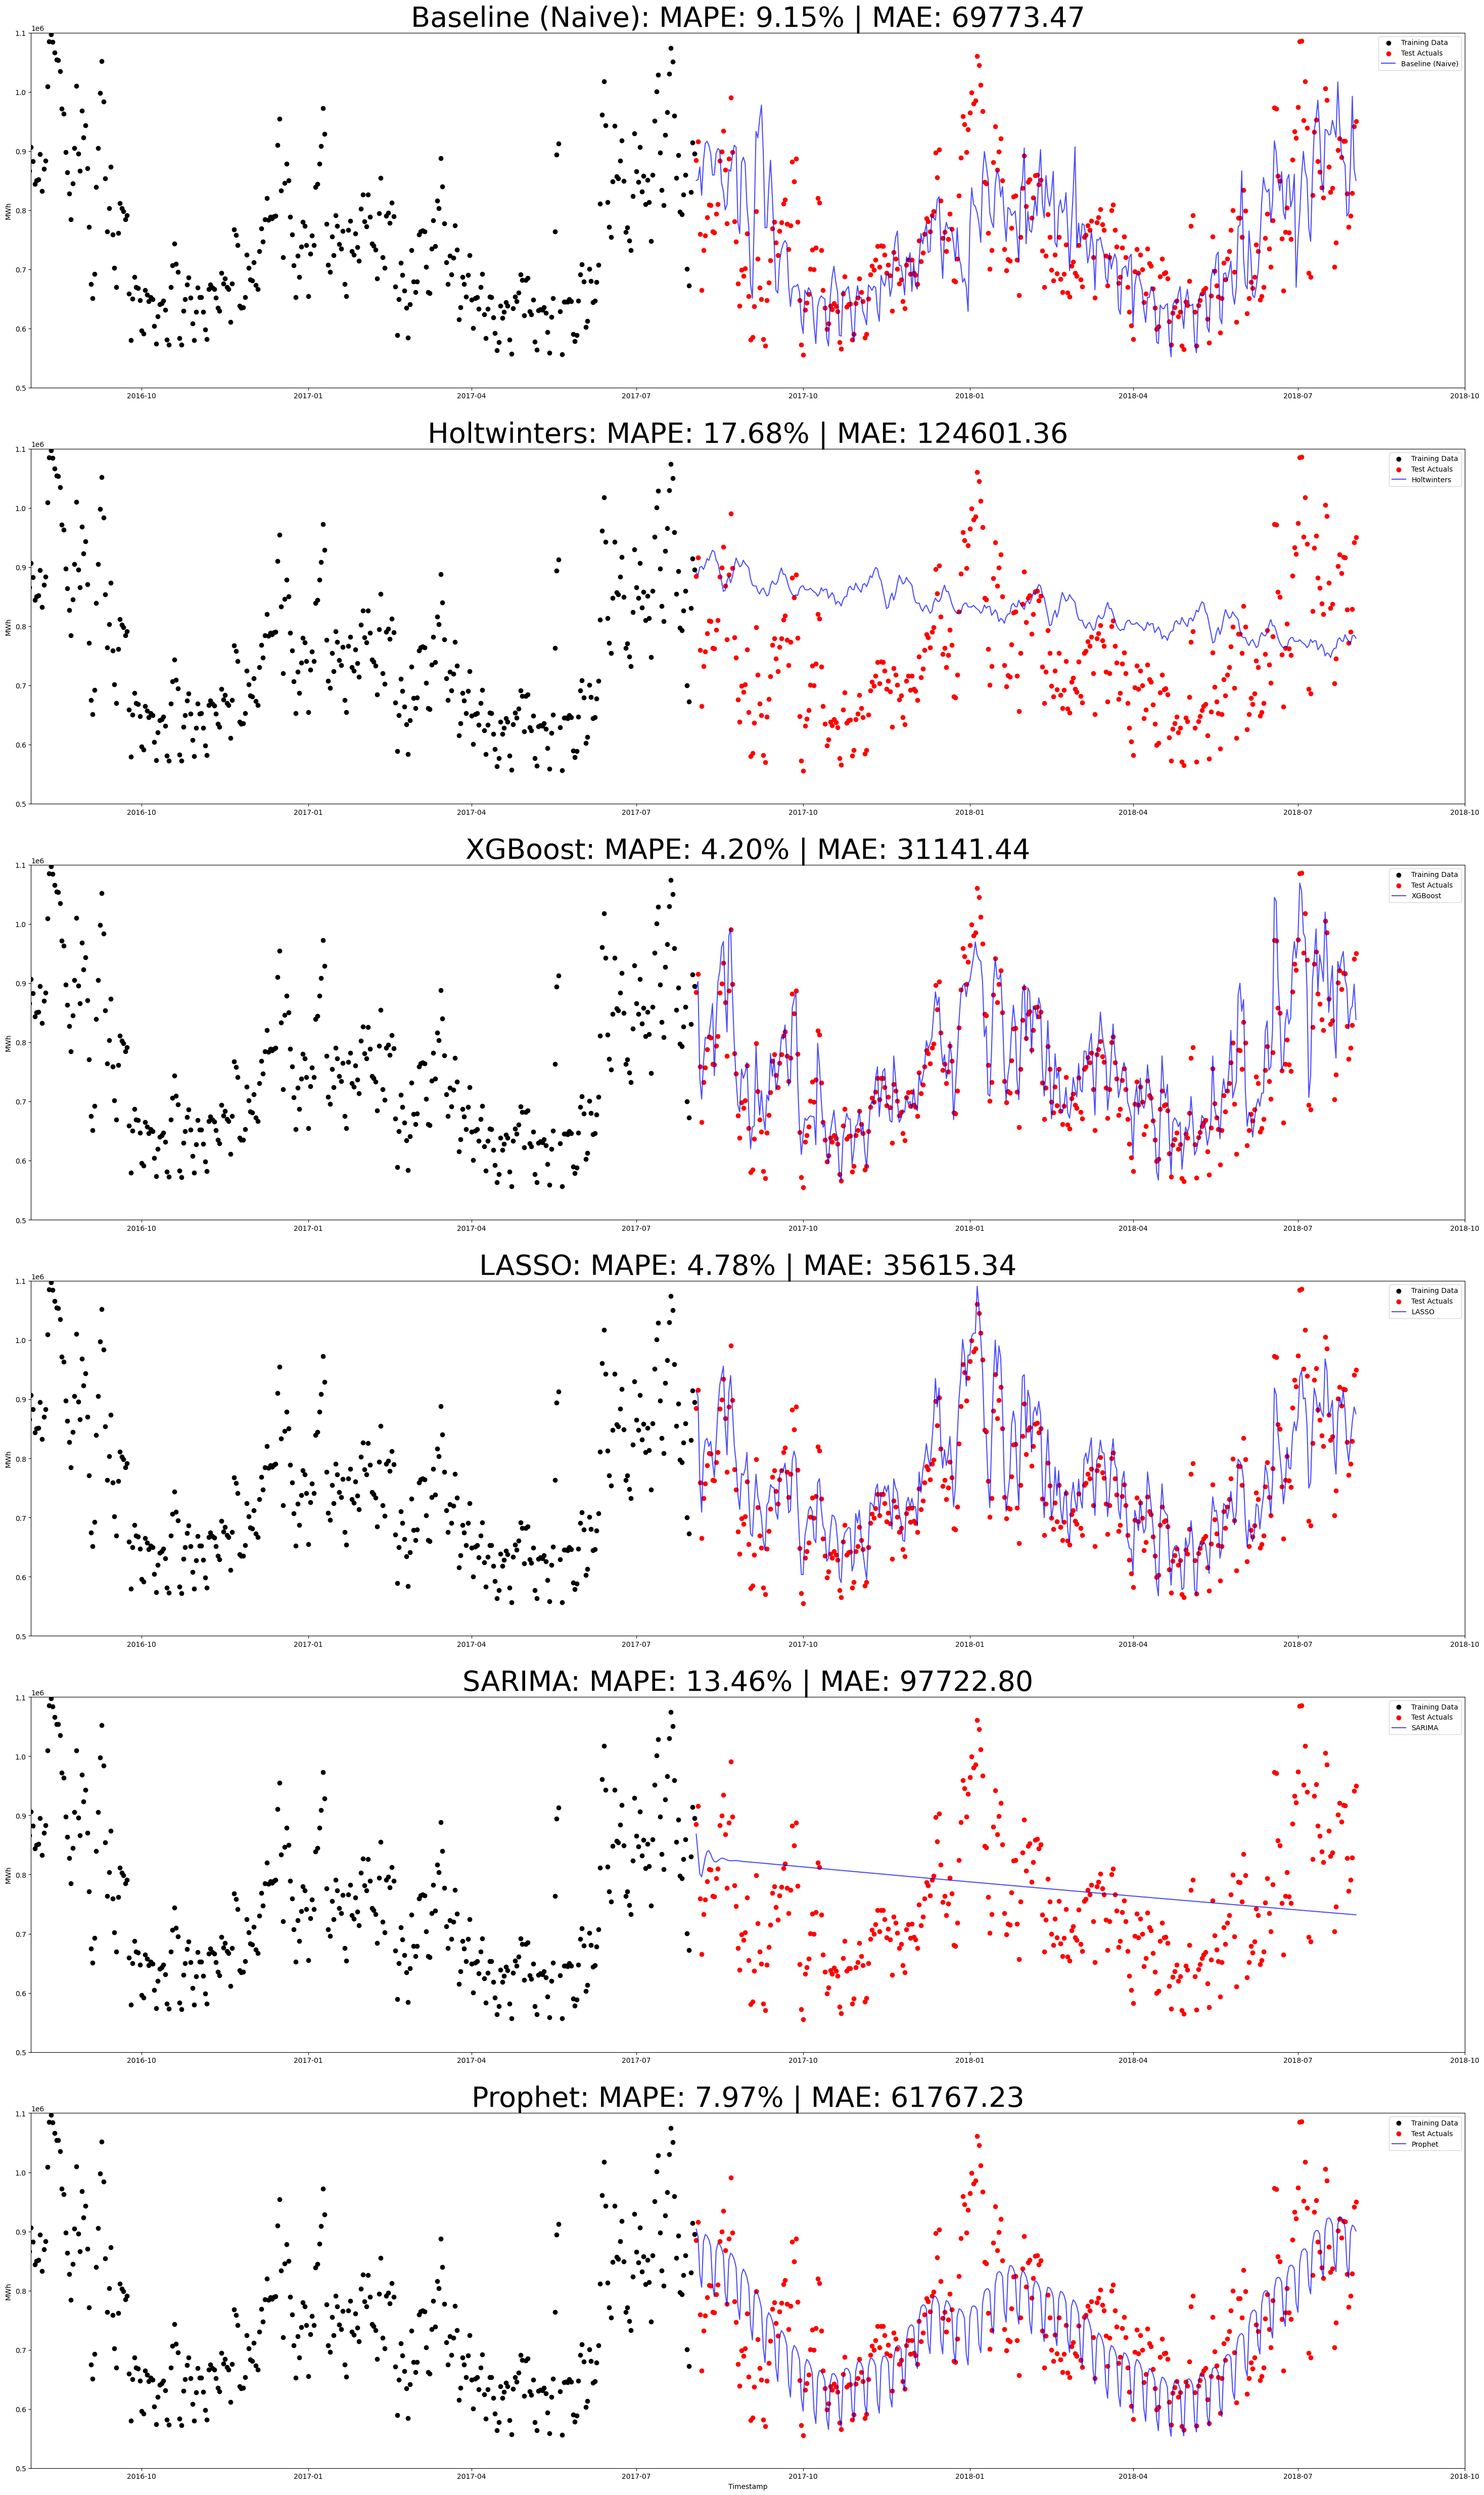

In [89]:
fig, ax = plt.subplots(6,1, figsize=(30,50))

# Графические метки, легенды и т.д.
plt.xlabel("Timestamp")

ax[0] = plot_model_result(ax[0], baseline_pred_v2, model_name='Baseline (Naive)', color='blue')
ax[1] = plot_model_result(ax[1], HWES_pred, model_name='Holtwinters', color='blue')
ax[2] = plot_model_result(ax[2], XGB_prediction_no_lag, model_name='XGBoost', color='blue')
ax[3] = plot_model_result(ax[3], LASSO_prediction, model_name='LASSO', color='blue')
ax[4] = plot_model_result(ax[4], SARIMA_prediction, model_name='SARIMA', color='blue')
ax[5] = plot_model_result(ax[5], PROPHET_prediction, model_name='Prophet', color='blue')

plt.tight_layout(pad=3.0)
plt.show()

>Чем меньше погрешность, тем лучше / точнее модель, поэтому в данном случае победителем становится *XGBoost*! Тем не менее, *LASSO* занимают довольно близкое второе место!

>Мы можем видеть, что в этом наборе данных было много шума, и, несмотря на высокую сезонность, более традиционные статистические подходы, такие как *Holtwinters* и *SARIMA*, не смогли справиться со всем этим шумом.

>Интересно, что все модели прогнозирования превзошли исходные данные, за исключением *Holtwinters* и *SARIMA*. Это, по крайней мере, демонстрирует, что нам все еще лучше использовать эти модели, чем просто делать наивные прогнозы.

>Мы определилисьс моделью. Теперь выполним продакшн модели.

In [90]:
import pickle
# Сделаем `pkl`-файл нашей модели
pickle.dump(errors, open("model.pkl", "wb"))